# Demo for processing NIRSpec data from DD-2736 (PI: Pontoppidon)

ERO data of the SMACS-0723 field

In [1]:
import os
for k in ['CRDS_SERVER_URL','CRDS_PATH']:
    if k not in os.environ:
        print(f"Environment variable {k} not set, `jwst` pipeline won't work")
    else:
        print(f"{k}: {os.environ[k]}")

CRDS_SERVER_URL: https://jwst-crds.stsci.edu
CRDS_PATH: /Users/gbrammer/Research/grizli/crds_cache


In [2]:
import os
os.environ['CRDS_CTX'] = 'jwst_1075.pmap'

import glob
import yaml

import numpy as np
import matplotlib.pyplot as plt

import astropy.io.fits as pyfits

import msaexp
from msaexp import pipeline
import grizli.utils


print(f'msaexp version = {msaexp.__version__}')

msaexp version = 0.6.8.dev1+gf0d9f49.d20230330


In [3]:
os.getcwd()

'/usr/local/share/python/msaexp/docs/examples'

# Query MAST for NIRSpec data

Query by program name and download `rate.fits` files with `mastquery`.  May need to set `$MAST_TOKEN` environment variable to enable the downloads from MAST.

Can optionally limit the query to specific 

 - gratings:  ``prism``, ``g140m``, ``g235m``, ``g395m``, ``g140m``, ``g235m``, ``g395m``
 - filters:  ``clear``, ``f170lp``, ``f100lp``, ``f170lp``, ``f290lp``
 - detectors: ``nrs1``, ``nrs2``
 
 

In [4]:
# Query NIRSpec data for a program name
masks = pipeline.query_program(2736, download=True, gratings=['g395m']) 

2023-03-30 17:43:07,365 - stpipe - INFO - MAST API token accepted, welcome Gabriel Brammer


INFO: MAST API token accepted, welcome Gabriel Brammer [astroquery.mast.auth]


In [5]:
masks['filename','program','filter','grating','detector','msametfl']

<Table length=12>
                filename                program filter grating detector          msametfl        
                 str39                   int64   str6    str5    str4             str25          
--------------------------------------- ------- ------ ------- -------- -------------------------
jw02736007001_03103_00001_nrs1_s2d.fits    2736 F290LP   G395M     NRS1 jw02736007001_01_msa.fits
jw02736007001_03103_00001_nrs2_s2d.fits    2736 F290LP   G395M     NRS2 jw02736007001_01_msa.fits
jw02736007001_03103_00002_nrs1_s2d.fits    2736 F290LP   G395M     NRS1 jw02736007001_01_msa.fits
jw02736007001_03103_00002_nrs2_s2d.fits    2736 F290LP   G395M     NRS2 jw02736007001_01_msa.fits
jw02736007001_03103_00003_nrs1_s2d.fits    2736 F290LP   G395M     NRS1 jw02736007001_01_msa.fits
jw02736007001_03103_00003_nrs2_s2d.fits    2736 F290LP   G395M     NRS2 jw02736007001_01_msa.fits
jw02736008001_03103_00001_nrs1_s2d.fits    2736 F290LP   G395M     NRS1 jw02736008001_01_msa.fits
jw02736008001_03103_00001_nrs2_s2d.fits    2736 F290LP   G395M     NRS2 jw02736008001_01_msa.fits
jw02736008001_03103_00002_nrs1_s2d.fits    2736 F290LP   G395M     NRS1 jw02736008001_01_msa.fits
jw02736008001_03103_00002_nrs2_s2d.fits    2736 F290LP   G395M     NRS2 jw02736008001_01_msa.fits
jw02736008001_03103_00003_nrs1_s2d.fits    2736 F290LP   G395M     NRS1 jw02736008001_01_msa.fits
jw02736008001_03103_00003_nrs2_s2d.fits    2736 F290LP   G395M     NRS2 jw02736008001_01_msa.fits

# Initialize pipeline

Exposures are grouped by detector and with a common `MSAMETFL` metadata file for the MSA setup.

In [6]:
import glob
files = glob.glob('jw02736*rate.fits')
files.sort()
groups = pipeline.exposure_groups(files=files)
groups

   N  value     
====  ==========
   3  jw02736007001-01-f290lp-g395m-nrs1
   3  jw02736007001-01-f290lp-g395m-nrs2
   3  jw02736008001-01-f290lp-g395m-nrs1
   3  jw02736008001-01-f290lp-g395m-nrs2


OrderedDict([('jw02736007001-01-f290lp-g395m-nrs1',
              ['jw02736007001_03103_00001_nrs1_rate.fits',
               'jw02736007001_03103_00002_nrs1_rate.fits',
               'jw02736007001_03103_00003_nrs1_rate.fits']),
             ('jw02736007001-01-f290lp-g395m-nrs2',
              ['jw02736007001_03103_00001_nrs2_rate.fits',
               'jw02736007001_03103_00002_nrs2_rate.fits',
               'jw02736007001_03103_00003_nrs2_rate.fits']),
             ('jw02736008001-01-f290lp-g395m-nrs1',
              ['jw02736008001_03103_00001_nrs1_rate.fits',
               'jw02736008001_03103_00002_nrs1_rate.fits',
               'jw02736008001_03103_00003_nrs1_rate.fits']),
             ('jw02736008001-01-f290lp-g395m-nrs2',
              ['jw02736008001_03103_00001_nrs2_rate.fits',
               'jw02736008001_03103_00002_nrs2_rate.fits',
               'jw02736008001_03103_00003_nrs2_rate.fits'])])

## MSAMETF metadata file

In [7]:
import msaexp.msa
msa = msaexp.msa.MSAMetafile('jw02736007001_01_msa.fits')

msa.src_table[msa.src_table['source_id'] > 0][:10]

<Table length=10>
program source_id source_name alias         ra                dec         preimage_id stellarity
 int32    int32      str20    str31      float64            float64          str30     float64  
------- --------- ----------- ----- ------------------ ------------------ ----------- ----------
   2736      1370   2736_1370  1370 110.86143524246019 -73.47055075824528        None        0.1
   2736      1679   2736_1679  1679 110.78745875908942 -73.46790967459505        None        0.1
   2736      1917   2736_1917  1917 110.87112157484634 -73.46572380454734        None        0.1
   2736      2038   2736_2038  2038  110.8713165212675 -73.46477523235114        None        0.1
   2736      2572   2736_2572  2572 110.76633104380528 -73.46108486689354        None        1.0
   2736      2653   2736_2653  2653 110.77780472623655 -73.46044561888044        None        1.0
   2736      3042   2736_3042  3042  110.7533321732116 -73.45770341069363        None        0.1
   2736      3772   2736_3772  3772 110.74605528535301 -73.45327524433173        None        0.1
   2736      4580   2736_4580  4580 110.79461736895425 -73.44916191536561        None        0.1
   2736      4590   2736_4590  4590 110.85932870207512 -73.44916559196156        None        0.1

In [8]:
slitlet_id = msa.shutter_table['slitlet_id'][msa.shutter_table['source_id'] == 4590][0]

slitlets = (msa.shutter_table['slitlet_id'] == slitlet_id) & (msa.shutter_table['msa_metadata_id'] == 1)
msa.shutter_table[slitlets]

<Table length=9>
slitlet_id msa_metadata_id shutter_quadrant shutter_row shutter_column source_id ... dither_point_index primary_source         ra                dec         program
  int16         int16           int16          int16        int16        int32   ...       int16             str1           float64            float64        int64 
---------- --------------- ---------------- ----------- -------------- --------- ... ------------------ -------------- ------------------ ------------------ -------
        55               1                3          27            165      4590 ...                  1              N 110.85932870207512 -73.44916559196156    2736
        55               1                3          27            165      4590 ...                  2              Y 110.85932870207512 -73.44916559196156    2736
        55               1                3          27            165      4590 ...                  3              N 110.85932870207512 -73.44916559196156    2736
        55               1                3          27            166      4590 ...                  1              Y 110.85932870207512 -73.44916559196156    2736
        55               1                3          27            166      4590 ...                  2              N 110.85932870207512 -73.44916559196156    2736
        55               1                3          27            166      4590 ...                  3              N 110.85932870207512 -73.44916559196156    2736
        55               1                3          27            167      4590 ...                  1              N 110.85932870207512 -73.44916559196156    2736
        55               1                3          27            167      4590 ...                  2              N 110.85932870207512 -73.44916559196156    2736
        55               1                3          27            167      4590 ...                  3              Y 110.85932870207512 -73.44916559196156    2736

In [9]:
# Transforms calculated emprically between msa slit coords and ra/dec

regs = msa.regions_from_metafile(as_string=True)
print('\n'.join(regs.split('\n')[:29]) + '\n...')

# msametfl = jw02736007001_01_msa.fits
# dither_point_index = 1
# msa_metadata_id = 1
# Q1 N=15  rms= 0.2, 0.7 mas
# Q2 N=15  rms= 0.2, 0.2 mas
# Q3 N=12  rms= 0.2, 0.2 mas
# Q4 N=6  rms= 0.0, 0.0 mas
icrs
polygon(110.841398,-73.484322,110.841542,-73.484272,110.841916,-73.484357,110.841773,-73.484407) # color=lightblue
circle(110.8420455, -73.4844337, 0.2") # color=cyan text={-1}
polygon(110.841799,-73.484413,110.841943,-73.484363,110.842317,-73.484448,110.842174,-73.484498) # color=cyan
circle(110.8584674, -73.4865518, 0.2") # color=cyan text={-2}
polygon(110.858216,-73.486531,110.858360,-73.486481,110.858733,-73.486566,110.858590,-73.486616) # color=cyan
polygon(110.791579,-73.471058,110.791724,-73.471008,110.792102,-73.471094,110.791958,-73.471144) # color=lightblue
circle(110.7922446, -73.4711697, 0.2") # color=cyan text={-3}
polygon(110.791984,-73.471150,110.792129,-73.471100,110.792507,-73.471186,110.792363,-73.471237) # color=cyan
circle(110.8475204, -73.4836812, 0.2") # color=c

## Preprocessing pipeline

1. Run 1/f correction and identify "snowballs" on the `rate.fits` files
2. Remove "bias" (i.e., simple median) of each exposure
3. Run parts of the Level 2 JWST calibration pipeline ([calweb_spec2](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html#calwebb-spec2)):
  - [AssignWcs](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.assign_wcs.AssignWcsStep.html) : initialize WCS and populate slit bounding_box data
  - [Extract2dStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.extract_2d.Extract2dStep.html) : identify slits and set slit WCS
  - [FlatFieldStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.flatfield.FlatFieldStep.html#flatfieldstep) : slit-level flat field
  - [PathLossStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.pathloss.PathLossStep.html) : NIRSpec path loss
  - [PhotomStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.photom.PhotomStep.html) : Photometric calibration
  
  Note that the `srctype`, `master_background`, `wavecorr` steps are not performed.  The background subtraction is done manually on the 2D slit cutouts.
  
4. Parse slit metadata
5. Save slit cutout files of the last pipeline step performed (`phot` = `PhotomStep`)

Subsequent re-initialization of the `NirspecPipeline` object and `full_pipeline` method will skip these steps and just load the saved slit cutouts.

In [10]:
# Subset of ids
source_ids = [4590, 6355, 10612, 9239]

for mode in groups:
    if not os.path.exists(f'{mode}.slits.yaml'):
        
        # Run the pipeline to define slits, etc., but don't do extractions yet.  
        pipe = pipeline.NirspecPipeline(mode=mode, source_ids=source_ids, pad=1)
        
        # Pipeline steps
        pipe.full_pipeline(run_extractions=False, initialize_bkg=False, run_flag_open=False)
    else:
        print(f'Skip {mode}')

Skip jw02736007001-01-f290lp-g395m-nrs1
Skip jw02736007001-01-f290lp-g395m-nrs2
Skip jw02736008001-01-f290lp-g395m-nrs1
Skip jw02736008001-01-f290lp-g395m-nrs2


In [11]:
files = glob.glob('*2736*slits.yaml')
files.sort()

all_targets = []
skip = []
for file in files:
    with open(file) as fp:
        slits = yaml.load(fp, Loader=yaml.Loader)
        for k in slits:
            if k.startswith('2736_') & ('m' not in k):
                all_targets.append(k)
            elif k not in skip:
                #print(f'skip {k}')
                skip.append(k)

un = grizli.utils.Unique(all_targets)
targets = un.values
print(len(targets))
#targets

   N  value     
====  ==========
   4  2736_10612
   4  2736_4590 
   4  2736_6355 
   4  2736_9239 
4


In [12]:
from importlib import reload
from msaexp import pipeline
reload(pipeline)
print(pipeline.__file__)

# # Reinitialize pipeline objects
targets = ['2736_4590', '2736_6355', '2736_10612', '2736_9239', '2736_6113']

gratings = {}
for mode in groups:
    if os.path.exists(f'{mode}.slits.yaml') & ('02736' in mode):
        # Run the pipeline to define slits, etc., but don't do extractions yet.  
        obj = pipeline.NirspecPipeline(mode=mode)
        obj.full_pipeline(run_extractions=False, targets=targets)
        
        if obj.grating not in gratings:
            gratings[obj.grating] = []
        
        gratings[obj.grating].append(obj)

/Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/msaexp/pipeline.py
# (2023-03-30 15:43:07.576)
msaexp.NirspecPipeline: Initialize jw02736007001-01-f290lp-g395m-nrs1
msaexp.NirspecPipeline: jw02736007001_03103_00001_nrs1_rate.fits
msaexp.NirspecPipeline: jw02736007001_03103_00002_nrs1_rate.fits
msaexp.NirspecPipeline: jw02736007001_03103_00003_nrs1_rate.fits
msaexp.NirspecPipeline: mode=jw02736007001-01-f290lp-g395m-nrs1 exp_type=NRS_MSASPEC  msametfl=jw02736007001_01_msa.fits
msaexp.read_data: jw02736007001_03103_00001_nrs1_phot.055.2736_4590.fits 2736_4590
msaexp.read_data: jw02736007001_03103_00001_nrs1_phot.072.2736_6355.fits 2736_6355
msaexp.read_data: jw02736007001_03103_00001_nrs1_phot.069.2736_10612.fits 2736_10612
msaexp.read_data: jw02736007001_03103_00001_nrs1_phot.020.2736_9239.fits 2736_9239
msaexp.read_data: jw02736007001_03103_00002_nrs1_phot.055.2736_4590.fits 2736_4590
msaexp.read_data: jw02736007001_03103_00002_nrs1_phot.072.2736_6355.fits 2736_6355


In [13]:
# Have to run `extract_spectrum` for background subtraction
for key in targets:
    for g in gratings:
        for pipe in gratings[g]:
            print(pipe.mode, key)
            try:
                _ = pipe.extract_spectrum(key, yoffset=0.0, fit_profile_params=None)
                plt.close('all')
            except:
                print('    failed! ')
                plt.close('all')
                continue

jw02736007001-01-f290lp-g395m-nrs1 2736_4590


2023-03-30 17:43:28,870 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/msaexp/pipeline.py:1413: RuntimeWarning: All-NaN slice encountered
  pscl = np.nanmax(_running[1])



jw02736007001-01-f290lp-g395m-nrs2 2736_4590
jw02736008001-01-f290lp-g395m-nrs1 2736_4590
jw02736008001-01-f290lp-g395m-nrs2 2736_4590
jw02736007001-01-f290lp-g395m-nrs1 2736_6355
jw02736007001-01-f290lp-g395m-nrs2 2736_6355
jw02736008001-01-f290lp-g395m-nrs1 2736_6355
jw02736008001-01-f290lp-g395m-nrs2 2736_6355
jw02736007001-01-f290lp-g395m-nrs1 2736_10612
jw02736007001-01-f290lp-g395m-nrs2 2736_10612


2023-03-30 17:43:31,400 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

2023-03-30 17:43:31,404 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1558: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



jw02736008001-01-f290lp-g395m-nrs1 2736_10612
jw02736008001-01-f290lp-g395m-nrs2 2736_10612
jw02736007001-01-f290lp-g395m-nrs1 2736_9239
jw02736007001-01-f290lp-g395m-nrs2 2736_9239
jw02736008001-01-f290lp-g395m-nrs1 2736_9239
jw02736008001-01-f290lp-g395m-nrs2 2736_9239
jw02736007001-01-f290lp-g395m-nrs1 2736_6113
jw02736007001-01-f290lp-g395m-nrs1: 2736_6113 not found in slitlets
jw02736007001-01-f290lp-g395m-nrs2 2736_6113
jw02736007001-01-f290lp-g395m-nrs2: 2736_6113 not found in slitlets
jw02736008001-01-f290lp-g395m-nrs1 2736_6113
jw02736008001-01-f290lp-g395m-nrs1: 2736_6113 not found in slitlets
jw02736008001-01-f290lp-g395m-nrs2 2736_6113
jw02736008001-01-f290lp-g395m-nrs2: 2736_6113 not found in slitlets


In [14]:
reload(msaexp.utils)

drizzle_params = {'output':None, 'single':True,
 'pixfrac': 1.0,
 'kernel': 'square',
 'fillval': 0,
 'wht_type': 'ivm',
 'good_bits': 0,
 'pscale_ratio': 1.0,
 'pscale': None}

# Wavelength oversampling relative to grating default
scale = 1.5

# pipes[g].targets


In [15]:
for g in gratings:
    for pipe in gratings[g]:
        print(g, pipe.mode)

f290lp-g395m jw02736007001-01-f290lp-g395m-nrs1
f290lp-g395m jw02736007001-01-f290lp-g395m-nrs2
f290lp-g395m jw02736008001-01-f290lp-g395m-nrs1
f290lp-g395m jw02736008001-01-f290lp-g395m-nrs2


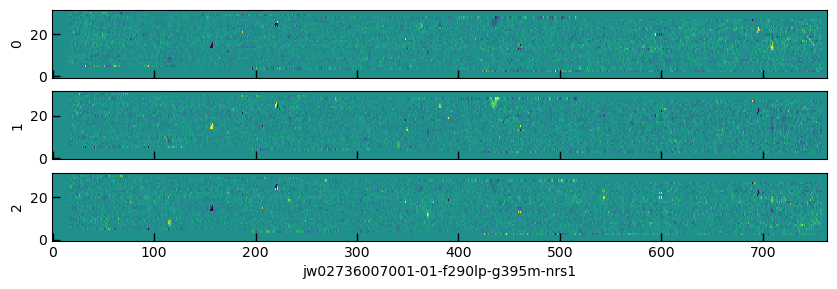

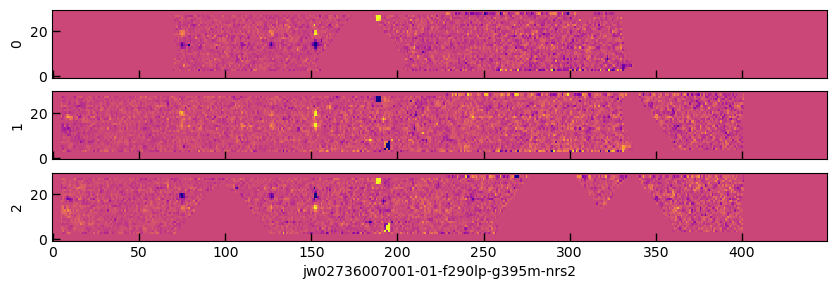

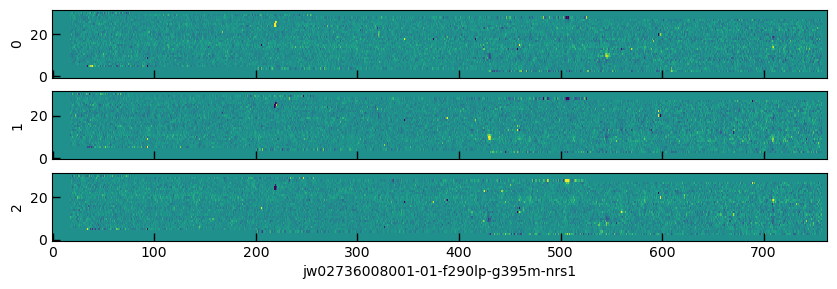

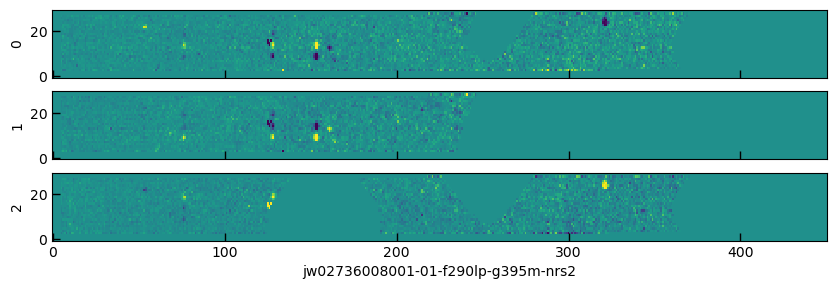

In [16]:
# Look at individual slit cutouts

# 
key = '2736_4590'

hdus = {}
for g in gratings:
    for pipe in gratings[g]:
        _slits = pipe.get_background_slits(key)
        
        fig, axes = plt.subplots(len(_slits), 1, sharex=True, sharey=True, figsize=(10, 3))
        rms = None
        for i, slit in enumerate(_slits):    
            bkg = 0.
            dq = (slit.dq & 1) == 0
            if rms is None:
                rms = grizli.utils.nmad((slit.data - bkg)[dq])
            
            if pipe.mode == 'jw02736007001-01-f290lp-g395m-nrs2':
                cmap = 'plasma_r'
            else:
                cmap = 'viridis'
                
            axes[i].imshow((slit.data - bkg)*dq, vmin=-10*rms, vmax=10*rms, aspect='auto', cmap=cmap)
            axes[i].set_ylabel(i)
            
        axes[i].set_xlabel(pipe.mode)

In [17]:
outroot = f'smacs0723-{g}'
file_version = 'v'+msaexp.__version__.split('+')[0]


Add 2 slitlets from jw02736007001-01-f290lp-g395m-nrs1
Add 2 slitlets from jw02736007001-01-f290lp-g395m-nrs2
Add 3 slitlets from jw02736008001-01-f290lp-g395m-nrs1
Add 3 slitlets from jw02736008001-01-f290lp-g395m-nrs2
f290lp-g395m total 10 slitlets
outlier_threshold:  7.0
msaexp.drizzle.drizzle_slitlets: 2736_4590 read 10 files
msaexp.drizzle.drizzle_slitlets: id=2736_4590  g395m-f290lp N=10
msaexp.drizzle.drizzle_slitlets: get wcs from slit 0 =  2736_4590


2023-03-30 17:43:34,027 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:43:34,027 - stpipe - INFO - Driz parameter pixfrac: 1.0
2023-03-30 17:43:34,028 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:43:34,028 - stpipe - INFO - Driz parameter weight_type: ivm
2023-03-30 17:43:34,199 - stpipe - INFO - Blending metadata for None
2023-03-30 17:43:35,241 - stpipe - INFO - Resampling science data
2023-03-30 17:43:35,276 - stpipe - INFO - Drizzling (32, 764) --> (31, 1414)
2023-03-30 17:43:35,283 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:43:35,316 - stpipe - INFO - Drizzling (32, 764) --> (31, 1414)
2023-03-30 17:43:35,324 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:43:35,356 - stpipe - INFO - Drizzling (32, 764) --> (31, 1414)
2023-03-30 17:43:35,364 - stpipe - INFO - Resampling var_flat
2023-03-30 17:43:35,398 - stpipe - INFO - Drizzling (32, 764) --> (31, 1414)
2023-03-30 17:43:35,818 - stpipe - INFO - Driz parameter kernal: square
2023-03-30

msaexp.drizzle.drizzle_slitlets: output size = (31, 1414)
msaexp.drizzle.drizzle_slitlets: g395m-f290lp  0 2736_4590               4590  0.256 <SlitModel(32, 764) from jw02736007001_03103_00001_nrs1_phot.055.2736_4590.fits> (32, 764)


2023-03-30 17:43:37,110 - stpipe - INFO - Blending metadata for None
2023-03-30 17:43:37,686 - stpipe - INFO - Resampling science data
2023-03-30 17:43:37,720 - stpipe - INFO - Drizzling (32, 764) --> (31, 1414)
2023-03-30 17:43:37,725 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:43:37,760 - stpipe - INFO - Drizzling (32, 764) --> (31, 1414)
2023-03-30 17:43:37,766 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:43:37,799 - stpipe - INFO - Drizzling (32, 764) --> (31, 1414)
2023-03-30 17:43:37,806 - stpipe - INFO - Resampling var_flat
2023-03-30 17:43:37,839 - stpipe - INFO - Drizzling (32, 764) --> (31, 1414)
2023-03-30 17:43:37,990 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:43:37,990 - stpipe - INFO - Driz parameter pixfrac: 0.8
2023-03-30 17:43:37,991 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:43:37,991 - stpipe - INFO - Driz parameter weight_type: ivm


msaexp.drizzle.drizzle_slitlets: g395m-f290lp  1 2736_4590               4590  0.253 <SlitModel(32, 764) from jw02736007001_03103_00003_nrs1_phot.055.2736_4590.fits> (32, 764)


2023-03-30 17:43:38,164 - stpipe - INFO - Blending metadata for None
2023-03-30 17:43:38,730 - stpipe - INFO - Resampling science data
2023-03-30 17:43:38,764 - stpipe - INFO - Drizzling (32, 764) --> (31, 1414)
2023-03-30 17:43:38,769 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:43:38,801 - stpipe - INFO - Drizzling (32, 764) --> (31, 1414)
2023-03-30 17:43:38,807 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:43:38,839 - stpipe - INFO - Drizzling (32, 764) --> (31, 1414)
2023-03-30 17:43:38,845 - stpipe - INFO - Resampling var_flat
2023-03-30 17:43:38,878 - stpipe - INFO - Drizzling (32, 764) --> (31, 1414)
2023-03-30 17:43:39,012 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:43:39,012 - stpipe - INFO - Driz parameter pixfrac: 0.8
2023-03-30 17:43:39,013 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:43:39,013 - stpipe - INFO - Driz parameter weight_type: ivm


msaexp.drizzle.drizzle_slitlets: g395m-f290lp  2 2736_4590               4590  0.256 <SlitModel(30, 450) from jw02736007001_03103_00001_nrs2_phot.055.2736_4590.fits> (30, 450)


2023-03-30 17:43:39,184 - stpipe - INFO - Blending metadata for None
2023-03-30 17:43:39,744 - stpipe - INFO - Resampling science data
2023-03-30 17:43:39,771 - stpipe - INFO - Drizzling (30, 450) --> (31, 1414)
2023-03-30 17:43:39,773 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:43:40,281 - stpipe - INFO - Drizzling (30, 450) --> (31, 1414)
2023-03-30 17:43:40,285 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:43:40,313 - stpipe - INFO - Drizzling (30, 450) --> (31, 1414)
2023-03-30 17:43:40,318 - stpipe - INFO - Resampling var_flat
2023-03-30 17:43:40,345 - stpipe - INFO - Drizzling (30, 450) --> (31, 1414)
2023-03-30 17:43:40,476 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:43:40,477 - stpipe - INFO - Driz parameter pixfrac: 0.8
2023-03-30 17:43:40,477 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:43:40,477 - stpipe - INFO - Driz parameter weight_type: ivm


msaexp.drizzle.drizzle_slitlets: g395m-f290lp  3 2736_4590               4590  0.253 <SlitModel(30, 450) from jw02736007001_03103_00003_nrs2_phot.055.2736_4590.fits> (30, 450)


2023-03-30 17:43:40,646 - stpipe - INFO - Blending metadata for None
2023-03-30 17:43:41,217 - stpipe - INFO - Resampling science data
2023-03-30 17:43:41,244 - stpipe - INFO - Drizzling (30, 450) --> (31, 1414)
2023-03-30 17:43:41,247 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:43:41,276 - stpipe - INFO - Drizzling (30, 450) --> (31, 1414)
2023-03-30 17:43:41,280 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:43:41,307 - stpipe - INFO - Drizzling (30, 450) --> (31, 1414)
2023-03-30 17:43:41,311 - stpipe - INFO - Resampling var_flat
2023-03-30 17:43:41,339 - stpipe - INFO - Drizzling (30, 450) --> (31, 1414)
2023-03-30 17:43:41,482 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:43:41,483 - stpipe - INFO - Driz parameter pixfrac: 0.8
2023-03-30 17:43:41,483 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:43:41,483 - stpipe - INFO - Driz parameter weight_type: ivm


msaexp.drizzle.drizzle_slitlets: g395m-f290lp  4 2736_4590               4590  0.256 <SlitModel(32, 763) from jw02736008001_03103_00001_nrs1_phot.055.2736_4590.fits> (32, 763)


2023-03-30 17:43:41,652 - stpipe - INFO - Blending metadata for None
2023-03-30 17:43:42,220 - stpipe - INFO - Resampling science data
2023-03-30 17:43:42,253 - stpipe - INFO - Drizzling (32, 763) --> (31, 1414)
2023-03-30 17:43:42,258 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:43:42,291 - stpipe - INFO - Drizzling (32, 763) --> (31, 1414)
2023-03-30 17:43:42,298 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:43:42,330 - stpipe - INFO - Drizzling (32, 763) --> (31, 1414)
2023-03-30 17:43:42,337 - stpipe - INFO - Resampling var_flat
2023-03-30 17:43:42,372 - stpipe - INFO - Drizzling (32, 763) --> (31, 1414)
2023-03-30 17:43:42,518 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:43:42,518 - stpipe - INFO - Driz parameter pixfrac: 0.8
2023-03-30 17:43:42,519 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:43:42,519 - stpipe - INFO - Driz parameter weight_type: ivm


msaexp.drizzle.drizzle_slitlets: g395m-f290lp  5 2736_4590               4590  0.260 <SlitModel(32, 763) from jw02736008001_03103_00002_nrs1_phot.055.2736_4590.fits> (32, 763)


2023-03-30 17:43:42,691 - stpipe - INFO - Blending metadata for None
2023-03-30 17:43:43,255 - stpipe - INFO - Resampling science data
2023-03-30 17:43:43,287 - stpipe - INFO - Drizzling (32, 763) --> (31, 1414)
2023-03-30 17:43:43,291 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:43:43,324 - stpipe - INFO - Drizzling (32, 763) --> (31, 1414)
2023-03-30 17:43:43,329 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:43:43,364 - stpipe - INFO - Drizzling (32, 763) --> (31, 1414)
2023-03-30 17:43:43,369 - stpipe - INFO - Resampling var_flat
2023-03-30 17:43:43,402 - stpipe - INFO - Drizzling (32, 763) --> (31, 1414)
2023-03-30 17:43:43,547 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:43:43,548 - stpipe - INFO - Driz parameter pixfrac: 0.8
2023-03-30 17:43:43,548 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:43:43,548 - stpipe - INFO - Driz parameter weight_type: ivm


msaexp.drizzle.drizzle_slitlets: g395m-f290lp  6 2736_4590               4590  0.253 <SlitModel(32, 763) from jw02736008001_03103_00003_nrs1_phot.055.2736_4590.fits> (32, 763)


2023-03-30 17:43:43,718 - stpipe - INFO - Blending metadata for None
2023-03-30 17:43:44,331 - stpipe - INFO - Resampling science data
2023-03-30 17:43:44,364 - stpipe - INFO - Drizzling (32, 763) --> (31, 1414)
2023-03-30 17:43:44,369 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:43:44,403 - stpipe - INFO - Drizzling (32, 763) --> (31, 1414)
2023-03-30 17:43:44,409 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:43:44,444 - stpipe - INFO - Drizzling (32, 763) --> (31, 1414)
2023-03-30 17:43:44,451 - stpipe - INFO - Resampling var_flat
2023-03-30 17:43:44,483 - stpipe - INFO - Drizzling (32, 763) --> (31, 1414)
2023-03-30 17:43:44,619 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:43:44,619 - stpipe - INFO - Driz parameter pixfrac: 0.8
2023-03-30 17:43:44,620 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:43:44,620 - stpipe - INFO - Driz parameter weight_type: ivm


msaexp.drizzle.drizzle_slitlets: g395m-f290lp  7 2736_4590               4590  0.256 <SlitModel(30, 451) from jw02736008001_03103_00001_nrs2_phot.055.2736_4590.fits> (30, 451)


2023-03-30 17:43:45,244 - stpipe - INFO - Blending metadata for None
2023-03-30 17:43:45,823 - stpipe - INFO - Resampling science data
2023-03-30 17:43:45,851 - stpipe - INFO - Drizzling (30, 451) --> (31, 1414)
2023-03-30 17:43:45,854 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:43:45,882 - stpipe - INFO - Drizzling (30, 451) --> (31, 1414)
2023-03-30 17:43:45,886 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:43:45,914 - stpipe - INFO - Drizzling (30, 451) --> (31, 1414)
2023-03-30 17:43:45,918 - stpipe - INFO - Resampling var_flat
2023-03-30 17:43:45,947 - stpipe - INFO - Drizzling (30, 451) --> (31, 1414)
2023-03-30 17:43:46,081 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:43:46,081 - stpipe - INFO - Driz parameter pixfrac: 0.8
2023-03-30 17:43:46,081 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:43:46,081 - stpipe - INFO - Driz parameter weight_type: ivm


msaexp.drizzle.drizzle_slitlets: g395m-f290lp  8 2736_4590               4590  0.260 <SlitModel(30, 451) from jw02736008001_03103_00002_nrs2_phot.055.2736_4590.fits> (30, 451)


2023-03-30 17:43:46,253 - stpipe - INFO - Blending metadata for None
2023-03-30 17:43:46,840 - stpipe - INFO - Resampling science data
2023-03-30 17:43:46,868 - stpipe - INFO - Drizzling (30, 451) --> (31, 1414)
2023-03-30 17:43:46,870 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:43:46,899 - stpipe - INFO - Drizzling (30, 451) --> (31, 1414)
2023-03-30 17:43:46,903 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:43:46,930 - stpipe - INFO - Drizzling (30, 451) --> (31, 1414)
2023-03-30 17:43:46,934 - stpipe - INFO - Resampling var_flat
2023-03-30 17:43:46,962 - stpipe - INFO - Drizzling (30, 451) --> (31, 1414)
2023-03-30 17:43:47,095 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:43:47,095 - stpipe - INFO - Driz parameter pixfrac: 0.8
2023-03-30 17:43:47,095 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:43:47,096 - stpipe - INFO - Driz parameter weight_type: ivm


msaexp.drizzle.drizzle_slitlets: g395m-f290lp  9 2736_4590               4590  0.253 <SlitModel(30, 451) from jw02736008001_03103_00003_nrs2_phot.055.2736_4590.fits> (30, 451)


2023-03-30 17:43:47,268 - stpipe - INFO - Blending metadata for None
2023-03-30 17:43:47,851 - stpipe - INFO - Resampling science data
2023-03-30 17:43:47,878 - stpipe - INFO - Drizzling (30, 451) --> (31, 1414)
2023-03-30 17:43:47,880 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:43:47,909 - stpipe - INFO - Drizzling (30, 451) --> (31, 1414)
2023-03-30 17:43:47,913 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:43:47,941 - stpipe - INFO - Drizzling (30, 451) --> (31, 1414)
2023-03-30 17:43:47,945 - stpipe - INFO - Resampling var_flat
2023-03-30 17:43:47,973 - stpipe - INFO - Drizzling (30, 451) --> (31, 1414)
2023-03-30 17:43:48,040 - stpipe - WARNING - VerifyWarning: Card is too long, comment will be truncated.


msaexp.drizzle.extract_from_hdul: Initial center =   -1.25, sigma =   0.90
msaexp.drizzle.extract_from_hdul:  Output center =  -1.05, sigma =   0.84


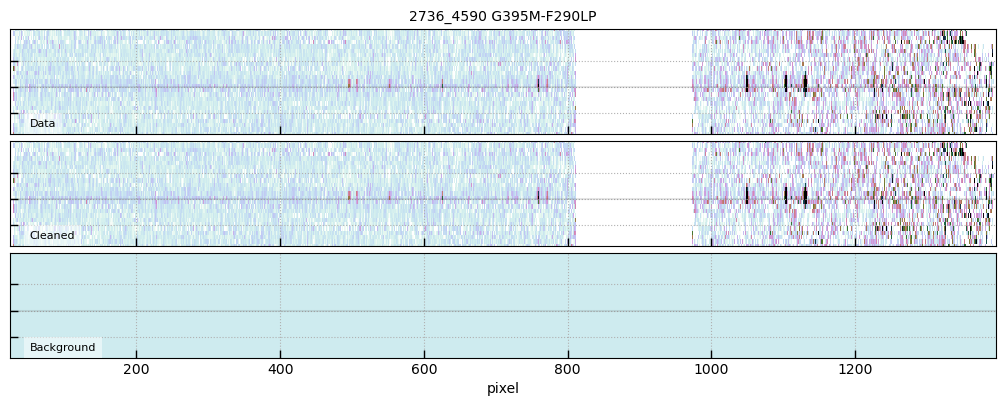

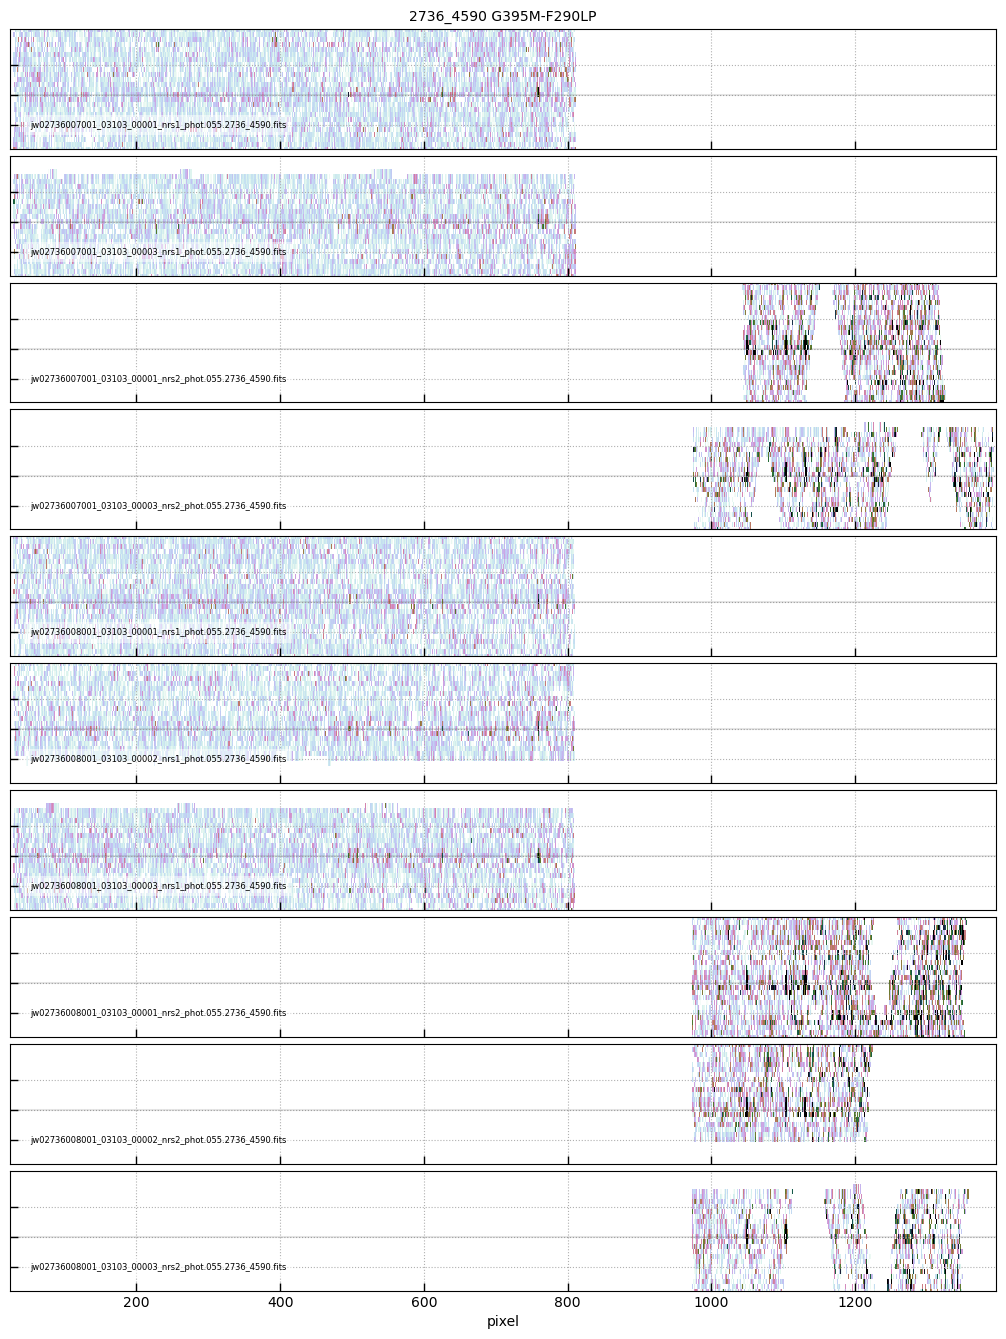

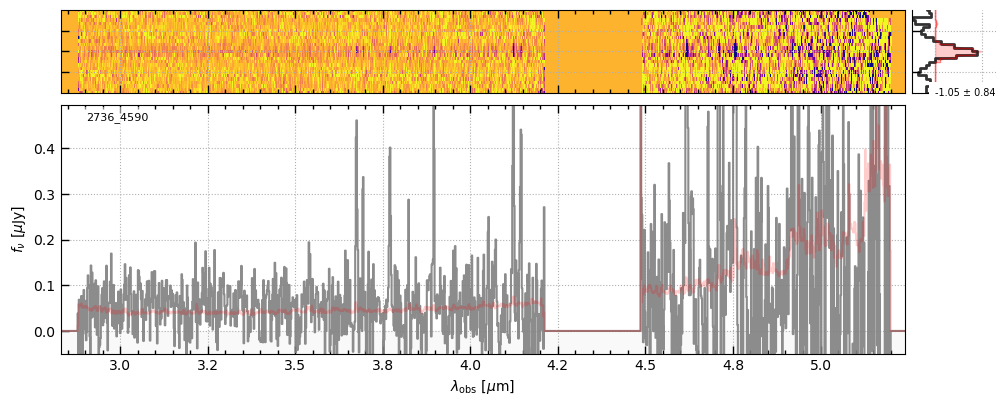

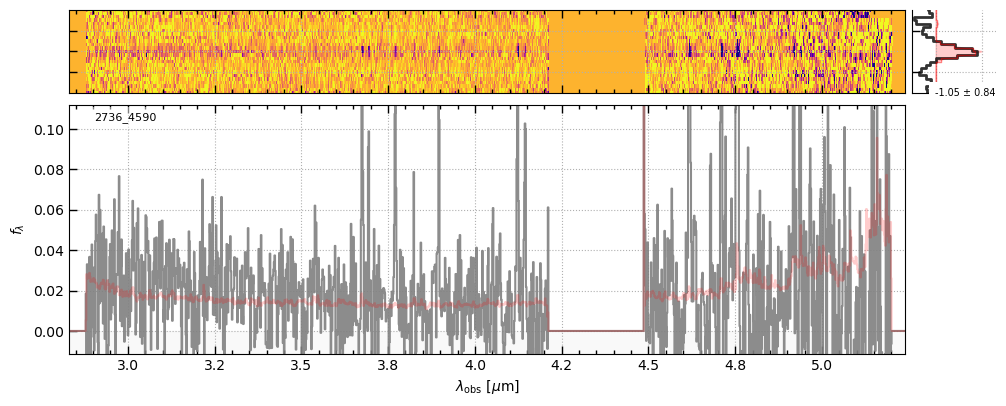

In [18]:
reload(msaexp.utils)
# Drizzle slitlets
from importlib import reload
import copy

import msaexp.drizzle
reload(msaexp.drizzle); reload(msaexp.utils)
reload(msaexp.drizzle); reload(msaexp.utils) 

DRIZZLE_PARAMS = copy.deepcopy(msaexp.drizzle.DRIZZLE_PARAMS)
DRIZZLE_PARAMS['kernel'] = 'square'
DRIZZLE_PARAMS['pixfrac'] = 0.8

target = key

wave_sample = 1.05
wave_arrays = {}

# Don't do background subtraction because it was done above
master_bkg = 0
bkg_parity = []

key = '2736_4590'

hdus = {}
for g in gratings:
    slits = []
    for pipe in gratings[g]:
        _slits = pipe.get_background_slits(key)
        
        # Stuck closed in jw02736007001-01-f290lp-g395m-nrs2 4590??
        if ('jw02736007001-01-f290lp-g395m' in pipe.mode) & (key == '2736_4590'):
            _p = _slits.pop(1)
            
        if _slits is not None:
            print(f'Add {len(_slits)} slitlets from {pipe.mode}')
            slits.extend(_slits)
            
    print(f'{g} total {len(slits)} slitlets')
    
    outroot = f'smacs0723-{g}'

    sn = slits[0].data / slits[0].err
    outlier_threshold = np.clip(np.nanpercentile(sn[slits[0].err > 0], 90)*2, 7, 100)
    print('outlier_threshold: ', outlier_threshold)

    _ = msaexp.drizzle.drizzle_slitlets(target,
                                        output=outroot,
                                        files=slits,
                                        center_on_source=False,  # Center output source as defined in MSA file.  Leave False and can maybe build master bkg
                                        fix_slope=0.2,          # Cross-dispersion scale dslit/dpix
                                        force_nypix=31,         # Y size of output array
                                        bkg_offset=6,           # Number of pixels to roll for background subtraction
                                        bkg_parity=bkg_parity,  # Roll directions for background, i.e., -1 rolls the array down for bkg at top
                                        master_bkg=master_bkg,  # If 0, then assumes background already subtracted in A-B, B-A above
                                        log_step=False,         # Log wavelength steps
                                        outlier_threshold=outlier_threshold,   # Outlier rejection threshold
                                        err_threshold=1000,     # Reject pixels in a slit where err > err_threshold*median(err)
                                        show_drizzled=True,     # Figures
                                        show_slits=True,
                                        imshow_kws=dict(vmin=-0.05, vmax=0.4, aspect='auto', cmap='cubehelix_r'),
                                        sn_threshold=-np.inf,   # Reject pixels where S/N < sn_threshold.  Prism S/N should usually be > 5 with bkg
                                        bar_threshold=0.0,      # Mask pixels where barshadow array less than this value
                                        drizzle_params=DRIZZLE_PARAMS,
                                        wave_sample=wave_sample,
                                        wave_arrays=wave_arrays,
                                        center_phase=-0.5,
                                       )

    figs, hdu_data, wavedata, all_slits, drz_data = _
    
    kws = dict(prf_sigma=0.9, fix_sigma=False,
           prf_center=None, fix_center=False,
           verbose=True,
           sigma_bounds=(0.4, 2.5)
          )

    hdul = hdu_data[list(hdu_data.keys())[0]]

    outhdu = msaexp.drizzle.extract_from_hdul(hdul, **kws)

    outhdu.writeto(f'{outroot}_{target}.{file_version}.spec.fits', overwrite=True)

    # Make figures
    fig = msaexp.utils.drizzled_hdu_figure(outhdu, unit='fnu')
    fig.savefig(f'{outroot}_{target}.{file_version}.fnu.png')

    fig = msaexp.utils.drizzled_hdu_figure(outhdu, unit='flam')
    fig.savefig(f'{outroot}_{target}.{file_version}.flam.png')
    
    hdus[g] = outhdu

In [19]:
# Deprecated drizzle
if False:
    # Drizzle combinations

    reload(msaexp.utils)

    key = '2736_4590'

    hdus = {}
    for g in gratings:
        slits = []
        for pipe in gratings[g]:
            _slits = pipe.get_background_slits(key)

            # Stuck closed in jw02736007001-01-f290lp-g395m-nrs2 4590??
            if ('jw02736007001-01-f290lp-g395m' in pipe.mode) & (key == '2736_4590'):
                _p = _slits.pop(1)

            if _slits is not None:
                print(f'Add {len(_slits)} slitlets from {pipe.mode}')
                slits.extend(_slits)

        print(f'{g} total {len(slits)} slitlets')

        output_root = f'smacs0723-{g}_{key}_v3'

        hdus[g] = msaexp.utils.drizzle_2d_pipeline(slits, drizzle_params=drizzle_params,
                                            #profile_slice=slice(int(200*scale), int(600*scale)),
                                            #profile_slice=slice(int(100*scale), int(700*scale)),
                                                   profile_slice=None,
                                            standard_waves=scale,
                                            outlier_threshold=5,
                                            output_root=output_root,
                                            fit_prf=True, prf_center=-1., prf_sigma=1.19)

In [20]:
print(g)
hdus[g].info()

f290lp-g395m
Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  SPEC1D        1 BinTableHDU    439   1414R x 3C   ['D', 'D', 'D']   
  2  SCI           1 ImageHDU       429   (1414, 31)   float32   
  3  WHT           1 ImageHDU       429   (1414, 31)   float32   
  4  PROFILE       1 ImageHDU       429   (1414, 31)   float64   
  5  PROF1D        1 BinTableHDU     21   31R x 3C   ['D', 'E', 'D']   


Add 2 slitlets from jw02736007001-01-f290lp-g395m-nrs1
007-f290lp-g395m total 2 slitlets
outlier_threshold:  7.0
msaexp.drizzle.drizzle_slitlets: 2736_4590 read 2 files
msaexp.drizzle.drizzle_slitlets: id=2736_4590  g395m-f290lp N=2
msaexp.drizzle.drizzle_slitlets: get wcs from slit 0 =  2736_4590


2023-03-30 17:43:50,570 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:43:50,570 - stpipe - INFO - Driz parameter pixfrac: 1.0
2023-03-30 17:43:50,571 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:43:50,571 - stpipe - INFO - Driz parameter weight_type: ivm
2023-03-30 17:43:50,739 - stpipe - INFO - Blending metadata for None
2023-03-30 17:43:51,817 - stpipe - INFO - Resampling science data
2023-03-30 17:43:51,848 - stpipe - INFO - Drizzling (32, 764) --> (31, 1414)
2023-03-30 17:43:51,855 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:43:51,888 - stpipe - INFO - Drizzling (32, 764) --> (31, 1414)
2023-03-30 17:43:51,896 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:43:51,930 - stpipe - INFO - Drizzling (32, 764) --> (31, 1414)
2023-03-30 17:43:51,938 - stpipe - INFO - Resampling var_flat
2023-03-30 17:43:51,971 - stpipe - INFO - Drizzling (32, 764) --> (31, 1414)
2023-03-30 17:43:52,402 - stpipe - INFO - Driz parameter kernal: square
2023-03-30

msaexp.drizzle.drizzle_slitlets: output size = (31, 1414)
msaexp.drizzle.drizzle_slitlets: g395m-f290lp  0 2736_4590               4590  0.256 <SlitModel(32, 764) from jw02736007001_03103_00001_nrs1_phot.055.2736_4590.fits> (32, 764)


2023-03-30 17:43:53,721 - stpipe - INFO - Blending metadata for None
2023-03-30 17:43:54,283 - stpipe - INFO - Resampling science data
2023-03-30 17:43:54,316 - stpipe - INFO - Drizzling (32, 764) --> (31, 1414)
2023-03-30 17:43:54,321 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:43:54,354 - stpipe - INFO - Drizzling (32, 764) --> (31, 1414)
2023-03-30 17:43:54,360 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:43:54,393 - stpipe - INFO - Drizzling (32, 764) --> (31, 1414)
2023-03-30 17:43:54,400 - stpipe - INFO - Resampling var_flat
2023-03-30 17:43:54,433 - stpipe - INFO - Drizzling (32, 764) --> (31, 1414)
2023-03-30 17:43:54,580 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:43:54,580 - stpipe - INFO - Driz parameter pixfrac: 0.8
2023-03-30 17:43:54,581 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:43:54,581 - stpipe - INFO - Driz parameter weight_type: ivm


msaexp.drizzle.drizzle_slitlets: g395m-f290lp  1 2736_4590               4590  0.253 <SlitModel(32, 764) from jw02736007001_03103_00003_nrs1_phot.055.2736_4590.fits> (32, 764)


2023-03-30 17:43:54,759 - stpipe - INFO - Blending metadata for None
2023-03-30 17:43:55,343 - stpipe - INFO - Resampling science data
2023-03-30 17:43:55,375 - stpipe - INFO - Drizzling (32, 764) --> (31, 1414)
2023-03-30 17:43:55,380 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:43:55,412 - stpipe - INFO - Drizzling (32, 764) --> (31, 1414)
2023-03-30 17:43:55,419 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:43:55,451 - stpipe - INFO - Drizzling (32, 764) --> (31, 1414)
2023-03-30 17:43:55,458 - stpipe - INFO - Resampling var_flat
2023-03-30 17:43:55,490 - stpipe - INFO - Drizzling (32, 764) --> (31, 1414)
2023-03-30 17:43:55,524 - stpipe - WARNING - VerifyWarning: Card is too long, comment will be truncated.


msaexp.drizzle.extract_from_hdul: Initial center =   -1.25, sigma =   0.90
msaexp.drizzle.extract_from_hdul:  Output center =  -1.06, sigma =   0.80
Add 2 slitlets from jw02736007001-01-f290lp-g395m-nrs2
007-f290lp-g395m total 4 slitlets
outlier_threshold:  7.0
msaexp.drizzle.drizzle_slitlets: 2736_4590 read 4 files
msaexp.drizzle.drizzle_slitlets: id=2736_4590  g395m-f290lp N=4
msaexp.drizzle.drizzle_slitlets: get wcs from slit 0 =  2736_4590


2023-03-30 17:43:56,761 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:43:56,761 - stpipe - INFO - Driz parameter pixfrac: 1.0
2023-03-30 17:43:56,762 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:43:56,762 - stpipe - INFO - Driz parameter weight_type: ivm
2023-03-30 17:43:56,934 - stpipe - INFO - Blending metadata for None
2023-03-30 17:43:57,511 - stpipe - INFO - Resampling science data
2023-03-30 17:43:57,545 - stpipe - INFO - Drizzling (32, 764) --> (31, 1414)
2023-03-30 17:43:57,552 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:43:57,585 - stpipe - INFO - Drizzling (32, 764) --> (31, 1414)
2023-03-30 17:43:57,594 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:43:57,628 - stpipe - INFO - Drizzling (32, 764) --> (31, 1414)
2023-03-30 17:43:57,636 - stpipe - INFO - Resampling var_flat
2023-03-30 17:43:57,671 - stpipe - INFO - Drizzling (32, 764) --> (31, 1414)
2023-03-30 17:43:58,092 - stpipe - INFO - Driz parameter kernal: square
2023-03-30

msaexp.drizzle.drizzle_slitlets: output size = (31, 1414)
msaexp.drizzle.drizzle_slitlets: g395m-f290lp  0 2736_4590               4590  0.256 <SlitModel(32, 764) from jw02736007001_03103_00001_nrs1_phot.055.2736_4590.fits> (32, 764)


2023-03-30 17:43:59,399 - stpipe - INFO - Blending metadata for None
2023-03-30 17:43:59,969 - stpipe - INFO - Resampling science data
2023-03-30 17:44:00,000 - stpipe - INFO - Drizzling (32, 764) --> (31, 1414)
2023-03-30 17:44:00,006 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:44:00,040 - stpipe - INFO - Drizzling (32, 764) --> (31, 1414)
2023-03-30 17:44:00,047 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:44:00,080 - stpipe - INFO - Drizzling (32, 764) --> (31, 1414)
2023-03-30 17:44:00,086 - stpipe - INFO - Resampling var_flat
2023-03-30 17:44:00,120 - stpipe - INFO - Drizzling (32, 764) --> (31, 1414)
2023-03-30 17:44:00,269 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:44:00,270 - stpipe - INFO - Driz parameter pixfrac: 0.8
2023-03-30 17:44:00,270 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:44:00,270 - stpipe - INFO - Driz parameter weight_type: ivm


msaexp.drizzle.drizzle_slitlets: g395m-f290lp  1 2736_4590               4590  0.253 <SlitModel(32, 764) from jw02736007001_03103_00003_nrs1_phot.055.2736_4590.fits> (32, 764)


2023-03-30 17:44:00,437 - stpipe - INFO - Blending metadata for None
2023-03-30 17:44:00,978 - stpipe - INFO - Resampling science data
2023-03-30 17:44:01,010 - stpipe - INFO - Drizzling (32, 764) --> (31, 1414)
2023-03-30 17:44:01,015 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:44:01,047 - stpipe - INFO - Drizzling (32, 764) --> (31, 1414)
2023-03-30 17:44:01,053 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:44:01,085 - stpipe - INFO - Drizzling (32, 764) --> (31, 1414)
2023-03-30 17:44:01,091 - stpipe - INFO - Resampling var_flat
2023-03-30 17:44:01,121 - stpipe - INFO - Drizzling (32, 764) --> (31, 1414)
2023-03-30 17:44:01,251 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:44:01,252 - stpipe - INFO - Driz parameter pixfrac: 0.8
2023-03-30 17:44:01,252 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:44:01,252 - stpipe - INFO - Driz parameter weight_type: ivm


msaexp.drizzle.drizzle_slitlets: g395m-f290lp  2 2736_4590               4590  0.256 <SlitModel(30, 450) from jw02736007001_03103_00001_nrs2_phot.055.2736_4590.fits> (30, 450)


2023-03-30 17:44:01,417 - stpipe - INFO - Blending metadata for None
2023-03-30 17:44:02,417 - stpipe - INFO - Resampling science data
2023-03-30 17:44:02,444 - stpipe - INFO - Drizzling (30, 450) --> (31, 1414)
2023-03-30 17:44:02,446 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:44:02,472 - stpipe - INFO - Drizzling (30, 450) --> (31, 1414)
2023-03-30 17:44:02,476 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:44:02,503 - stpipe - INFO - Drizzling (30, 450) --> (31, 1414)
2023-03-30 17:44:02,507 - stpipe - INFO - Resampling var_flat
2023-03-30 17:44:02,534 - stpipe - INFO - Drizzling (30, 450) --> (31, 1414)
2023-03-30 17:44:02,662 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:44:02,662 - stpipe - INFO - Driz parameter pixfrac: 0.8
2023-03-30 17:44:02,663 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:44:02,663 - stpipe - INFO - Driz parameter weight_type: ivm


msaexp.drizzle.drizzle_slitlets: g395m-f290lp  3 2736_4590               4590  0.253 <SlitModel(30, 450) from jw02736007001_03103_00003_nrs2_phot.055.2736_4590.fits> (30, 450)


2023-03-30 17:44:02,830 - stpipe - INFO - Blending metadata for None
2023-03-30 17:44:03,378 - stpipe - INFO - Resampling science data
2023-03-30 17:44:03,404 - stpipe - INFO - Drizzling (30, 450) --> (31, 1414)
2023-03-30 17:44:03,407 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:44:03,435 - stpipe - INFO - Drizzling (30, 450) --> (31, 1414)
2023-03-30 17:44:03,439 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:44:03,467 - stpipe - INFO - Drizzling (30, 450) --> (31, 1414)
2023-03-30 17:44:03,471 - stpipe - INFO - Resampling var_flat
2023-03-30 17:44:03,497 - stpipe - INFO - Drizzling (30, 450) --> (31, 1414)
2023-03-30 17:44:03,533 - stpipe - WARNING - VerifyWarning: Card is too long, comment will be truncated.


msaexp.drizzle.extract_from_hdul: Initial center =   -1.25, sigma =   0.90
msaexp.drizzle.extract_from_hdul:  Output center =  -1.06, sigma =   0.85
Add 3 slitlets from jw02736008001-01-f290lp-g395m-nrs1
008-f290lp-g395m total 3 slitlets
outlier_threshold:  7.0
msaexp.drizzle.drizzle_slitlets: 2736_4590 read 3 files
msaexp.drizzle.drizzle_slitlets: id=2736_4590  g395m-f290lp N=3
msaexp.drizzle.drizzle_slitlets: get wcs from slit 0 =  2736_4590


2023-03-30 17:44:04,300 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:44:04,301 - stpipe - INFO - Driz parameter pixfrac: 1.0
2023-03-30 17:44:04,301 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:44:04,301 - stpipe - INFO - Driz parameter weight_type: ivm
2023-03-30 17:44:04,465 - stpipe - INFO - Blending metadata for None
2023-03-30 17:44:05,007 - stpipe - INFO - Resampling science data
2023-03-30 17:44:05,038 - stpipe - INFO - Drizzling (32, 763) --> (31, 1414)
2023-03-30 17:44:05,045 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:44:05,078 - stpipe - INFO - Drizzling (32, 763) --> (31, 1414)
2023-03-30 17:44:05,085 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:44:05,120 - stpipe - INFO - Drizzling (32, 763) --> (31, 1414)
2023-03-30 17:44:05,128 - stpipe - INFO - Resampling var_flat
2023-03-30 17:44:05,163 - stpipe - INFO - Drizzling (32, 763) --> (31, 1414)
2023-03-30 17:44:05,583 - stpipe - INFO - Driz parameter kernal: square
2023-03-30

msaexp.drizzle.drizzle_slitlets: output size = (31, 1414)
msaexp.drizzle.drizzle_slitlets: g395m-f290lp  0 2736_4590               4590  0.256 <SlitModel(32, 763) from jw02736008001_03103_00001_nrs1_phot.055.2736_4590.fits> (32, 763)


2023-03-30 17:44:07,302 - stpipe - INFO - Blending metadata for None
2023-03-30 17:44:07,848 - stpipe - INFO - Resampling science data
2023-03-30 17:44:07,881 - stpipe - INFO - Drizzling (32, 763) --> (31, 1414)
2023-03-30 17:44:07,887 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:44:07,920 - stpipe - INFO - Drizzling (32, 763) --> (31, 1414)
2023-03-30 17:44:07,926 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:44:07,956 - stpipe - INFO - Drizzling (32, 763) --> (31, 1414)
2023-03-30 17:44:07,962 - stpipe - INFO - Resampling var_flat
2023-03-30 17:44:07,993 - stpipe - INFO - Drizzling (32, 763) --> (31, 1414)
2023-03-30 17:44:08,136 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:44:08,136 - stpipe - INFO - Driz parameter pixfrac: 0.8
2023-03-30 17:44:08,137 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:44:08,137 - stpipe - INFO - Driz parameter weight_type: ivm


msaexp.drizzle.drizzle_slitlets: g395m-f290lp  1 2736_4590               4590  0.260 <SlitModel(32, 763) from jw02736008001_03103_00002_nrs1_phot.055.2736_4590.fits> (32, 763)


2023-03-30 17:44:08,304 - stpipe - INFO - Blending metadata for None
2023-03-30 17:44:08,847 - stpipe - INFO - Resampling science data
2023-03-30 17:44:08,879 - stpipe - INFO - Drizzling (32, 763) --> (31, 1414)
2023-03-30 17:44:08,883 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:44:08,917 - stpipe - INFO - Drizzling (32, 763) --> (31, 1414)
2023-03-30 17:44:08,922 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:44:08,954 - stpipe - INFO - Drizzling (32, 763) --> (31, 1414)
2023-03-30 17:44:08,959 - stpipe - INFO - Resampling var_flat
2023-03-30 17:44:08,991 - stpipe - INFO - Drizzling (32, 763) --> (31, 1414)
2023-03-30 17:44:09,133 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:44:09,134 - stpipe - INFO - Driz parameter pixfrac: 0.8
2023-03-30 17:44:09,134 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:44:09,134 - stpipe - INFO - Driz parameter weight_type: ivm


msaexp.drizzle.drizzle_slitlets: g395m-f290lp  2 2736_4590               4590  0.253 <SlitModel(32, 763) from jw02736008001_03103_00003_nrs1_phot.055.2736_4590.fits> (32, 763)


2023-03-30 17:44:09,302 - stpipe - INFO - Blending metadata for None
2023-03-30 17:44:09,844 - stpipe - INFO - Resampling science data
2023-03-30 17:44:09,876 - stpipe - INFO - Drizzling (32, 763) --> (31, 1414)
2023-03-30 17:44:09,881 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:44:09,914 - stpipe - INFO - Drizzling (32, 763) --> (31, 1414)
2023-03-30 17:44:09,920 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:44:09,952 - stpipe - INFO - Drizzling (32, 763) --> (31, 1414)
2023-03-30 17:44:09,958 - stpipe - INFO - Resampling var_flat
2023-03-30 17:44:09,989 - stpipe - INFO - Drizzling (32, 763) --> (31, 1414)
2023-03-30 17:44:10,027 - stpipe - WARNING - VerifyWarning: Card is too long, comment will be truncated.


msaexp.drizzle.extract_from_hdul: Initial center =   -1.25, sigma =   0.90
msaexp.drizzle.extract_from_hdul:  Output center =  -1.05, sigma =   0.87
Add 3 slitlets from jw02736008001-01-f290lp-g395m-nrs2
008-f290lp-g395m total 6 slitlets
outlier_threshold:  7.0
msaexp.drizzle.drizzle_slitlets: 2736_4590 read 6 files
msaexp.drizzle.drizzle_slitlets: id=2736_4590  g395m-f290lp N=6
msaexp.drizzle.drizzle_slitlets: get wcs from slit 0 =  2736_4590


2023-03-30 17:44:10,764 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:44:10,765 - stpipe - INFO - Driz parameter pixfrac: 1.0
2023-03-30 17:44:10,765 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:44:10,765 - stpipe - INFO - Driz parameter weight_type: ivm
2023-03-30 17:44:10,929 - stpipe - INFO - Blending metadata for None
2023-03-30 17:44:11,468 - stpipe - INFO - Resampling science data
2023-03-30 17:44:11,983 - stpipe - INFO - Drizzling (32, 763) --> (31, 1414)
2023-03-30 17:44:11,990 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:44:12,021 - stpipe - INFO - Drizzling (32, 763) --> (31, 1414)
2023-03-30 17:44:12,029 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:44:12,061 - stpipe - INFO - Drizzling (32, 763) --> (31, 1414)
2023-03-30 17:44:12,069 - stpipe - INFO - Resampling var_flat
2023-03-30 17:44:12,100 - stpipe - INFO - Drizzling (32, 763) --> (31, 1414)
2023-03-30 17:44:12,518 - stpipe - INFO - Driz parameter kernal: square
2023-03-30

msaexp.drizzle.drizzle_slitlets: output size = (31, 1414)
msaexp.drizzle.drizzle_slitlets: g395m-f290lp  0 2736_4590               4590  0.256 <SlitModel(32, 763) from jw02736008001_03103_00001_nrs1_phot.055.2736_4590.fits> (32, 763)


2023-03-30 17:44:13,775 - stpipe - INFO - Blending metadata for None
2023-03-30 17:44:14,319 - stpipe - INFO - Resampling science data
2023-03-30 17:44:14,352 - stpipe - INFO - Drizzling (32, 763) --> (31, 1414)
2023-03-30 17:44:14,358 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:44:14,392 - stpipe - INFO - Drizzling (32, 763) --> (31, 1414)
2023-03-30 17:44:14,399 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:44:14,432 - stpipe - INFO - Drizzling (32, 763) --> (31, 1414)
2023-03-30 17:44:14,438 - stpipe - INFO - Resampling var_flat
2023-03-30 17:44:14,471 - stpipe - INFO - Drizzling (32, 763) --> (31, 1414)
2023-03-30 17:44:14,618 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:44:14,619 - stpipe - INFO - Driz parameter pixfrac: 0.8
2023-03-30 17:44:14,619 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:44:14,619 - stpipe - INFO - Driz parameter weight_type: ivm


msaexp.drizzle.drizzle_slitlets: g395m-f290lp  1 2736_4590               4590  0.260 <SlitModel(32, 763) from jw02736008001_03103_00002_nrs1_phot.055.2736_4590.fits> (32, 763)


2023-03-30 17:44:14,788 - stpipe - INFO - Blending metadata for None
2023-03-30 17:44:15,333 - stpipe - INFO - Resampling science data
2023-03-30 17:44:15,368 - stpipe - INFO - Drizzling (32, 763) --> (31, 1414)
2023-03-30 17:44:15,372 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:44:15,406 - stpipe - INFO - Drizzling (32, 763) --> (31, 1414)
2023-03-30 17:44:15,412 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:44:15,446 - stpipe - INFO - Drizzling (32, 763) --> (31, 1414)
2023-03-30 17:44:15,452 - stpipe - INFO - Resampling var_flat
2023-03-30 17:44:15,486 - stpipe - INFO - Drizzling (32, 763) --> (31, 1414)
2023-03-30 17:44:15,634 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:44:15,634 - stpipe - INFO - Driz parameter pixfrac: 0.8
2023-03-30 17:44:15,635 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:44:15,635 - stpipe - INFO - Driz parameter weight_type: ivm


msaexp.drizzle.drizzle_slitlets: g395m-f290lp  2 2736_4590               4590  0.253 <SlitModel(32, 763) from jw02736008001_03103_00003_nrs1_phot.055.2736_4590.fits> (32, 763)


2023-03-30 17:44:15,803 - stpipe - INFO - Blending metadata for None
2023-03-30 17:44:16,347 - stpipe - INFO - Resampling science data
2023-03-30 17:44:16,379 - stpipe - INFO - Drizzling (32, 763) --> (31, 1414)
2023-03-30 17:44:16,384 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:44:16,417 - stpipe - INFO - Drizzling (32, 763) --> (31, 1414)
2023-03-30 17:44:16,423 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:44:16,456 - stpipe - INFO - Drizzling (32, 763) --> (31, 1414)
2023-03-30 17:44:16,462 - stpipe - INFO - Resampling var_flat
2023-03-30 17:44:16,495 - stpipe - INFO - Drizzling (32, 763) --> (31, 1414)
2023-03-30 17:44:16,625 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:44:16,626 - stpipe - INFO - Driz parameter pixfrac: 0.8
2023-03-30 17:44:16,626 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:44:16,626 - stpipe - INFO - Driz parameter weight_type: ivm


msaexp.drizzle.drizzle_slitlets: g395m-f290lp  3 2736_4590               4590  0.256 <SlitModel(30, 451) from jw02736008001_03103_00001_nrs2_phot.055.2736_4590.fits> (30, 451)


2023-03-30 17:44:16,793 - stpipe - INFO - Blending metadata for None
2023-03-30 17:44:17,844 - stpipe - INFO - Resampling science data
2023-03-30 17:44:17,873 - stpipe - INFO - Drizzling (30, 451) --> (31, 1414)
2023-03-30 17:44:17,875 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:44:17,905 - stpipe - INFO - Drizzling (30, 451) --> (31, 1414)
2023-03-30 17:44:17,909 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:44:17,937 - stpipe - INFO - Drizzling (30, 451) --> (31, 1414)
2023-03-30 17:44:17,942 - stpipe - INFO - Resampling var_flat
2023-03-30 17:44:17,972 - stpipe - INFO - Drizzling (30, 451) --> (31, 1414)
2023-03-30 17:44:18,106 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:44:18,107 - stpipe - INFO - Driz parameter pixfrac: 0.8
2023-03-30 17:44:18,107 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:44:18,107 - stpipe - INFO - Driz parameter weight_type: ivm


msaexp.drizzle.drizzle_slitlets: g395m-f290lp  4 2736_4590               4590  0.260 <SlitModel(30, 451) from jw02736008001_03103_00002_nrs2_phot.055.2736_4590.fits> (30, 451)


2023-03-30 17:44:18,284 - stpipe - INFO - Blending metadata for None
2023-03-30 17:44:18,836 - stpipe - INFO - Resampling science data
2023-03-30 17:44:18,864 - stpipe - INFO - Drizzling (30, 451) --> (31, 1414)
2023-03-30 17:44:18,866 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:44:18,895 - stpipe - INFO - Drizzling (30, 451) --> (31, 1414)
2023-03-30 17:44:18,899 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:44:18,928 - stpipe - INFO - Drizzling (30, 451) --> (31, 1414)
2023-03-30 17:44:18,932 - stpipe - INFO - Resampling var_flat
2023-03-30 17:44:18,966 - stpipe - INFO - Drizzling (30, 451) --> (31, 1414)
2023-03-30 17:44:19,106 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:44:19,107 - stpipe - INFO - Driz parameter pixfrac: 0.8
2023-03-30 17:44:19,107 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:44:19,107 - stpipe - INFO - Driz parameter weight_type: ivm


msaexp.drizzle.drizzle_slitlets: g395m-f290lp  5 2736_4590               4590  0.253 <SlitModel(30, 451) from jw02736008001_03103_00003_nrs2_phot.055.2736_4590.fits> (30, 451)


2023-03-30 17:44:19,280 - stpipe - INFO - Blending metadata for None
2023-03-30 17:44:19,831 - stpipe - INFO - Resampling science data
2023-03-30 17:44:19,858 - stpipe - INFO - Drizzling (30, 451) --> (31, 1414)
2023-03-30 17:44:19,860 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:44:19,889 - stpipe - INFO - Drizzling (30, 451) --> (31, 1414)
2023-03-30 17:44:19,895 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:44:19,924 - stpipe - INFO - Drizzling (30, 451) --> (31, 1414)
2023-03-30 17:44:19,928 - stpipe - INFO - Resampling var_flat
2023-03-30 17:44:19,955 - stpipe - INFO - Drizzling (30, 451) --> (31, 1414)
2023-03-30 17:44:20,001 - stpipe - WARNING - VerifyWarning: Card is too long, comment will be truncated.


msaexp.drizzle.extract_from_hdul: Initial center =   -1.25, sigma =   0.90
msaexp.drizzle.extract_from_hdul:  Output center =  -1.07, sigma =   0.88


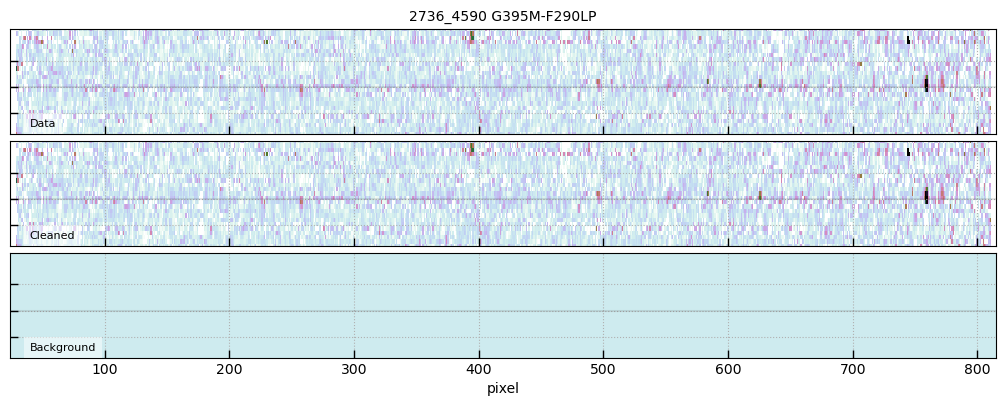

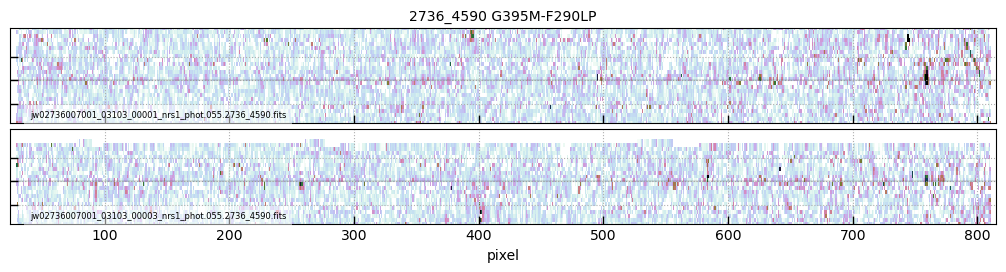

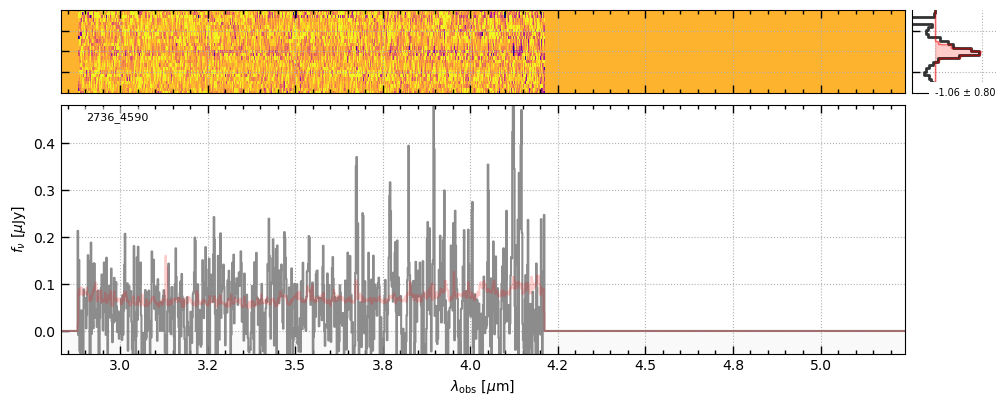

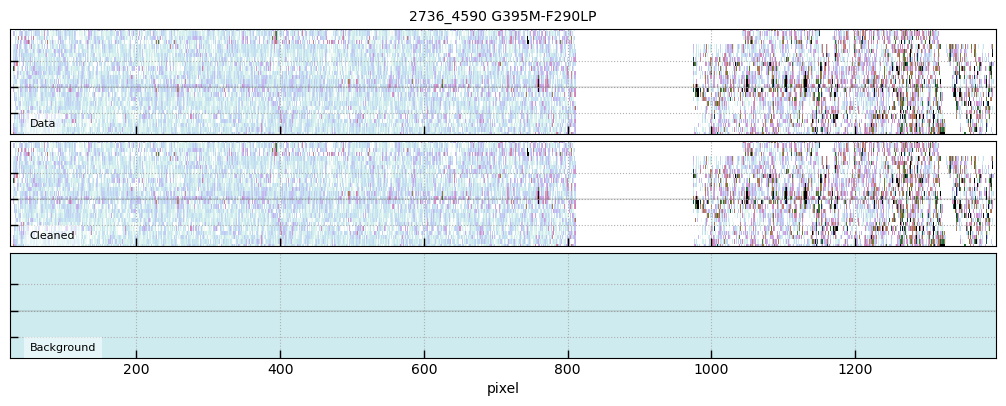

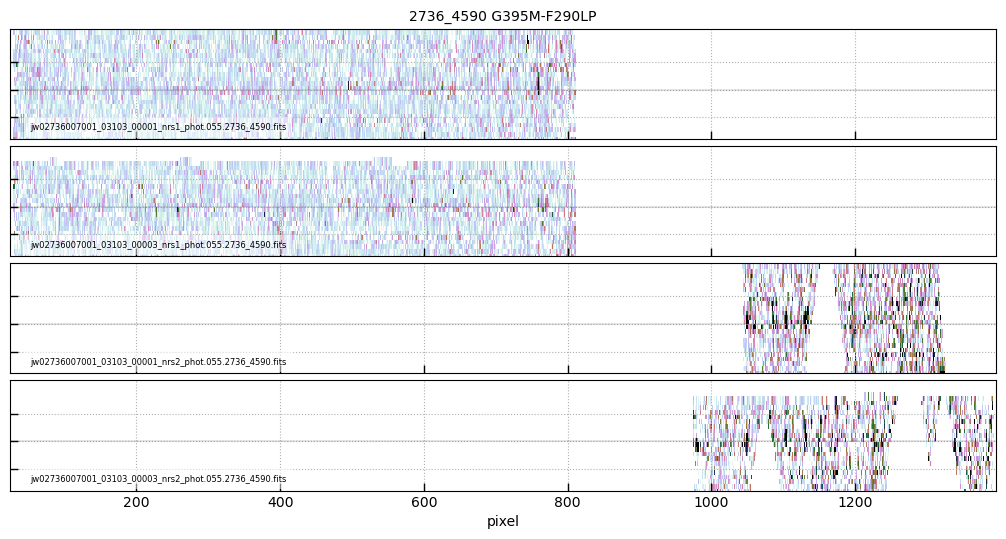

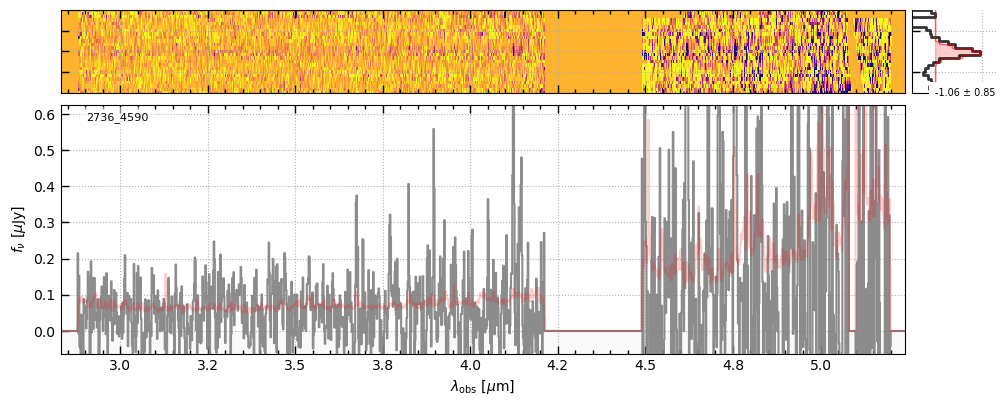

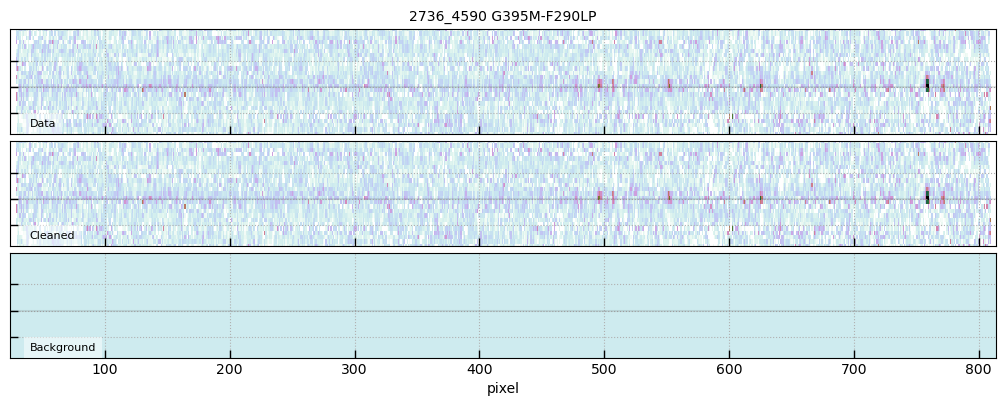

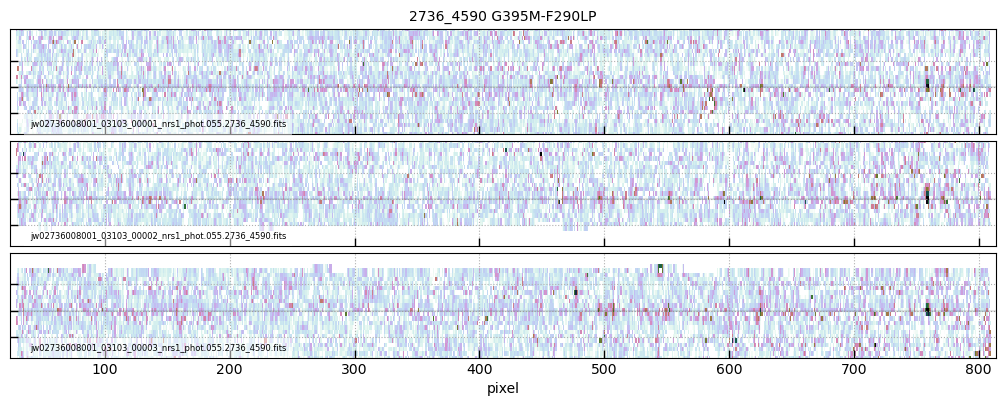

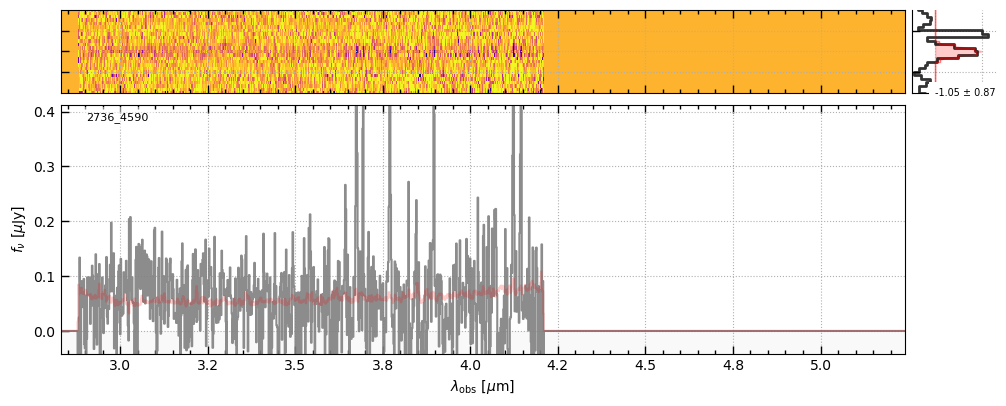

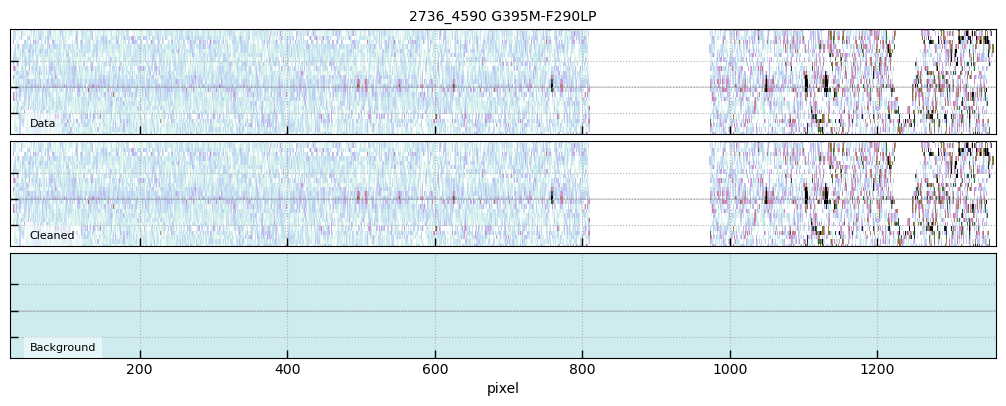

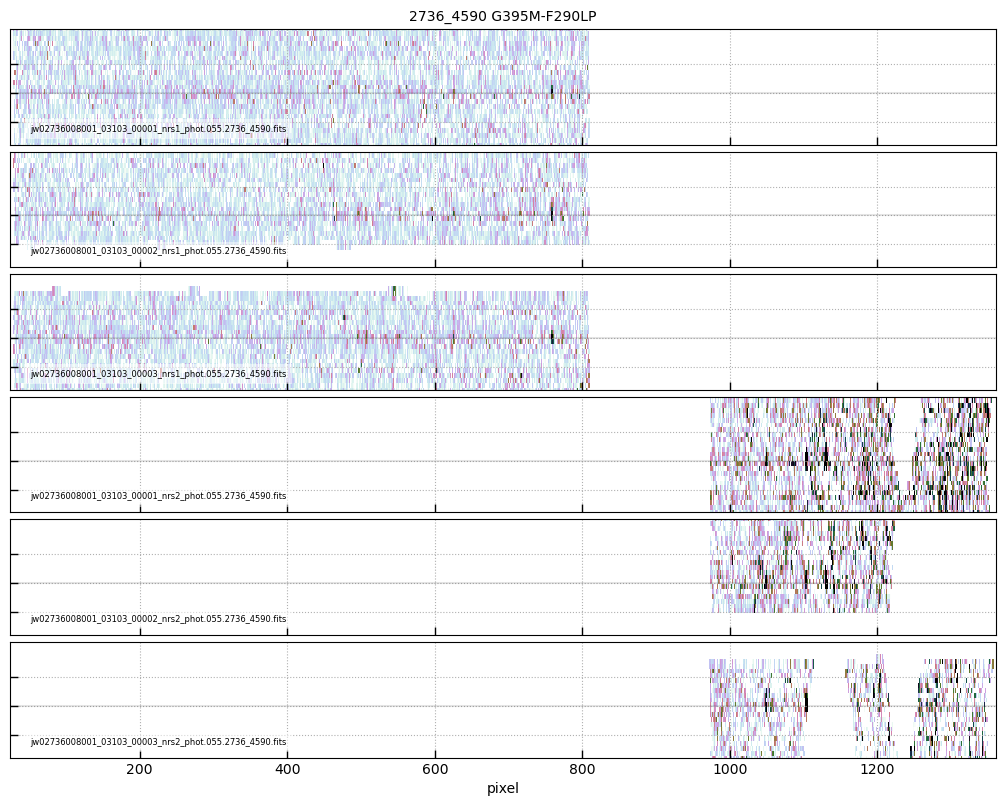

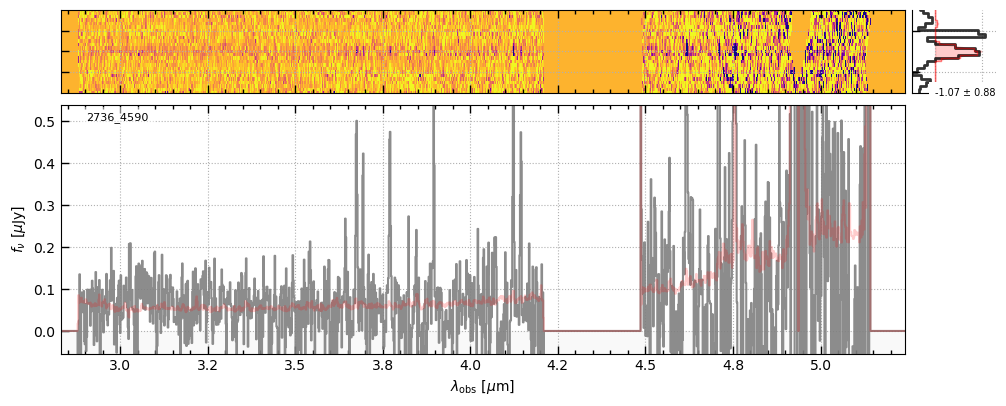

In [21]:
# Drizzle the two visits separately
reload(msaexp.utils)

key = '2736_4590'

ehdus = {}

for exp in ['007','008']:
    for g in gratings:
        slits = []
        for pipe in gratings[g]:
            if f'2736{exp}' not in pipe.mode:
                continue

            _slits = pipe.get_background_slits(key)
            # Stuck closed in jw02736007001-01-f290lp-g395m-nrs2 4590??
            if ('jw02736007001-01-f290lp-g395m' in pipe.mode) & (key == '2736_4590'):
                _p = _slits.pop(1)

            
            if _slits is not None:
                print(f'Add {len(_slits)} slitlets from {pipe.mode}')
                slits.extend(_slits)
                
            print(f'{exp}-{g} total {len(slits)} slitlets')

            outroot = f'smacs0723-{exp}-{g}'

            sn = slits[0].data / slits[0].err
            outlier_threshold = np.clip(np.nanpercentile(sn[slits[0].err > 0], 90)*2, 7, 100)
            print('outlier_threshold: ', outlier_threshold)

            _ = msaexp.drizzle.drizzle_slitlets(target,
                                                output=outroot,
                                                files=slits,
                                                center_on_source=False,  # Center output source as defined in MSA file.  Leave False and can maybe build master bkg
                                                fix_slope=0.2,          # Cross-dispersion scale dslit/dpix
                                                force_nypix=31,         # Y size of output array
                                                bkg_offset=6,           # Number of pixels to roll for background subtraction
                                                bkg_parity=bkg_parity,  # Roll directions for background, i.e., -1 rolls the array down for bkg at top
                                                master_bkg=master_bkg,  # If 0, then assumes background already subtracted in A-B, B-A above
                                                log_step=False,         # Log wavelength steps
                                                outlier_threshold=outlier_threshold,   # Outlier rejection threshold
                                                err_threshold=1000,     # Reject pixels in a slit where err > err_threshold*median(err)
                                                show_drizzled=True,     # Figures
                                                show_slits=True,
                                                imshow_kws=dict(vmin=-0.05, vmax=0.4, aspect='auto', cmap='cubehelix_r'),
                                                sn_threshold=-np.inf,   # Reject pixels where S/N < sn_threshold.  Prism S/N should usually be > 5 with bkg
                                                bar_threshold=0.0,      # Mask pixels where barshadow array less than this value
                                                drizzle_params=DRIZZLE_PARAMS,
                                                wave_sample=wave_sample,
                                                wave_arrays=wave_arrays,
                                                center_phase=-0.5,
                                               )

            figs, hdu_data, wavedata, all_slits, drz_data = _

            kws = dict(prf_sigma=0.9, fix_sigma=False,
                   prf_center=None, fix_center=False,
                   verbose=True,
                   sigma_bounds=(0.4, 2.5)
                  )

            hdul = hdu_data[list(hdu_data.keys())[0]]

            outhdu = msaexp.drizzle.extract_from_hdul(hdul, **kws)

            # Make figures
            fig = msaexp.utils.drizzled_hdu_figure(outhdu, unit='fnu')
            # fig.savefig(f'{outroot}_{target}.{file_version}.fnu.png')
            ehdus[outroot] = outhdu

(-0.2, 2.0)

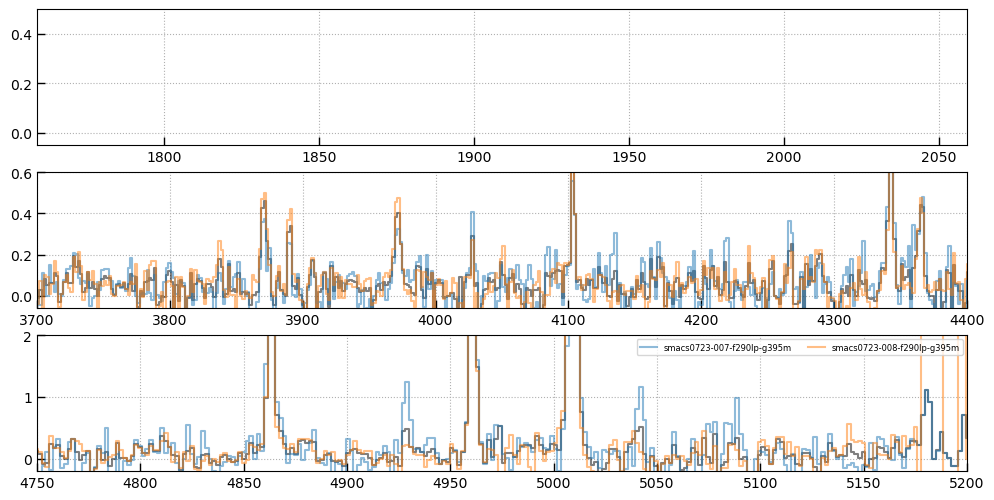

In [22]:
# Compare separate visits
import grizli.utils
fig, axes = plt.subplots(3,1,figsize=(12,6))

for ax in axes:
    for k in hdus:
        sp = grizli.utils.GTable(hdus[k]['SPEC1D'].data)
        ax.step(sp['wave']*1.e4/(1+8.494), sp['flux'], where='mid', alpha=0.5, color='k')

    for k in ehdus:
        sp = grizli.utils.GTable(ehdus[k]['SPEC1D'].data)
        ax.step(sp['wave']*1.e4/(1+8.494), sp['flux'], where='mid', alpha=0.5, label=k)

    ax.grid()

ax.legend(ncol=2, fontsize=6)

ax = axes[0]; ax.set_xlim(1909-150, 1909+150); ax.set_ylim(-0.05,0.5)
ax = axes[1]; ax.set_xlim(3700, 4400); ax.set_ylim(-0.03*2,0.3*2)
ax = axes[2]; ax.set_xlim(4750, 5200); ax.set_ylim(-0.1*2,1*2)


# Show more targets

In [23]:
def extract_target(key):
    """
    two steps of drizzling 2D and then 1D extractions
    """
    
    target = key

    wave_sample = 1.05
    wave_arrays = {}

    # Don't do background subtraction because it was done above
    master_bkg = 0
    bkg_parity = []

    hdus = {}

    for g in gratings:
        slits = []
        for pipe in gratings[g]:
            _slits = pipe.get_background_slits(key)

            # Stuck closed in jw02736007001-01-f290lp-g395m-nrs2 4590??
            if ('jw02736007001-01-f290lp-g395m' in pipe.mode) & (key == '2736_4590'):
                _p = _slits.pop(1)

            if _slits is not None:
                print(f'Add {len(_slits)} slitlets from {pipe.mode}')
                slits.extend(_slits)

        print(f'{g} total {len(slits)} slitlets')

        outroot = f'smacs0723-{g}'

        sn = slits[0].data / slits[0].err
        outlier_threshold = np.clip(np.nanpercentile(sn[slits[0].err > 0], 90)*2, 7, 100)
        print('outlier_threshold: ', outlier_threshold)

        _ = msaexp.drizzle.drizzle_slitlets(target,
                                            output=outroot,
                                            files=slits,
                                            center_on_source=False,  # Center output source as defined in MSA file.  Leave False and can maybe build master bkg
                                            fix_slope=0.2,          # Cross-dispersion scale dslit/dpix
                                            force_nypix=31,         # Y size of output array
                                            bkg_offset=6,           # Number of pixels to roll for background subtraction
                                            bkg_parity=bkg_parity,  # Roll directions for background, i.e., -1 rolls the array down for bkg at top
                                            master_bkg=master_bkg,  # If 0, then assumes background already subtracted in A-B, B-A above
                                            log_step=False,         # Log wavelength steps
                                            outlier_threshold=outlier_threshold,   # Outlier rejection threshold
                                            err_threshold=1000,     # Reject pixels in a slit where err > err_threshold*median(err)
                                            show_drizzled=True,     # Figures
                                            show_slits=True,
                                            imshow_kws=dict(vmin=-0.05, vmax=0.4, aspect='auto', cmap='cubehelix_r'),
                                            sn_threshold=-np.inf,   # Reject pixels where S/N < sn_threshold.  Prism S/N should usually be > 5 with bkg
                                            bar_threshold=0.0,      # Mask pixels where barshadow array less than this value
                                            drizzle_params=DRIZZLE_PARAMS,
                                            wave_sample=wave_sample,
                                            wave_arrays=wave_arrays,
                                            center_phase=-0.5,
                                           )

        figs, hdu_data, wavedata, all_slits, drz_data = _

        kws = dict(prf_sigma=0.9, fix_sigma=False,
               prf_center=None, fix_center=False,
               verbose=True,
               sigma_bounds=(0.4, 2.5)
              )

        hdul = hdu_data[list(hdu_data.keys())[0]]

        outhdu = msaexp.drizzle.extract_from_hdul(hdul, **kws)
                
        outhdu.writeto(f'{outroot}_{target}.{file_version}.spec.fits', overwrite=True)

        gkey = f'{outroot}_{target}.{file_version}'
        hdus[gkey] = outhdu
    
    return hdus

Add 3 slitlets from jw02736007001-01-f290lp-g395m-nrs1
Add 3 slitlets from jw02736007001-01-f290lp-g395m-nrs2
Add 3 slitlets from jw02736008001-01-f290lp-g395m-nrs1
Add 3 slitlets from jw02736008001-01-f290lp-g395m-nrs2
f290lp-g395m total 12 slitlets
outlier_threshold:  7.0
msaexp.drizzle.drizzle_slitlets: 2736_6355 read 12 files
msaexp.drizzle.drizzle_slitlets: id=2736_6355  g395m-f290lp N=12
msaexp.drizzle.drizzle_slitlets: get wcs from slit 0 =  2736_6355


2023-03-30 17:44:23,085 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:44:23,085 - stpipe - INFO - Driz parameter pixfrac: 1.0
2023-03-30 17:44:23,086 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:44:23,086 - stpipe - INFO - Driz parameter weight_type: ivm
2023-03-30 17:44:23,250 - stpipe - INFO - Blending metadata for None
2023-03-30 17:44:23,790 - stpipe - INFO - Resampling science data
2023-03-30 17:44:23,847 - stpipe - INFO - Drizzling (45, 1034) --> (31, 1414)
2023-03-30 17:44:23,856 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:44:23,915 - stpipe - INFO - Drizzling (45, 1034) --> (31, 1414)
2023-03-30 17:44:23,925 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:44:23,971 - stpipe - INFO - Drizzling (45, 1034) --> (31, 1414)
2023-03-30 17:44:23,982 - stpipe - INFO - Resampling var_flat
2023-03-30 17:44:24,025 - stpipe - INFO - Drizzling (45, 1034) --> (31, 1414)
2023-03-30 17:44:25,121 - stpipe - INFO - Driz parameter kernal: square
2023-0

msaexp.drizzle.drizzle_slitlets: output size = (31, 1414)
msaexp.drizzle.drizzle_slitlets: g395m-f290lp  0 2736_6355               6355  0.366 <SlitModel(45, 1034) from jw02736007001_03103_00001_nrs1_phot.072.2736_6355.fits> (45, 1034)


2023-03-30 17:44:26,544 - stpipe - INFO - Blending metadata for None
2023-03-30 17:44:27,098 - stpipe - INFO - Resampling science data
2023-03-30 17:44:27,151 - stpipe - INFO - Drizzling (45, 1034) --> (31, 1414)
2023-03-30 17:44:27,159 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:44:27,207 - stpipe - INFO - Drizzling (45, 1034) --> (31, 1414)
2023-03-30 17:44:27,216 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:44:27,266 - stpipe - INFO - Drizzling (45, 1034) --> (31, 1414)
2023-03-30 17:44:27,276 - stpipe - INFO - Resampling var_flat
2023-03-30 17:44:27,330 - stpipe - INFO - Drizzling (45, 1034) --> (31, 1414)
2023-03-30 17:44:27,521 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:44:27,521 - stpipe - INFO - Driz parameter pixfrac: 0.8
2023-03-30 17:44:27,522 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:44:27,522 - stpipe - INFO - Driz parameter weight_type: ivm


msaexp.drizzle.drizzle_slitlets: g395m-f290lp  1 2736_6355               6355  0.376 <SlitModel(45, 1034) from jw02736007001_03103_00002_nrs1_phot.072.2736_6355.fits> (45, 1034)


2023-03-30 17:44:27,689 - stpipe - INFO - Blending metadata for None
2023-03-30 17:44:28,243 - stpipe - INFO - Resampling science data
2023-03-30 17:44:28,288 - stpipe - INFO - Drizzling (45, 1034) --> (31, 1414)
2023-03-30 17:44:28,296 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:44:28,354 - stpipe - INFO - Drizzling (45, 1034) --> (31, 1414)
2023-03-30 17:44:28,364 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:44:28,418 - stpipe - INFO - Drizzling (45, 1034) --> (31, 1414)
2023-03-30 17:44:28,427 - stpipe - INFO - Resampling var_flat
2023-03-30 17:44:28,473 - stpipe - INFO - Drizzling (45, 1034) --> (31, 1414)
2023-03-30 17:44:28,661 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:44:28,661 - stpipe - INFO - Driz parameter pixfrac: 0.8
2023-03-30 17:44:28,662 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:44:28,662 - stpipe - INFO - Driz parameter weight_type: ivm


msaexp.drizzle.drizzle_slitlets: g395m-f290lp  2 2736_6355               6355  0.355 <SlitModel(45, 1034) from jw02736007001_03103_00003_nrs1_phot.072.2736_6355.fits> (45, 1034)


2023-03-30 17:44:28,834 - stpipe - INFO - Blending metadata for None
2023-03-30 17:44:29,381 - stpipe - INFO - Resampling science data
2023-03-30 17:44:29,461 - stpipe - INFO - Drizzling (45, 1034) --> (31, 1414)
2023-03-30 17:44:29,468 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:44:29,518 - stpipe - INFO - Drizzling (45, 1034) --> (31, 1414)
2023-03-30 17:44:29,525 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:44:29,580 - stpipe - INFO - Drizzling (45, 1034) --> (31, 1414)
2023-03-30 17:44:29,589 - stpipe - INFO - Resampling var_flat
2023-03-30 17:44:29,638 - stpipe - INFO - Drizzling (45, 1034) --> (31, 1414)
2023-03-30 17:44:29,764 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:44:29,764 - stpipe - INFO - Driz parameter pixfrac: 0.8
2023-03-30 17:44:29,765 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:44:29,765 - stpipe - INFO - Driz parameter weight_type: ivm


msaexp.drizzle.drizzle_slitlets: g395m-f290lp  3 2736_6355               6355  0.366 <SlitModel(39, 181) from jw02736007001_03103_00001_nrs2_phot.072.2736_6355.fits> (39, 181)


2023-03-30 17:44:29,932 - stpipe - INFO - Blending metadata for None
2023-03-30 17:44:30,978 - stpipe - INFO - Resampling science data
2023-03-30 17:44:31,003 - stpipe - INFO - Drizzling (39, 181) --> (31, 1414)
2023-03-30 17:44:31,004 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:44:31,029 - stpipe - INFO - Drizzling (39, 181) --> (31, 1414)
2023-03-30 17:44:31,031 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:44:31,056 - stpipe - INFO - Drizzling (39, 181) --> (31, 1414)
2023-03-30 17:44:31,058 - stpipe - INFO - Resampling var_flat
2023-03-30 17:44:31,084 - stpipe - INFO - Drizzling (39, 181) --> (31, 1414)
2023-03-30 17:44:31,201 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:44:31,202 - stpipe - INFO - Driz parameter pixfrac: 0.8
2023-03-30 17:44:31,202 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:44:31,202 - stpipe - INFO - Driz parameter weight_type: ivm


msaexp.drizzle.drizzle_slitlets: g395m-f290lp  4 2736_6355               6355  0.376 <SlitModel(39, 181) from jw02736007001_03103_00002_nrs2_phot.072.2736_6355.fits> (39, 181)


2023-03-30 17:44:31,369 - stpipe - INFO - Blending metadata for None
2023-03-30 17:44:31,916 - stpipe - INFO - Resampling science data
2023-03-30 17:44:31,940 - stpipe - INFO - Drizzling (39, 181) --> (31, 1414)
2023-03-30 17:44:31,942 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:44:31,967 - stpipe - INFO - Drizzling (39, 181) --> (31, 1414)
2023-03-30 17:44:31,970 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:44:31,995 - stpipe - INFO - Drizzling (39, 181) --> (31, 1414)
2023-03-30 17:44:31,998 - stpipe - INFO - Resampling var_flat
2023-03-30 17:44:32,024 - stpipe - INFO - Drizzling (39, 181) --> (31, 1414)
2023-03-30 17:44:32,144 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:44:32,144 - stpipe - INFO - Driz parameter pixfrac: 0.8
2023-03-30 17:44:32,144 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:44:32,145 - stpipe - INFO - Driz parameter weight_type: ivm


msaexp.drizzle.drizzle_slitlets: g395m-f290lp  5 2736_6355               6355  0.355 <SlitModel(39, 181) from jw02736007001_03103_00003_nrs2_phot.072.2736_6355.fits> (39, 181)


2023-03-30 17:44:32,311 - stpipe - INFO - Blending metadata for None
2023-03-30 17:44:32,854 - stpipe - INFO - Resampling science data
2023-03-30 17:44:32,879 - stpipe - INFO - Drizzling (39, 181) --> (31, 1414)
2023-03-30 17:44:32,880 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:44:32,905 - stpipe - INFO - Drizzling (39, 181) --> (31, 1414)
2023-03-30 17:44:32,908 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:44:32,933 - stpipe - INFO - Drizzling (39, 181) --> (31, 1414)
2023-03-30 17:44:32,936 - stpipe - INFO - Resampling var_flat
2023-03-30 17:44:32,962 - stpipe - INFO - Drizzling (39, 181) --> (31, 1414)
2023-03-30 17:44:33,144 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:44:33,144 - stpipe - INFO - Driz parameter pixfrac: 0.8
2023-03-30 17:44:33,145 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:44:33,145 - stpipe - INFO - Driz parameter weight_type: ivm


msaexp.drizzle.drizzle_slitlets: g395m-f290lp  6 2736_6355               6355  0.366 <SlitModel(45, 1033) from jw02736008001_03103_00001_nrs1_phot.072.2736_6355.fits> (45, 1033)


2023-03-30 17:44:33,311 - stpipe - INFO - Blending metadata for None
2023-03-30 17:44:33,851 - stpipe - INFO - Resampling science data
2023-03-30 17:44:33,901 - stpipe - INFO - Drizzling (45, 1033) --> (31, 1414)
2023-03-30 17:44:33,910 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:44:33,958 - stpipe - INFO - Drizzling (45, 1033) --> (31, 1414)
2023-03-30 17:44:33,968 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:44:34,014 - stpipe - INFO - Drizzling (45, 1033) --> (31, 1414)
2023-03-30 17:44:34,023 - stpipe - INFO - Resampling var_flat
2023-03-30 17:44:34,074 - stpipe - INFO - Drizzling (45, 1033) --> (31, 1414)
2023-03-30 17:44:34,261 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:44:34,261 - stpipe - INFO - Driz parameter pixfrac: 0.8
2023-03-30 17:44:34,262 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:44:34,262 - stpipe - INFO - Driz parameter weight_type: ivm


msaexp.drizzle.drizzle_slitlets: g395m-f290lp  7 2736_6355               6355  0.376 <SlitModel(45, 1033) from jw02736008001_03103_00002_nrs1_phot.072.2736_6355.fits> (45, 1033)


2023-03-30 17:44:34,427 - stpipe - INFO - Blending metadata for None
2023-03-30 17:44:34,968 - stpipe - INFO - Resampling science data
2023-03-30 17:44:35,022 - stpipe - INFO - Drizzling (45, 1033) --> (31, 1414)
2023-03-30 17:44:35,030 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:44:35,076 - stpipe - INFO - Drizzling (45, 1033) --> (31, 1414)
2023-03-30 17:44:35,086 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:44:35,133 - stpipe - INFO - Drizzling (45, 1033) --> (31, 1414)
2023-03-30 17:44:35,142 - stpipe - INFO - Resampling var_flat
2023-03-30 17:44:35,193 - stpipe - INFO - Drizzling (45, 1033) --> (31, 1414)
2023-03-30 17:44:35,383 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:44:35,383 - stpipe - INFO - Driz parameter pixfrac: 0.8
2023-03-30 17:44:35,384 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:44:35,384 - stpipe - INFO - Driz parameter weight_type: ivm


msaexp.drizzle.drizzle_slitlets: g395m-f290lp  8 2736_6355               6355  0.355 <SlitModel(45, 1033) from jw02736008001_03103_00003_nrs1_phot.072.2736_6355.fits> (45, 1033)


2023-03-30 17:44:36,052 - stpipe - INFO - Blending metadata for None
2023-03-30 17:44:36,595 - stpipe - INFO - Resampling science data
2023-03-30 17:44:36,658 - stpipe - INFO - Drizzling (45, 1033) --> (31, 1414)
2023-03-30 17:44:36,665 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:44:36,712 - stpipe - INFO - Drizzling (45, 1033) --> (31, 1414)
2023-03-30 17:44:36,720 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:44:36,770 - stpipe - INFO - Drizzling (45, 1033) --> (31, 1414)
2023-03-30 17:44:36,778 - stpipe - INFO - Resampling var_flat
2023-03-30 17:44:36,831 - stpipe - INFO - Drizzling (45, 1033) --> (31, 1414)
2023-03-30 17:44:36,955 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:44:36,955 - stpipe - INFO - Driz parameter pixfrac: 0.8
2023-03-30 17:44:36,955 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:44:36,956 - stpipe - INFO - Driz parameter weight_type: ivm


msaexp.drizzle.drizzle_slitlets: g395m-f290lp  9 2736_6355               6355  0.366 <SlitModel(39, 182) from jw02736008001_03103_00001_nrs2_phot.072.2736_6355.fits> (39, 182)


2023-03-30 17:44:37,124 - stpipe - INFO - Blending metadata for None
2023-03-30 17:44:37,669 - stpipe - INFO - Resampling science data
2023-03-30 17:44:37,693 - stpipe - INFO - Drizzling (39, 182) --> (31, 1414)
2023-03-30 17:44:37,694 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:44:37,719 - stpipe - INFO - Drizzling (39, 182) --> (31, 1414)
2023-03-30 17:44:37,722 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:44:37,747 - stpipe - INFO - Drizzling (39, 182) --> (31, 1414)
2023-03-30 17:44:37,749 - stpipe - INFO - Resampling var_flat
2023-03-30 17:44:37,775 - stpipe - INFO - Drizzling (39, 182) --> (31, 1414)
2023-03-30 17:44:37,894 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:44:37,895 - stpipe - INFO - Driz parameter pixfrac: 0.8
2023-03-30 17:44:37,895 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:44:37,895 - stpipe - INFO - Driz parameter weight_type: ivm


msaexp.drizzle.drizzle_slitlets: g395m-f290lp 10 2736_6355               6355  0.376 <SlitModel(39, 182) from jw02736008001_03103_00002_nrs2_phot.072.2736_6355.fits> (39, 182)


2023-03-30 17:44:38,062 - stpipe - INFO - Blending metadata for None
2023-03-30 17:44:38,610 - stpipe - INFO - Resampling science data
2023-03-30 17:44:38,634 - stpipe - INFO - Drizzling (39, 182) --> (31, 1414)
2023-03-30 17:44:38,636 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:44:38,662 - stpipe - INFO - Drizzling (39, 182) --> (31, 1414)
2023-03-30 17:44:38,664 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:44:38,691 - stpipe - INFO - Drizzling (39, 182) --> (31, 1414)
2023-03-30 17:44:38,693 - stpipe - INFO - Resampling var_flat
2023-03-30 17:44:38,718 - stpipe - INFO - Drizzling (39, 182) --> (31, 1414)
2023-03-30 17:44:38,835 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:44:38,836 - stpipe - INFO - Driz parameter pixfrac: 0.8
2023-03-30 17:44:38,836 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:44:38,836 - stpipe - INFO - Driz parameter weight_type: ivm


msaexp.drizzle.drizzle_slitlets: g395m-f290lp 11 2736_6355               6355  0.355 <SlitModel(39, 182) from jw02736008001_03103_00003_nrs2_phot.072.2736_6355.fits> (39, 182)


2023-03-30 17:44:39,003 - stpipe - INFO - Blending metadata for None
2023-03-30 17:44:39,549 - stpipe - INFO - Resampling science data
2023-03-30 17:44:39,574 - stpipe - INFO - Drizzling (39, 182) --> (31, 1414)
2023-03-30 17:44:39,575 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:44:39,600 - stpipe - INFO - Drizzling (39, 182) --> (31, 1414)
2023-03-30 17:44:39,602 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:44:39,628 - stpipe - INFO - Drizzling (39, 182) --> (31, 1414)
2023-03-30 17:44:39,630 - stpipe - INFO - Resampling var_flat
2023-03-30 17:44:39,655 - stpipe - INFO - Drizzling (39, 182) --> (31, 1414)
2023-03-30 17:44:39,732 - stpipe - WARNING - VerifyWarning: Card is too long, comment will be truncated.


msaexp.drizzle.extract_from_hdul: Initial center =   -1.69, sigma =   0.90
msaexp.drizzle.extract_from_hdul:  Output center =  -1.20, sigma =   1.14


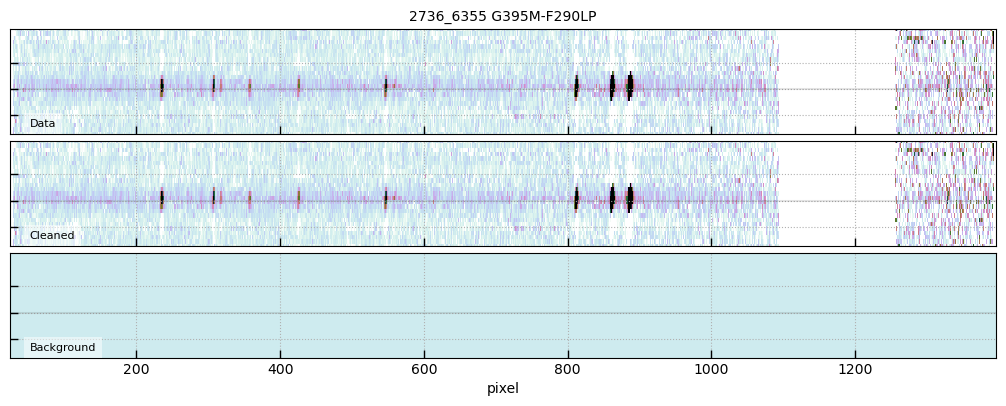

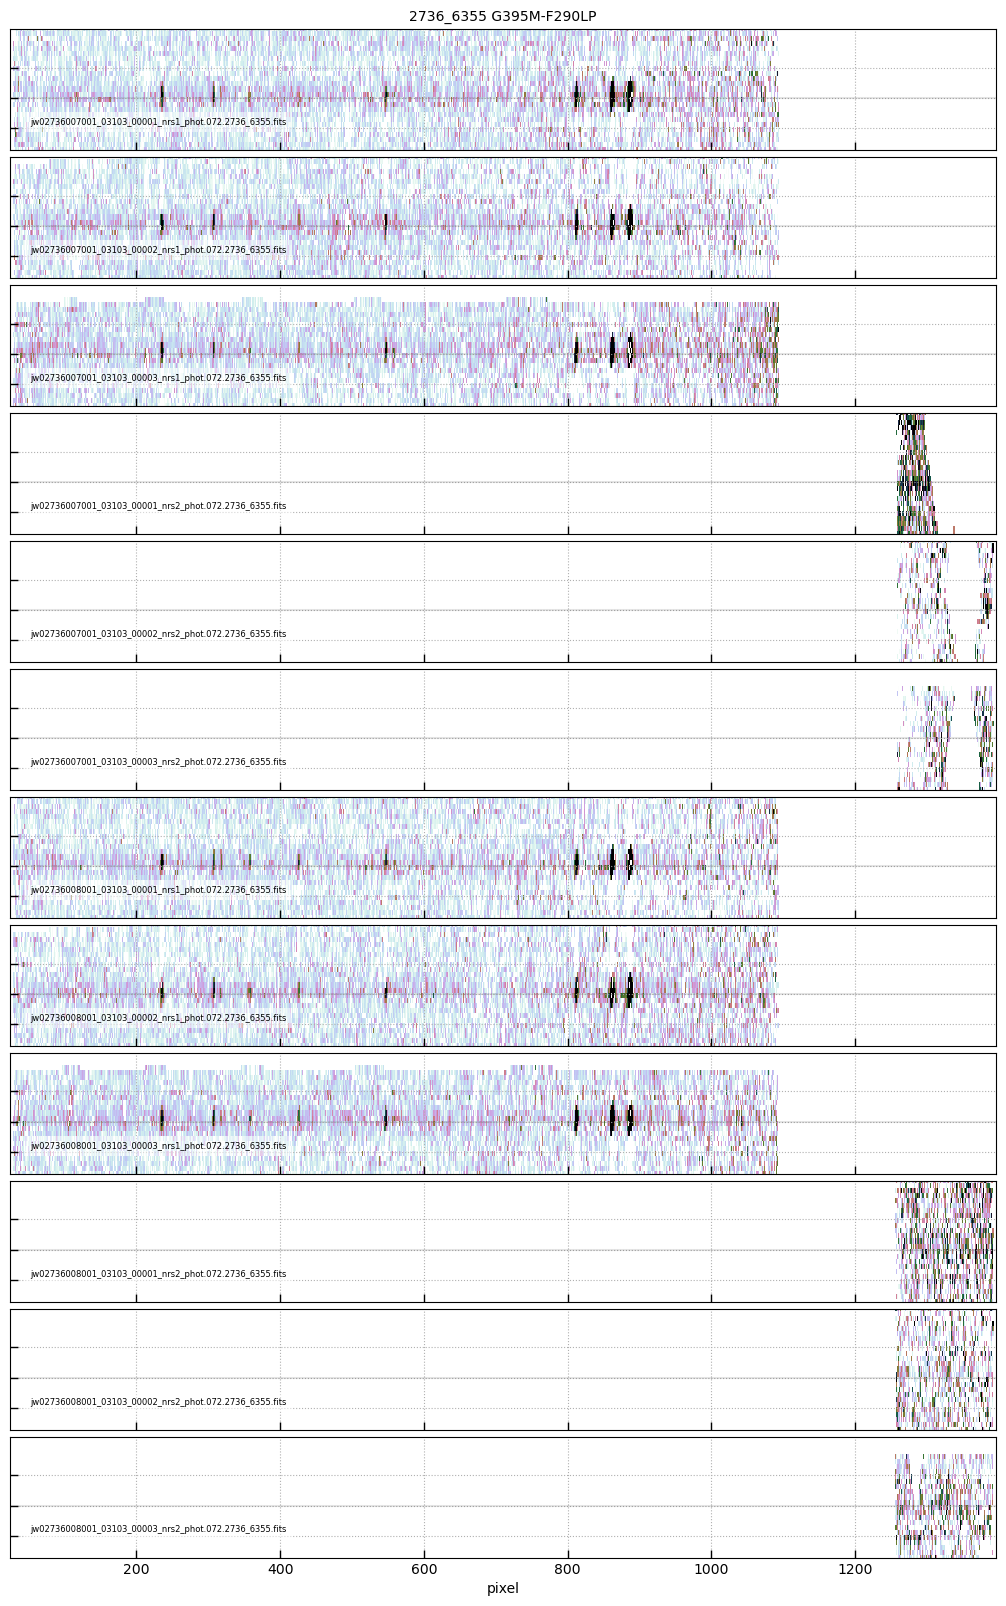

In [24]:
# Next target
key = '2736_6355'

hdus = extract_target(key)

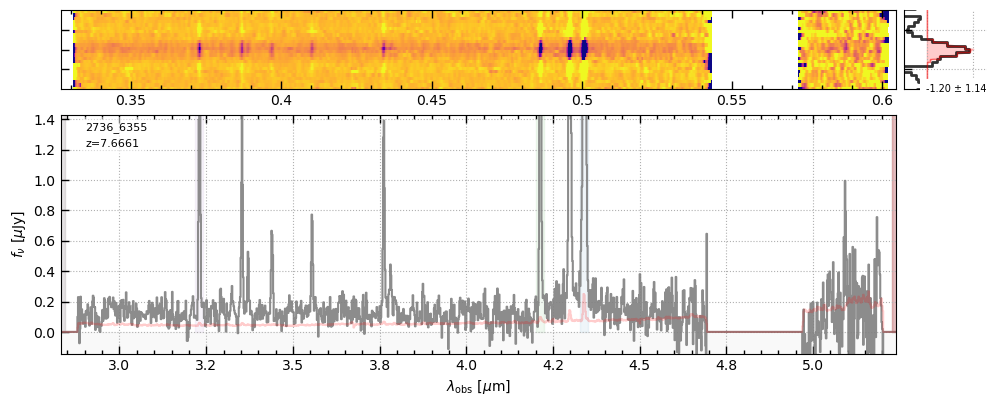

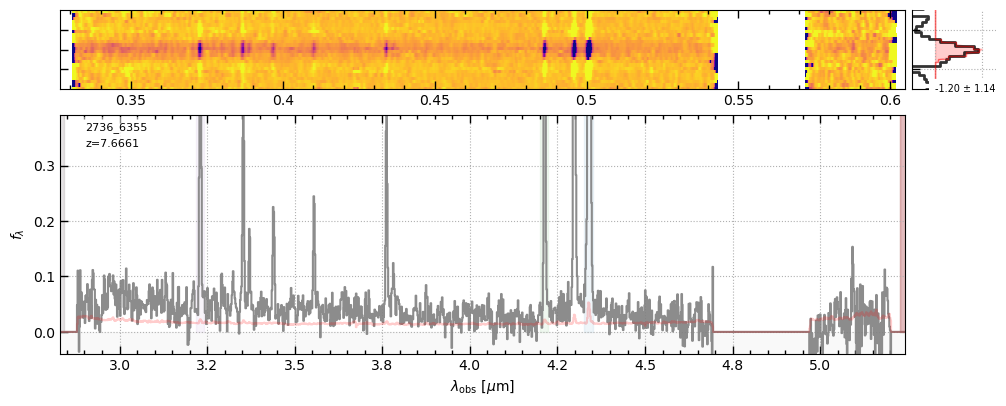

In [25]:
# make plots

for g in hdus:
    hdul = hdus[g]
    
    kws = dict(z=7.6661, # z labels
               ymax_sigma_scale=5, # y axis scaling
               smooth_sigma=2, # smoothing in 2D panels
              )
    
    # Make figures
    fig = msaexp.utils.drizzled_hdu_figure(hdul, unit='fnu', **kws)
    fig.savefig(f'{outroot}_{target}.{file_version}.fnu.png')

    fig = msaexp.utils.drizzled_hdu_figure(hdul, unit='flam', **kws)
    fig.savefig(f'{outroot}_{target}.{file_version}.flam.png')


Add 3 slitlets from jw02736007001-01-f290lp-g395m-nrs1
Add 3 slitlets from jw02736007001-01-f290lp-g395m-nrs2
Add 3 slitlets from jw02736008001-01-f290lp-g395m-nrs1
Add 3 slitlets from jw02736008001-01-f290lp-g395m-nrs2
f290lp-g395m total 12 slitlets
outlier_threshold:  7.0
msaexp.drizzle.drizzle_slitlets: 2736_10612 read 12 files
msaexp.drizzle.drizzle_slitlets: id=2736_10612  g395m-f290lp N=12
msaexp.drizzle.drizzle_slitlets: get wcs from slit 0 =  2736_10612


2023-03-30 17:44:42,754 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:44:42,754 - stpipe - INFO - Driz parameter pixfrac: 1.0
2023-03-30 17:44:42,754 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:44:42,754 - stpipe - INFO - Driz parameter weight_type: ivm
2023-03-30 17:44:42,922 - stpipe - INFO - Blending metadata for None
2023-03-30 17:44:43,466 - stpipe - INFO - Resampling science data
2023-03-30 17:44:43,505 - stpipe - INFO - Drizzling (34, 978) --> (31, 1414)
2023-03-30 17:44:43,513 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:44:43,557 - stpipe - INFO - Drizzling (34, 978) --> (31, 1414)
2023-03-30 17:44:43,568 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:44:43,618 - stpipe - INFO - Drizzling (34, 978) --> (31, 1414)
2023-03-30 17:44:43,628 - stpipe - INFO - Resampling var_flat
2023-03-30 17:44:43,671 - stpipe - INFO - Drizzling (34, 978) --> (31, 1414)
2023-03-30 17:44:44,165 - stpipe - INFO - Driz parameter kernal: square
2023-03-30

msaexp.drizzle.drizzle_slitlets: output size = (31, 1414)
msaexp.drizzle.drizzle_slitlets: g395m-f290lp  0 2736_10612             10612  0.233 <SlitModel(34, 978) from jw02736007001_03103_00001_nrs1_phot.069.2736_10612.fits> (34, 978)


2023-03-30 17:44:45,551 - stpipe - INFO - Blending metadata for None
2023-03-30 17:44:46,095 - stpipe - INFO - Resampling science data
2023-03-30 17:44:46,139 - stpipe - INFO - Drizzling (34, 978) --> (31, 1414)
2023-03-30 17:44:46,146 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:44:46,200 - stpipe - INFO - Drizzling (34, 978) --> (31, 1414)
2023-03-30 17:44:46,207 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:44:46,253 - stpipe - INFO - Drizzling (34, 978) --> (31, 1414)
2023-03-30 17:44:46,261 - stpipe - INFO - Resampling var_flat
2023-03-30 17:44:46,304 - stpipe - INFO - Drizzling (34, 978) --> (31, 1414)
2023-03-30 17:44:46,475 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:44:46,475 - stpipe - INFO - Driz parameter pixfrac: 0.8
2023-03-30 17:44:46,475 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:44:46,476 - stpipe - INFO - Driz parameter weight_type: ivm


msaexp.drizzle.drizzle_slitlets: g395m-f290lp  1 2736_10612             10612  0.245 <SlitModel(34, 978) from jw02736007001_03103_00002_nrs1_phot.069.2736_10612.fits> (34, 978)


2023-03-30 17:44:46,642 - stpipe - INFO - Blending metadata for None
2023-03-30 17:44:47,184 - stpipe - INFO - Resampling science data
2023-03-30 17:44:47,228 - stpipe - INFO - Drizzling (34, 978) --> (31, 1414)
2023-03-30 17:44:47,234 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:44:47,288 - stpipe - INFO - Drizzling (34, 978) --> (31, 1414)
2023-03-30 17:44:47,295 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:44:47,340 - stpipe - INFO - Drizzling (34, 978) --> (31, 1414)
2023-03-30 17:44:47,346 - stpipe - INFO - Resampling var_flat
2023-03-30 17:44:47,875 - stpipe - INFO - Drizzling (34, 978) --> (31, 1414)
2023-03-30 17:44:48,038 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:44:48,038 - stpipe - INFO - Driz parameter pixfrac: 0.8
2023-03-30 17:44:48,038 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:44:48,039 - stpipe - INFO - Driz parameter weight_type: ivm


msaexp.drizzle.drizzle_slitlets: g395m-f290lp  2 2736_10612             10612  0.221 <SlitModel(34, 978) from jw02736007001_03103_00003_nrs1_phot.069.2736_10612.fits> (34, 978)


2023-03-30 17:44:48,205 - stpipe - INFO - Blending metadata for None
2023-03-30 17:44:48,747 - stpipe - INFO - Resampling science data
2023-03-30 17:44:48,790 - stpipe - INFO - Drizzling (34, 978) --> (31, 1414)
2023-03-30 17:44:48,796 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:44:48,836 - stpipe - INFO - Drizzling (34, 978) --> (31, 1414)
2023-03-30 17:44:48,843 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:44:48,885 - stpipe - INFO - Drizzling (34, 978) --> (31, 1414)
2023-03-30 17:44:48,893 - stpipe - INFO - Resampling var_flat
2023-03-30 17:44:48,933 - stpipe - INFO - Drizzling (34, 978) --> (31, 1414)
2023-03-30 17:44:49,057 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:44:49,057 - stpipe - INFO - Driz parameter pixfrac: 0.8
2023-03-30 17:44:49,057 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:44:49,058 - stpipe - INFO - Driz parameter weight_type: ivm


msaexp.drizzle.drizzle_slitlets: g395m-f290lp  3 2736_10612             10612  0.233 <SlitModel(30, 238) from jw02736007001_03103_00001_nrs2_phot.069.2736_10612.fits> (30, 238)


2023-03-30 17:44:49,224 - stpipe - INFO - Blending metadata for None
2023-03-30 17:44:49,768 - stpipe - INFO - Resampling science data
2023-03-30 17:44:49,793 - stpipe - INFO - Drizzling (30, 238) --> (31, 1414)
2023-03-30 17:44:49,793 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:44:49,819 - stpipe - INFO - Drizzling (30, 238) --> (31, 1414)
2023-03-30 17:44:49,822 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:44:49,846 - stpipe - INFO - Drizzling (30, 238) --> (31, 1414)
2023-03-30 17:44:49,849 - stpipe - INFO - Resampling var_flat
2023-03-30 17:44:49,875 - stpipe - INFO - Drizzling (30, 238) --> (31, 1414)
2023-03-30 17:44:49,991 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:44:49,991 - stpipe - INFO - Driz parameter pixfrac: 0.8
2023-03-30 17:44:49,992 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:44:49,992 - stpipe - INFO - Driz parameter weight_type: ivm


msaexp.drizzle.drizzle_slitlets: g395m-f290lp  4 2736_10612             10612  0.245 <SlitModel(30, 238) from jw02736007001_03103_00002_nrs2_phot.069.2736_10612.fits> (30, 238)


2023-03-30 17:44:50,158 - stpipe - INFO - Blending metadata for None
2023-03-30 17:44:50,699 - stpipe - INFO - Resampling science data
2023-03-30 17:44:50,723 - stpipe - INFO - Drizzling (30, 238) --> (31, 1414)
2023-03-30 17:44:50,725 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:44:50,749 - stpipe - INFO - Drizzling (30, 238) --> (31, 1414)
2023-03-30 17:44:50,751 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:44:50,777 - stpipe - INFO - Drizzling (30, 238) --> (31, 1414)
2023-03-30 17:44:50,780 - stpipe - INFO - Resampling var_flat
2023-03-30 17:44:50,805 - stpipe - INFO - Drizzling (30, 238) --> (31, 1414)
2023-03-30 17:44:50,924 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:44:50,925 - stpipe - INFO - Driz parameter pixfrac: 0.8
2023-03-30 17:44:50,925 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:44:50,925 - stpipe - INFO - Driz parameter weight_type: ivm


msaexp.drizzle.drizzle_slitlets: g395m-f290lp  5 2736_10612             10612  0.221 <SlitModel(30, 238) from jw02736007001_03103_00003_nrs2_phot.069.2736_10612.fits> (30, 238)


2023-03-30 17:44:51,094 - stpipe - INFO - Blending metadata for None
2023-03-30 17:44:51,637 - stpipe - INFO - Resampling science data
2023-03-30 17:44:51,661 - stpipe - INFO - Drizzling (30, 238) --> (31, 1414)
2023-03-30 17:44:51,662 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:44:51,687 - stpipe - INFO - Drizzling (30, 238) --> (31, 1414)
2023-03-30 17:44:51,690 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:44:51,715 - stpipe - INFO - Drizzling (30, 238) --> (31, 1414)
2023-03-30 17:44:51,718 - stpipe - INFO - Resampling var_flat
2023-03-30 17:44:51,743 - stpipe - INFO - Drizzling (30, 238) --> (31, 1414)
2023-03-30 17:44:51,909 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:44:51,910 - stpipe - INFO - Driz parameter pixfrac: 0.8
2023-03-30 17:44:51,910 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:44:51,910 - stpipe - INFO - Driz parameter weight_type: ivm


msaexp.drizzle.drizzle_slitlets: g395m-f290lp  6 2736_10612             10612  0.233 <SlitModel(34, 977) from jw02736008001_03103_00001_nrs1_phot.069.2736_10612.fits> (34, 977)


2023-03-30 17:44:52,077 - stpipe - INFO - Blending metadata for None
2023-03-30 17:44:53,158 - stpipe - INFO - Resampling science data
2023-03-30 17:44:53,326 - stpipe - INFO - Drizzling (34, 977) --> (31, 1414)
2023-03-30 17:44:53,332 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:44:53,562 - stpipe - INFO - Drizzling (34, 977) --> (31, 1414)
2023-03-30 17:44:53,570 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:44:53,802 - stpipe - INFO - Drizzling (34, 977) --> (31, 1414)
2023-03-30 17:44:53,810 - stpipe - INFO - Resampling var_flat
2023-03-30 17:44:53,892 - stpipe - INFO - Drizzling (34, 977) --> (31, 1414)


msaexp.drizzle.drizzle_slitlets: g395m-f290lp  7 2736_10612             10612  0.245 <SlitModel(34, 977) from jw02736008001_03103_00002_nrs1_phot.069.2736_10612.fits> (34, 977)


2023-03-30 17:44:54,502 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:44:54,503 - stpipe - INFO - Driz parameter pixfrac: 0.8
2023-03-30 17:44:54,503 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:44:54,503 - stpipe - INFO - Driz parameter weight_type: ivm
2023-03-30 17:44:54,669 - stpipe - INFO - Blending metadata for None
2023-03-30 17:44:55,221 - stpipe - INFO - Resampling science data
2023-03-30 17:44:55,448 - stpipe - INFO - Drizzling (34, 977) --> (31, 1414)
2023-03-30 17:44:55,454 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:44:55,598 - stpipe - INFO - Drizzling (34, 977) --> (31, 1414)
2023-03-30 17:44:55,605 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:44:55,767 - stpipe - INFO - Drizzling (34, 977) --> (31, 1414)
2023-03-30 17:44:55,774 - stpipe - INFO - Resampling var_flat
2023-03-30 17:44:55,836 - stpipe - INFO - Drizzling (34, 977) --> (31, 1414)


msaexp.drizzle.drizzle_slitlets: g395m-f290lp  8 2736_10612             10612  0.221 <SlitModel(34, 977) from jw02736008001_03103_00003_nrs1_phot.069.2736_10612.fits> (34, 977)


2023-03-30 17:44:56,094 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:44:56,095 - stpipe - INFO - Driz parameter pixfrac: 0.8
2023-03-30 17:44:56,095 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:44:56,095 - stpipe - INFO - Driz parameter weight_type: ivm
2023-03-30 17:44:56,261 - stpipe - INFO - Blending metadata for None
2023-03-30 17:44:56,809 - stpipe - INFO - Resampling science data
2023-03-30 17:44:56,851 - stpipe - INFO - Drizzling (34, 977) --> (31, 1414)
2023-03-30 17:44:56,857 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:44:56,901 - stpipe - INFO - Drizzling (34, 977) --> (31, 1414)
2023-03-30 17:44:56,908 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:44:57,046 - stpipe - INFO - Drizzling (34, 977) --> (31, 1414)
2023-03-30 17:44:57,054 - stpipe - INFO - Resampling var_flat
2023-03-30 17:44:57,106 - stpipe - INFO - Drizzling (34, 977) --> (31, 1414)
2023-03-30 17:44:57,232 - stpipe - INFO - Driz parameter kernal: square
2023-03-30

msaexp.drizzle.drizzle_slitlets: g395m-f290lp  9 2736_10612             10612  0.233 <SlitModel(30, 239) from jw02736008001_03103_00001_nrs2_phot.069.2736_10612.fits> (30, 239)


2023-03-30 17:44:57,398 - stpipe - INFO - Blending metadata for None
2023-03-30 17:44:57,940 - stpipe - INFO - Resampling science data
2023-03-30 17:44:57,968 - stpipe - INFO - Drizzling (30, 239) --> (31, 1414)
2023-03-30 17:44:57,969 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:44:57,994 - stpipe - INFO - Drizzling (30, 239) --> (31, 1414)
2023-03-30 17:44:57,997 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:44:58,021 - stpipe - INFO - Drizzling (30, 239) --> (31, 1414)
2023-03-30 17:44:58,024 - stpipe - INFO - Resampling var_flat
2023-03-30 17:44:58,048 - stpipe - INFO - Drizzling (30, 239) --> (31, 1414)
2023-03-30 17:44:58,174 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:44:58,174 - stpipe - INFO - Driz parameter pixfrac: 0.8
2023-03-30 17:44:58,174 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:44:58,175 - stpipe - INFO - Driz parameter weight_type: ivm


msaexp.drizzle.drizzle_slitlets: g395m-f290lp 10 2736_10612             10612  0.245 <SlitModel(30, 239) from jw02736008001_03103_00002_nrs2_phot.069.2736_10612.fits> (30, 239)


2023-03-30 17:44:58,340 - stpipe - INFO - Blending metadata for None
2023-03-30 17:44:58,881 - stpipe - INFO - Resampling science data
2023-03-30 17:44:58,906 - stpipe - INFO - Drizzling (30, 239) --> (31, 1414)
2023-03-30 17:44:58,907 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:44:58,933 - stpipe - INFO - Drizzling (30, 239) --> (31, 1414)
2023-03-30 17:44:58,936 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:44:58,960 - stpipe - INFO - Drizzling (30, 239) --> (31, 1414)
2023-03-30 17:44:58,962 - stpipe - INFO - Resampling var_flat
2023-03-30 17:44:58,987 - stpipe - INFO - Drizzling (30, 239) --> (31, 1414)
2023-03-30 17:44:59,107 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:44:59,108 - stpipe - INFO - Driz parameter pixfrac: 0.8
2023-03-30 17:44:59,108 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:44:59,108 - stpipe - INFO - Driz parameter weight_type: ivm


msaexp.drizzle.drizzle_slitlets: g395m-f290lp 11 2736_10612             10612  0.221 <SlitModel(30, 239) from jw02736008001_03103_00003_nrs2_phot.069.2736_10612.fits> (30, 239)


2023-03-30 17:44:59,284 - stpipe - INFO - Blending metadata for None
2023-03-30 17:44:59,834 - stpipe - INFO - Resampling science data
2023-03-30 17:44:59,858 - stpipe - INFO - Drizzling (30, 239) --> (31, 1414)
2023-03-30 17:44:59,860 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:45:00,403 - stpipe - INFO - Drizzling (30, 239) --> (31, 1414)
2023-03-30 17:45:00,405 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:45:00,430 - stpipe - INFO - Drizzling (30, 239) --> (31, 1414)
2023-03-30 17:45:00,433 - stpipe - INFO - Resampling var_flat
2023-03-30 17:45:00,459 - stpipe - INFO - Drizzling (30, 239) --> (31, 1414)
2023-03-30 17:45:00,534 - stpipe - WARNING - VerifyWarning: Card is too long, comment will be truncated.


msaexp.drizzle.extract_from_hdul: Initial center =   -1.13, sigma =   0.90
msaexp.drizzle.extract_from_hdul:  Output center =  -0.81, sigma =   0.66


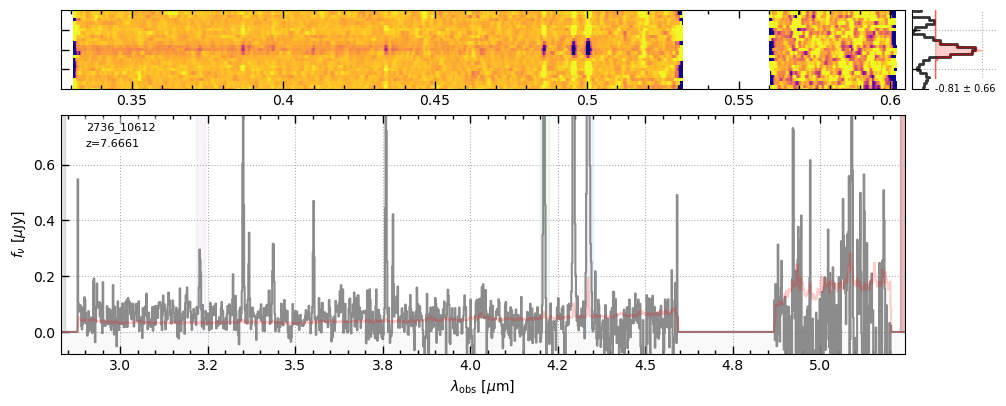

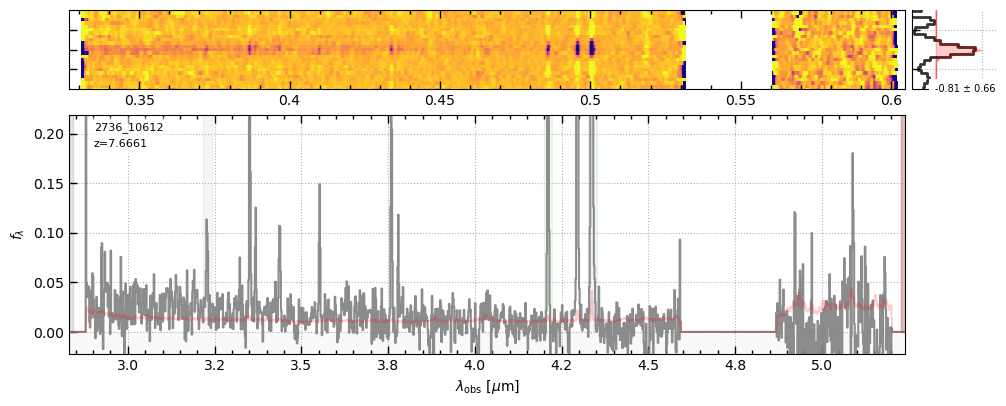

In [26]:
# Drizzle combinations
key = '2736_10612'

hdus = extract_target(key)
plt.close('all')

for g in hdus:
    hdul = hdus[g]
    
    kws = dict(z=7.6661, # z labels
               ymax_sigma_scale=5, # y axis scaling
               smooth_sigma=2, # smoothing in 2D panels
              )
    
    # Make figures
    fig = msaexp.utils.drizzled_hdu_figure(hdul, unit='fnu', **kws)
    fig.savefig(f'{outroot}_{target}.{file_version}.fnu.png')

    fig = msaexp.utils.drizzled_hdu_figure(hdul, unit='flam', **kws)
    fig.savefig(f'{outroot}_{target}.{file_version}.flam.png')


## Fit redshift

In [27]:
from msaexp import spectrum
spectrum.SCALE_UNCERTAINTY = 1.0
spectrum.FFTSMOOTH = False

357it [00:04, 89.20it/s] 
501it [00:06, 81.43it/s]



# line flux err
# flux x 10^-20 erg/s/cm2
# smacs0723-f290lp-g395m_2736_10612.v0.6.8.dev1.spec.fits
# z = 7.65968
# Thu Mar 30 17:45:12 2023
             line Hb      158.8 ±      4.4
             line Hg       79.7 ±      3.4
             line Hd       41.4 ±      3.2
             line H8       30.2 ±      3.2
             line H9       16.0 ±      3.3
            line H10        7.0 ±      3.3
            line H11        5.0 ±      3.2
            line H12       -0.6 ±      3.1
             line H7       15.6 ±      4.3
     line NeIII-3968       23.8 ±      4.1
      line OIII-4959      365.5 ±      6.5
      line OIII-5007     1103.2 ±     14.0
      line OIII-4363       28.4 ±      2.9
            line OII       36.9 ±      4.0
      line HeII-4687        1.8 ±      2.9
     line NeIII-3867       92.9 ±      4.0
       line HeI-5877       51.6 ±      9.5
       line NeV-3346        5.1 ±      5.7
      line NeVI-3426       -0.8 ±      4.2


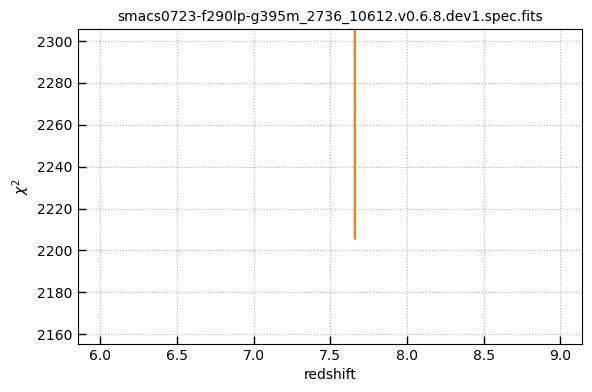

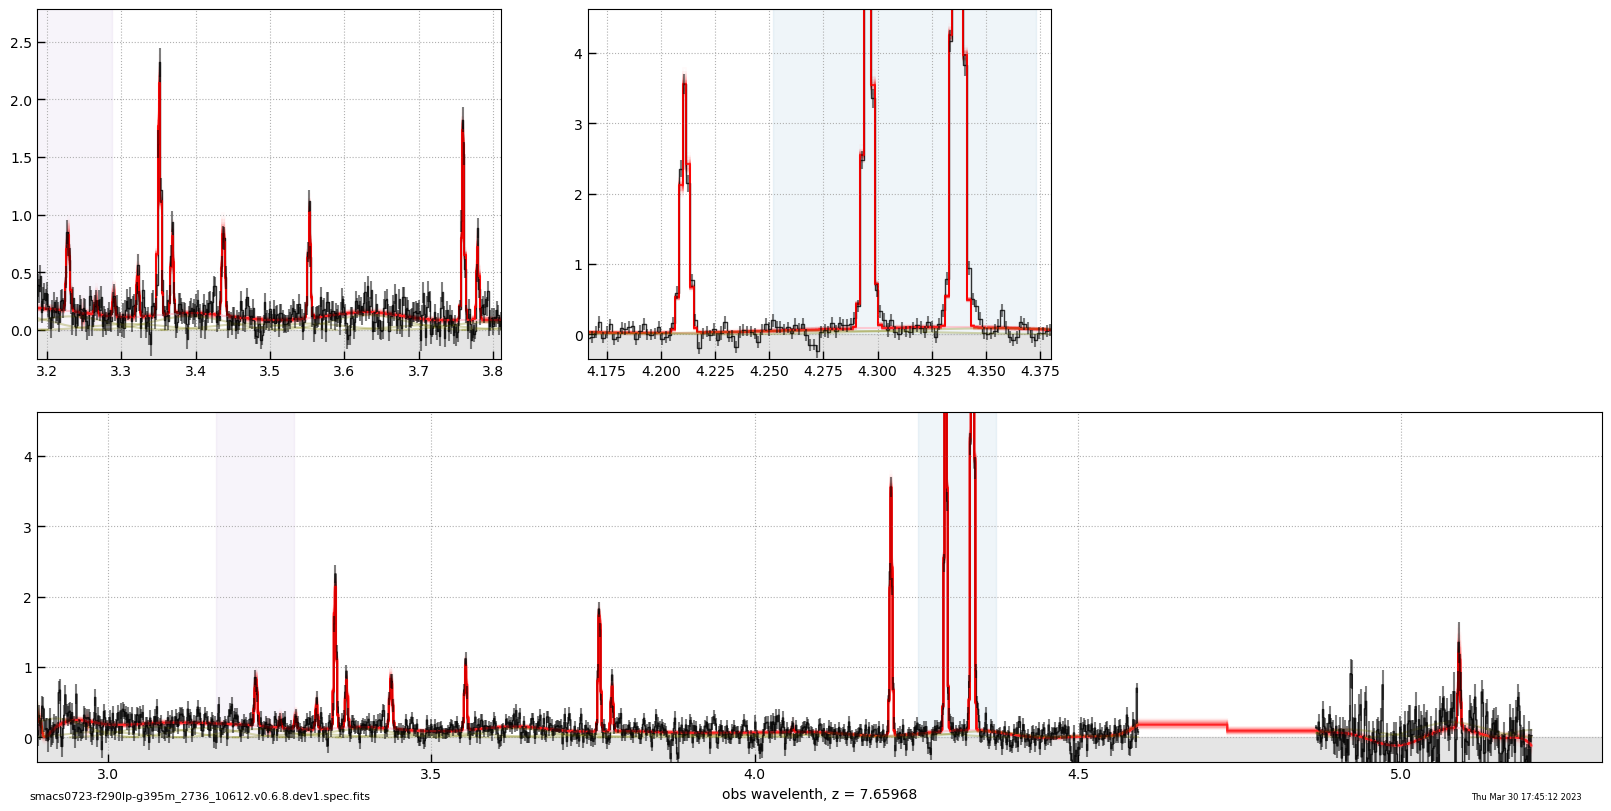

In [28]:

output_root = list(hdus.keys())[0]

fig, sp, data = spectrum.fit_redshift(file=f'{output_root}.spec.fits',
                          z0=[6,9], 
                          eazy_templates=None,
                          nspline=33,
                          scale_disp=1.0,
                          vel_width=20.,
                          is_prism=False,
                         )

(-3.0, 3.0)

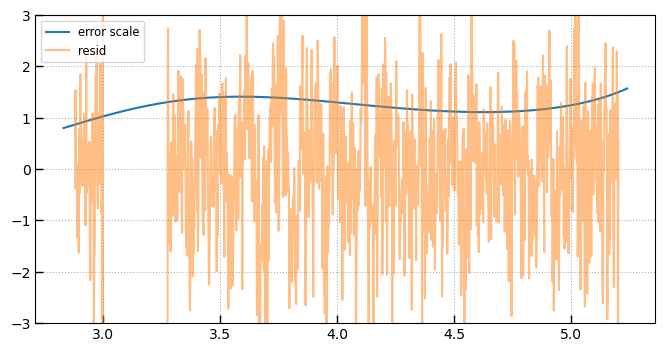

In [42]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(sp['wave'], sp['escale'], label='error scale')
ax.plot(sp['wave'], (sp['flux'] - sp['model']) / sp['full_err'], label='resid', alpha=0.5)
ax.legend()
ax.grid()

ax.set_ylim(-3,3)


Set SCALE_UNCERTAINTY:  [ 0.01478186 -0.17047336  0.65834285 -0.80185365]

# line flux err
# flux x 10^-20 erg/s/cm2
# smacs0723-f290lp-g395m_2736_10612.v0.6.8.dev1.spec.fits
# z = 7.65968
# Thu Mar 30 17:45:21 2023
             line Hb      158.7 ±      4.9
             line Hg       79.6 ±      3.8
             line Hd       41.4 ±      3.6
             line H8       30.2 ±      3.5
             line H9       16.0 ±      3.7
            line H10        7.0 ±      3.7
            line H11        5.0 ±      3.5
            line H12       -0.6 ±      3.5
             line H7       15.6 ±      4.7
     line NeIII-3968       23.7 ±      4.6
      line OIII-4959      365.4 ±      7.4
      line OIII-5007     1103.7 ±     15.8
      line OIII-4363       28.4 ±      3.2
            line OII       36.8 ±      4.5
      line HeII-4687        1.8 ±      3.2
     line NeIII-3867       92.8 ±      4.4
       line HeI-5877       51.5 ±     11.4
       line NeV-3346        5.2 ±      6.1
      line

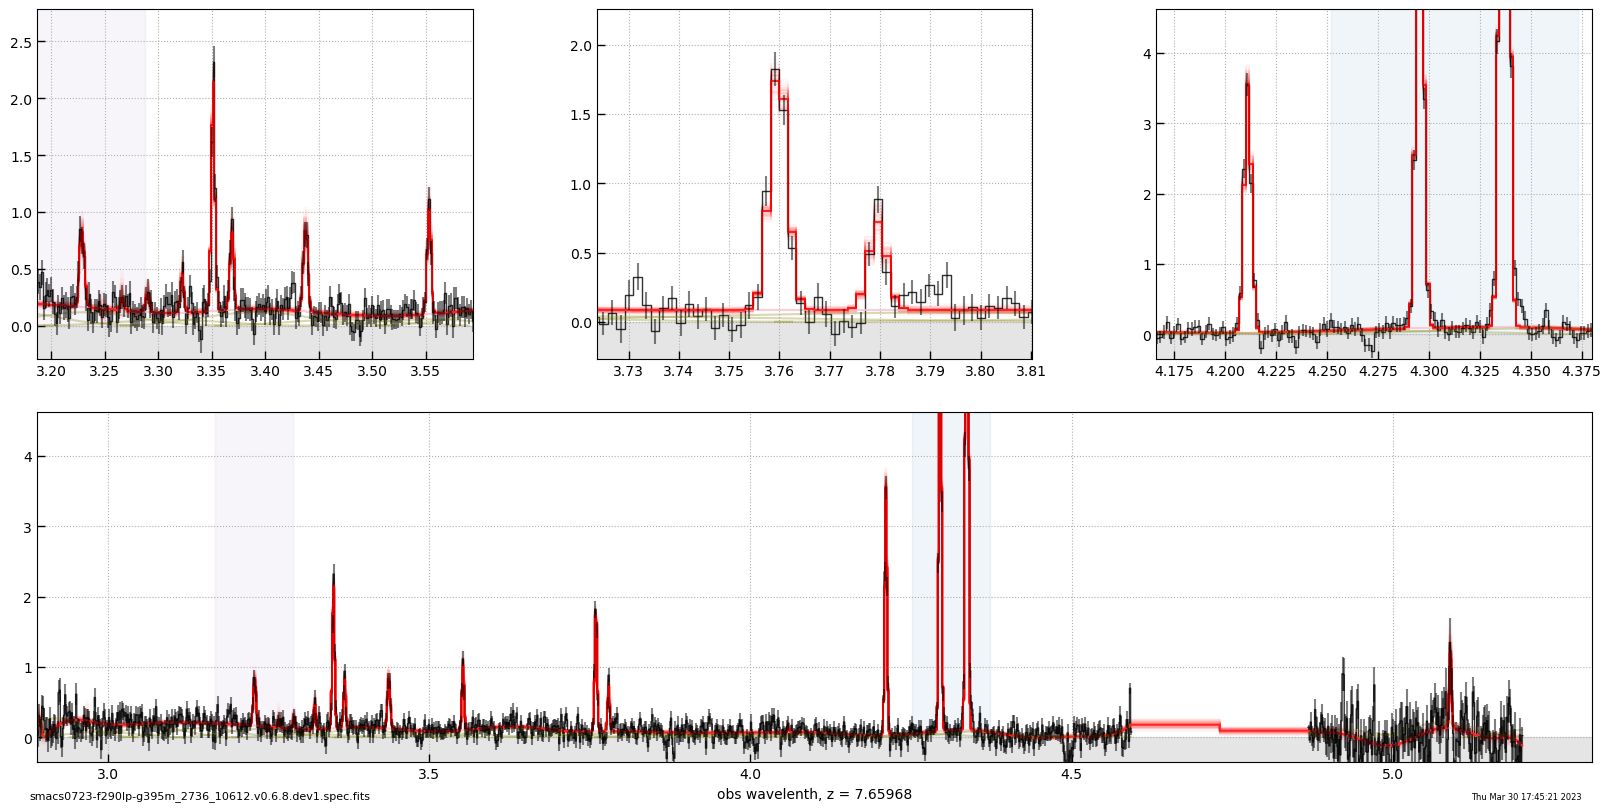

In [30]:
# Rescale uncertainties

spectrum.SCALE_UNCERTAINTY = 1.0

fig, sp, data = spectrum.plot_spectrum(file=f'{output_root}.spec.fits', 
                           z=data['z'],
                          eazy_templates=None,
                          nspline=33,
                          scale_disp=1.0,
                          vel_width=10.,
                          is_prism=False,
                           scale_uncertainty_kwargs={'order':3, 'init':[1,3]},
                           use_full_dispersion=False,
                           Rline=5000,
                           ranges=[(3680, 4150), (4300, 4400), (4861-50, 5008+50)],
                         )

(-3.0, 3.0)

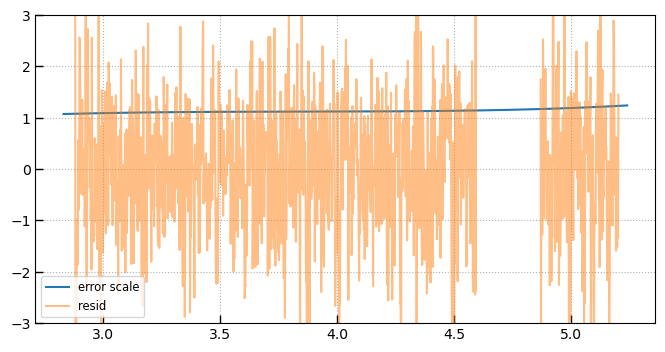

In [31]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(sp['wave'], sp['escale'], label='error scale')
ax.plot(sp['wave'], (sp['flux'] - sp['model']) / sp['full_err'], label='resid', alpha=0.5)
ax.legend()
ax.grid()
ax.set_ylim(-3,3)


357it [00:03, 98.24it/s] 
501it [00:05, 91.38it/s] 



# line flux err
# flux x 10^-20 erg/s/cm2
# smacs0723-f290lp-g395m_2736_10612.v0.6.8.dev1.spec.fits
# z = 7.65968
# Thu Mar 30 17:45:31 2023
             line Hb      158.7 ±      4.8
             line Hg       79.6 ±      3.8
             line Hd       41.4 ±      3.6
             line H8       30.2 ±      3.5
             line H9       16.0 ±      3.7
            line H10        7.0 ±      3.7
            line H11        5.0 ±      3.5
            line H12       -0.6 ±      3.5
             line H7       15.6 ±      4.7
     line NeIII-3968       23.7 ±      4.6
      line OIII-4959      365.9 ±      7.1
      line OIII-5007     1105.2 ±     14.8
      line OIII-4363       28.5 ±      3.2
            line OII       36.8 ±      4.5
      line HeII-4687        1.8 ±      3.2
     line NeIII-3867       92.9 ±      4.4
       line HeI-5877       51.5 ±     11.4
       line NeV-3346        5.2 ±      6.1
      line NeVI-3426       -0.8 ±      4.6


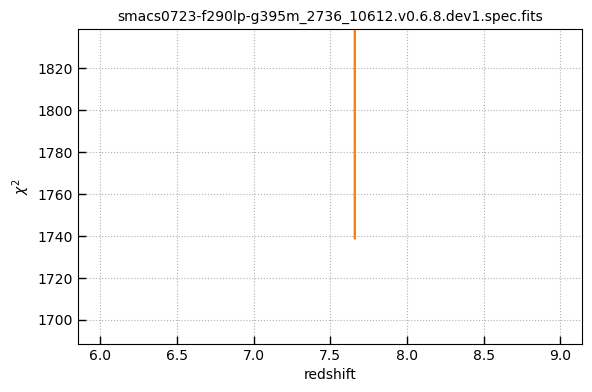

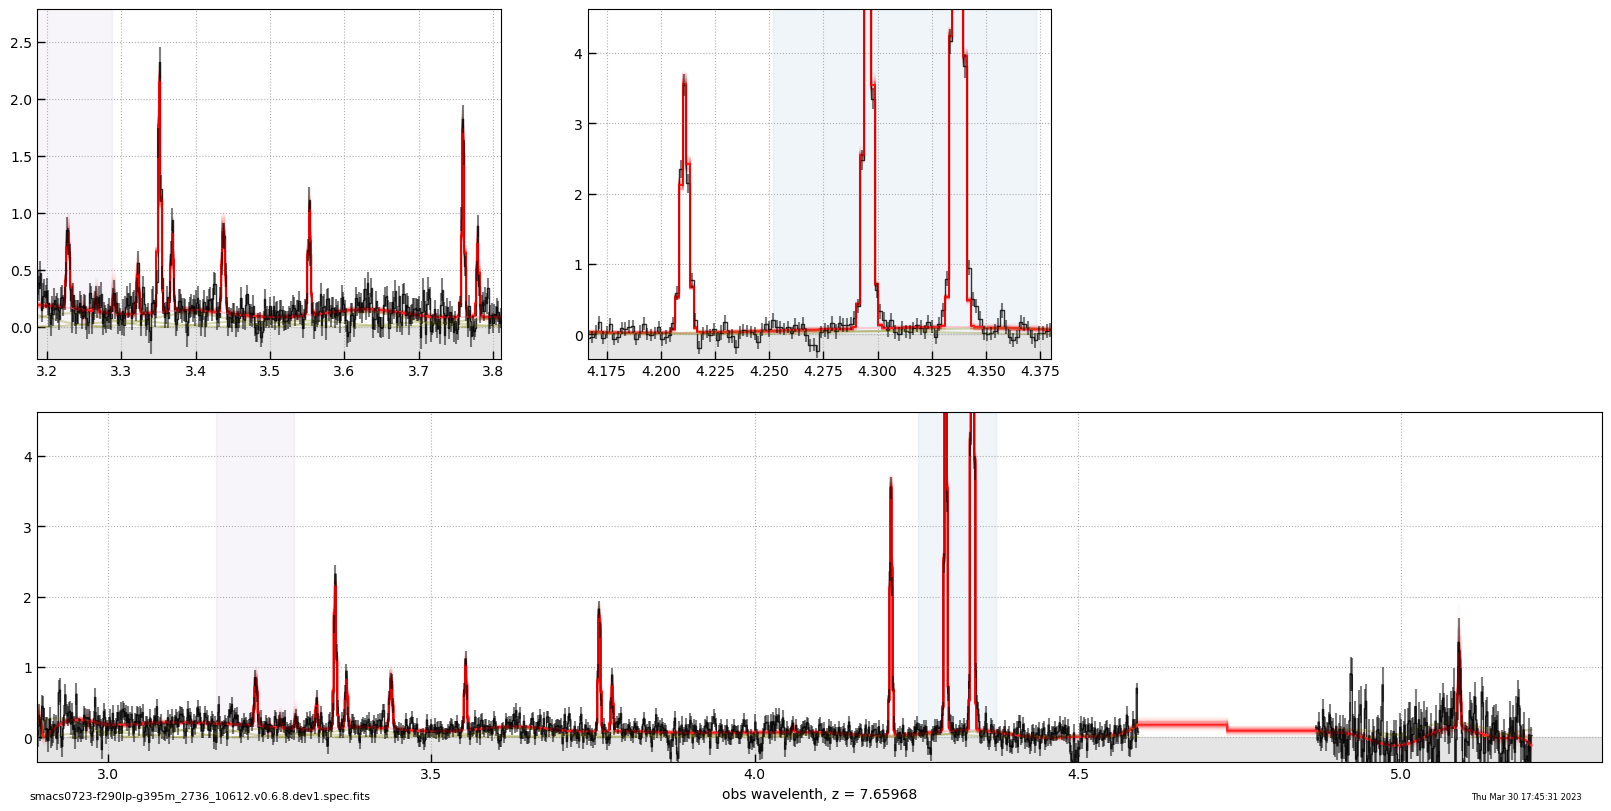

In [32]:
# Refit redshift with scaled uncertainties
_ = spectrum.fit_redshift(file=f'{output_root}.spec.fits', z0=[6,9], 
                          eazy_templates=None,
                          nspline=33,
                          scale_disp=1.0,
                          vel_width=10.,
                          is_prism=False,
                          use_full_dispersion=False
                         )

## Fit redshifts with `eazy` templates

In [33]:
import eazy
reload(eazy)

if not os.path.exists('templates'):
    eazy.symlink_eazy_inputs()
    
otempl = eazy.templates.read_templates_file('templates/sfhz/blue_sfhz_13.param')[:]

templ = [otempl[i].smooth_velocity(3.e5/2500, in_place=False, smoothspec_kwargs={'fftsmooth': False}) 
         for i in [-1]]


2023-03-30 17:45:32,753 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/eazy/templates.py:356: ResourceWarning: unclosed file <_io.TextIOWrapper name='templates/sfhz/blue_sfhz_13.param' mode='r' encoding='UTF-8'>
  lines = open(templates_file).readlines()



In [34]:
spectrum.FFTSMOOTH = False

357it [00:00, 719.81it/s]
501it [00:00, 723.44it/s]



# line flux err
# flux x 10^-20 erg/s/cm2
# smacs0723-f290lp-g395m_2736_10612.v0.6.8.dev1.spec.fits
# z = 7.65968
# Thu Mar 30 17:45:34 2023

# line flux err
# flux x 10^-20 erg/s/cm2
# smacs0723-f290lp-g395m_2736_10612.v0.6.8.dev1.spec.fits
# z = 7.65968
# Thu Mar 30 17:45:35 2023
             line Hb      158.7 ±      4.8
             line Hg       79.6 ±      3.8
             line Hd       41.4 ±      3.6
             line H8       30.2 ±      3.5
             line H9       16.0 ±      3.7
            line H10        7.0 ±      3.7
            line H11        5.0 ±      3.5
            line H12       -0.6 ±      3.5
             line H7       15.6 ±      4.7
     line NeIII-3968       23.7 ±      4.6
      line OIII-4959      365.9 ±      7.1
      line OIII-5007     1105.2 ±     14.8
      line OIII-4363       28.5 ±      3.2
            line OII       36.8 ±      4.5
      line HeII-4687        1.8 ±      3.2
     line NeIII-3867       92.9 ±      4.4
       line HeI-5877       5

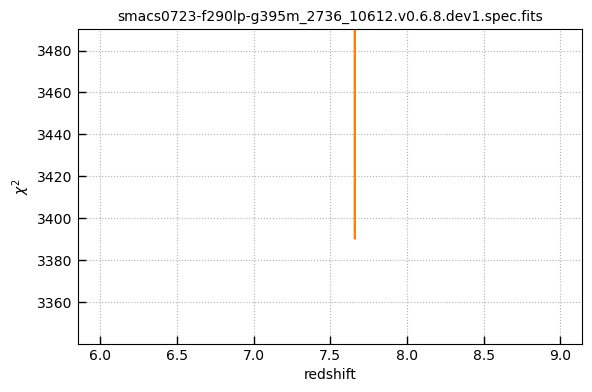

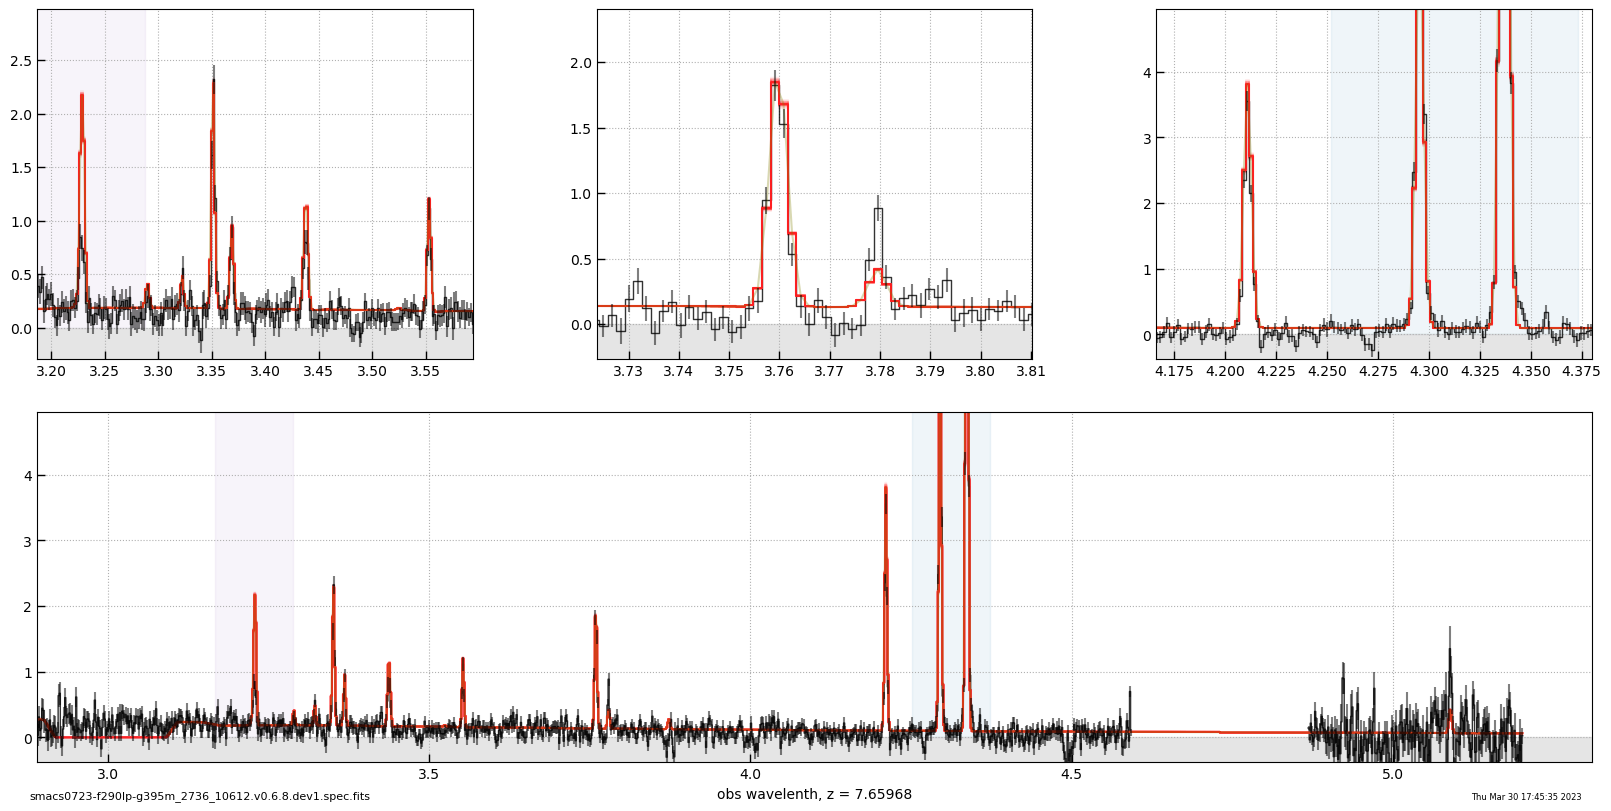

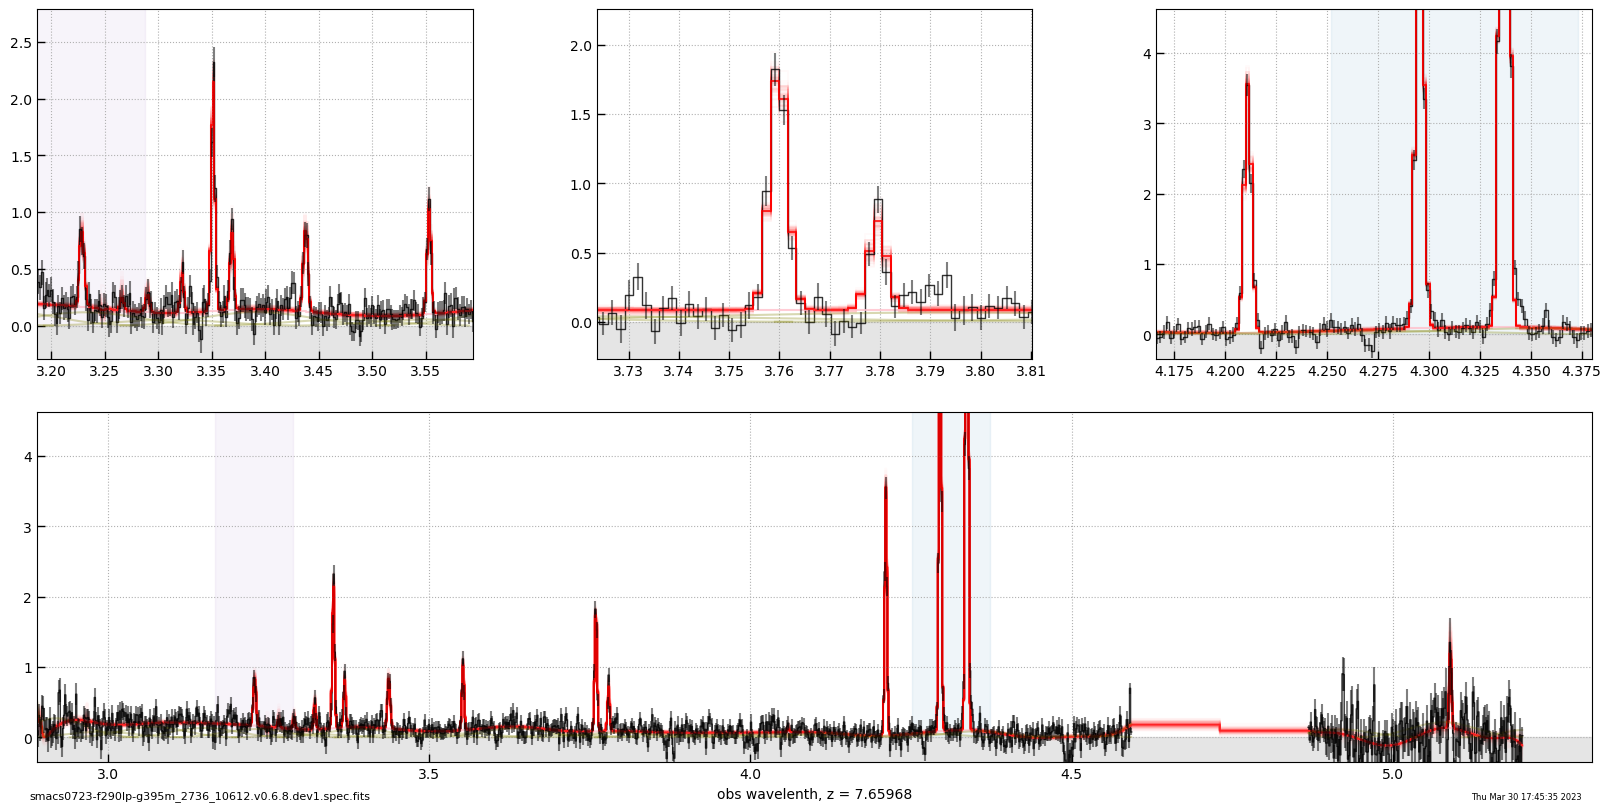

In [35]:
_ = spectrum.fit_redshift(file=f'{output_root}.spec.fits', z0=[6,9], 
                          eazy_templates=templ,
                          nspline=33,
                          scale_disp=1.0,
                          vel_width=10.,
                          is_prism=False,
                          use_full_dispersion=False,
                          ranges=[(3680, 4150), (4300, 4400), (4861-50, 5008+50)],
                         )

## More sources

Add 3 slitlets from jw02736007001-01-f290lp-g395m-nrs1
Add 3 slitlets from jw02736007001-01-f290lp-g395m-nrs2
Add 3 slitlets from jw02736008001-01-f290lp-g395m-nrs1
Add 3 slitlets from jw02736008001-01-f290lp-g395m-nrs2
f290lp-g395m total 12 slitlets
outlier_threshold:  7.0
msaexp.drizzle.drizzle_slitlets: 2736_9239 read 12 files
msaexp.drizzle.drizzle_slitlets: id=2736_9239  g395m-f290lp N=12
msaexp.drizzle.drizzle_slitlets: get wcs from slit 0 =  2736_9239


2023-03-30 17:45:38,393 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:45:38,393 - stpipe - INFO - Driz parameter pixfrac: 1.0
2023-03-30 17:45:38,394 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:45:38,394 - stpipe - INFO - Driz parameter weight_type: ivm
2023-03-30 17:45:38,562 - stpipe - INFO - Blending metadata for None
2023-03-30 17:45:39,114 - stpipe - INFO - Resampling science data
2023-03-30 17:45:39,137 - stpipe - INFO - Drizzling (39, 89) --> (31, 1414)
2023-03-30 17:45:39,138 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:45:39,162 - stpipe - INFO - Drizzling (39, 89) --> (31, 1414)
2023-03-30 17:45:39,166 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:45:39,188 - stpipe - INFO - Drizzling (39, 89) --> (31, 1414)
2023-03-30 17:45:39,190 - stpipe - INFO - Resampling var_flat
2023-03-30 17:45:39,219 - stpipe - INFO - Drizzling (39, 89) --> (31, 1414)
2023-03-30 17:45:39,557 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:

msaexp.drizzle.drizzle_slitlets: output size = (31, 1414)
msaexp.drizzle.drizzle_slitlets: g395m-f290lp  0 2736_9239               9239 -0.227 <SlitModel(39, 89) from jw02736007001_03103_00001_nrs1_phot.020.2736_9239.fits> (39, 89)


2023-03-30 17:45:40,707 - stpipe - INFO - Blending metadata for None
2023-03-30 17:45:41,256 - stpipe - INFO - Resampling science data
2023-03-30 17:45:41,838 - stpipe - INFO - Drizzling (39, 89) --> (31, 1414)
2023-03-30 17:45:41,838 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:45:41,861 - stpipe - INFO - Drizzling (39, 89) --> (31, 1414)
2023-03-30 17:45:41,863 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:45:41,888 - stpipe - INFO - Drizzling (39, 89) --> (31, 1414)
2023-03-30 17:45:41,890 - stpipe - INFO - Resampling var_flat
2023-03-30 17:45:41,917 - stpipe - INFO - Drizzling (39, 89) --> (31, 1414)
2023-03-30 17:45:42,033 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:45:42,033 - stpipe - INFO - Driz parameter pixfrac: 0.8
2023-03-30 17:45:42,034 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:45:42,034 - stpipe - INFO - Driz parameter weight_type: ivm


msaexp.drizzle.drizzle_slitlets: g395m-f290lp  1 2736_9239               9239 -0.211 <SlitModel(39, 89) from jw02736007001_03103_00002_nrs1_phot.020.2736_9239.fits> (39, 89)


2023-03-30 17:45:42,203 - stpipe - INFO - Blending metadata for None
2023-03-30 17:45:42,750 - stpipe - INFO - Resampling science data
2023-03-30 17:45:42,773 - stpipe - INFO - Drizzling (39, 89) --> (31, 1414)
2023-03-30 17:45:42,774 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:45:42,800 - stpipe - INFO - Drizzling (39, 89) --> (31, 1414)
2023-03-30 17:45:42,802 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:45:42,825 - stpipe - INFO - Drizzling (39, 89) --> (31, 1414)
2023-03-30 17:45:42,827 - stpipe - INFO - Resampling var_flat
2023-03-30 17:45:42,851 - stpipe - INFO - Drizzling (39, 89) --> (31, 1414)
2023-03-30 17:45:42,964 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:45:42,965 - stpipe - INFO - Driz parameter pixfrac: 0.8
2023-03-30 17:45:42,965 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:45:42,965 - stpipe - INFO - Driz parameter weight_type: ivm


msaexp.drizzle.drizzle_slitlets: g395m-f290lp  2 2736_9239               9239 -0.242 <SlitModel(39, 89) from jw02736007001_03103_00003_nrs1_phot.020.2736_9239.fits> (39, 89)


2023-03-30 17:45:43,135 - stpipe - INFO - Blending metadata for None
2023-03-30 17:45:43,683 - stpipe - INFO - Resampling science data
2023-03-30 17:45:43,705 - stpipe - INFO - Drizzling (39, 89) --> (31, 1414)
2023-03-30 17:45:43,706 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:45:43,733 - stpipe - INFO - Drizzling (39, 89) --> (31, 1414)
2023-03-30 17:45:43,735 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:45:43,759 - stpipe - INFO - Drizzling (39, 89) --> (31, 1414)
2023-03-30 17:45:43,761 - stpipe - INFO - Resampling var_flat
2023-03-30 17:45:43,786 - stpipe - INFO - Drizzling (39, 89) --> (31, 1414)
2023-03-30 17:45:43,973 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:45:43,973 - stpipe - INFO - Driz parameter pixfrac: 0.8
2023-03-30 17:45:43,974 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:45:43,974 - stpipe - INFO - Driz parameter weight_type: ivm


msaexp.drizzle.drizzle_slitlets: g395m-f290lp  3 2736_9239               9239 -0.227 <SlitModel(46, 1134) from jw02736007001_03103_00001_nrs2_phot.020.2736_9239.fits> (46, 1134)


2023-03-30 17:45:44,145 - stpipe - INFO - Blending metadata for None
2023-03-30 17:45:44,689 - stpipe - INFO - Resampling science data
2023-03-30 17:45:44,742 - stpipe - INFO - Drizzling (46, 1134) --> (31, 1414)
2023-03-30 17:45:44,751 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:45:44,801 - stpipe - INFO - Drizzling (46, 1134) --> (31, 1414)
2023-03-30 17:45:44,810 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:45:44,863 - stpipe - INFO - Drizzling (46, 1134) --> (31, 1414)
2023-03-30 17:45:44,873 - stpipe - INFO - Resampling var_flat
2023-03-30 17:45:44,926 - stpipe - INFO - Drizzling (46, 1134) --> (31, 1414)
2023-03-30 17:45:45,120 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:45:45,120 - stpipe - INFO - Driz parameter pixfrac: 0.8
2023-03-30 17:45:45,120 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:45:45,121 - stpipe - INFO - Driz parameter weight_type: ivm


msaexp.drizzle.drizzle_slitlets: g395m-f290lp  4 2736_9239               9239 -0.211 <SlitModel(46, 1134) from jw02736007001_03103_00002_nrs2_phot.020.2736_9239.fits> (46, 1134)


2023-03-30 17:45:45,291 - stpipe - INFO - Blending metadata for None
2023-03-30 17:45:45,838 - stpipe - INFO - Resampling science data
2023-03-30 17:45:45,890 - stpipe - INFO - Drizzling (46, 1134) --> (31, 1414)
2023-03-30 17:45:45,898 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:45:45,951 - stpipe - INFO - Drizzling (46, 1134) --> (31, 1414)
2023-03-30 17:45:45,961 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:45:46,017 - stpipe - INFO - Drizzling (46, 1134) --> (31, 1414)
2023-03-30 17:45:46,026 - stpipe - INFO - Resampling var_flat
2023-03-30 17:45:46,078 - stpipe - INFO - Drizzling (46, 1134) --> (31, 1414)
2023-03-30 17:45:46,269 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:45:46,270 - stpipe - INFO - Driz parameter pixfrac: 0.8
2023-03-30 17:45:46,270 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:45:46,270 - stpipe - INFO - Driz parameter weight_type: ivm


msaexp.drizzle.drizzle_slitlets: g395m-f290lp  5 2736_9239               9239 -0.242 <SlitModel(46, 1134) from jw02736007001_03103_00003_nrs2_phot.020.2736_9239.fits> (46, 1134)


2023-03-30 17:45:46,444 - stpipe - INFO - Blending metadata for None
2023-03-30 17:45:47,494 - stpipe - INFO - Resampling science data
2023-03-30 17:45:47,544 - stpipe - INFO - Drizzling (46, 1134) --> (31, 1414)
2023-03-30 17:45:47,553 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:45:47,605 - stpipe - INFO - Drizzling (46, 1134) --> (31, 1414)
2023-03-30 17:45:47,614 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:45:47,669 - stpipe - INFO - Drizzling (46, 1134) --> (31, 1414)
2023-03-30 17:45:47,679 - stpipe - INFO - Resampling var_flat
2023-03-30 17:45:47,745 - stpipe - INFO - Drizzling (46, 1134) --> (31, 1414)
2023-03-30 17:45:47,865 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:45:47,865 - stpipe - INFO - Driz parameter pixfrac: 0.8
2023-03-30 17:45:47,866 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:45:47,866 - stpipe - INFO - Driz parameter weight_type: ivm


msaexp.drizzle.drizzle_slitlets: g395m-f290lp  6 2736_9239               9239 -0.227 <SlitModel(39, 88) from jw02736008001_03103_00001_nrs1_phot.020.2736_9239.fits> (39, 88)


2023-03-30 17:45:48,037 - stpipe - INFO - Blending metadata for None
2023-03-30 17:45:48,583 - stpipe - INFO - Resampling science data
2023-03-30 17:45:48,606 - stpipe - INFO - Drizzling (39, 88) --> (31, 1414)
2023-03-30 17:45:48,607 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:45:48,632 - stpipe - INFO - Drizzling (39, 88) --> (31, 1414)
2023-03-30 17:45:48,634 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:45:48,658 - stpipe - INFO - Drizzling (39, 88) --> (31, 1414)
2023-03-30 17:45:48,660 - stpipe - INFO - Resampling var_flat
2023-03-30 17:45:48,685 - stpipe - INFO - Drizzling (39, 88) --> (31, 1414)
2023-03-30 17:45:48,799 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:45:48,799 - stpipe - INFO - Driz parameter pixfrac: 0.8
2023-03-30 17:45:48,799 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:45:48,799 - stpipe - INFO - Driz parameter weight_type: ivm


msaexp.drizzle.drizzle_slitlets: g395m-f290lp  7 2736_9239               9239 -0.211 <SlitModel(39, 88) from jw02736008001_03103_00002_nrs1_phot.020.2736_9239.fits> (39, 88)


2023-03-30 17:45:48,969 - stpipe - INFO - Blending metadata for None
2023-03-30 17:45:49,516 - stpipe - INFO - Resampling science data
2023-03-30 17:45:49,539 - stpipe - INFO - Drizzling (39, 88) --> (31, 1414)
2023-03-30 17:45:49,540 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:45:49,565 - stpipe - INFO - Drizzling (39, 88) --> (31, 1414)
2023-03-30 17:45:49,567 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:45:49,591 - stpipe - INFO - Drizzling (39, 88) --> (31, 1414)
2023-03-30 17:45:49,593 - stpipe - INFO - Resampling var_flat
2023-03-30 17:45:49,618 - stpipe - INFO - Drizzling (39, 88) --> (31, 1414)
2023-03-30 17:45:49,731 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:45:49,732 - stpipe - INFO - Driz parameter pixfrac: 0.8
2023-03-30 17:45:49,732 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:45:49,732 - stpipe - INFO - Driz parameter weight_type: ivm


msaexp.drizzle.drizzle_slitlets: g395m-f290lp  8 2736_9239               9239 -0.242 <SlitModel(39, 88) from jw02736008001_03103_00003_nrs1_phot.020.2736_9239.fits> (39, 88)


2023-03-30 17:45:49,902 - stpipe - INFO - Blending metadata for None
2023-03-30 17:45:50,443 - stpipe - INFO - Resampling science data
2023-03-30 17:45:50,469 - stpipe - INFO - Drizzling (39, 88) --> (31, 1414)
2023-03-30 17:45:50,469 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:45:50,495 - stpipe - INFO - Drizzling (39, 88) --> (31, 1414)
2023-03-30 17:45:50,497 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:45:50,521 - stpipe - INFO - Drizzling (39, 88) --> (31, 1414)
2023-03-30 17:45:50,523 - stpipe - INFO - Resampling var_flat
2023-03-30 17:45:50,547 - stpipe - INFO - Drizzling (39, 88) --> (31, 1414)
2023-03-30 17:45:50,729 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:45:50,729 - stpipe - INFO - Driz parameter pixfrac: 0.8
2023-03-30 17:45:50,730 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:45:50,730 - stpipe - INFO - Driz parameter weight_type: ivm


msaexp.drizzle.drizzle_slitlets: g395m-f290lp  9 2736_9239               9239 -0.227 <SlitModel(46, 1135) from jw02736008001_03103_00001_nrs2_phot.020.2736_9239.fits> (46, 1135)


2023-03-30 17:45:50,899 - stpipe - INFO - Blending metadata for None
2023-03-30 17:45:51,449 - stpipe - INFO - Resampling science data
2023-03-30 17:45:51,500 - stpipe - INFO - Drizzling (46, 1135) --> (31, 1414)
2023-03-30 17:45:51,509 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:45:51,561 - stpipe - INFO - Drizzling (46, 1135) --> (31, 1414)
2023-03-30 17:45:51,571 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:45:51,620 - stpipe - INFO - Drizzling (46, 1135) --> (31, 1414)
2023-03-30 17:45:51,630 - stpipe - INFO - Resampling var_flat
2023-03-30 17:45:51,685 - stpipe - INFO - Drizzling (46, 1135) --> (31, 1414)
2023-03-30 17:45:51,879 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:45:51,880 - stpipe - INFO - Driz parameter pixfrac: 0.8
2023-03-30 17:45:51,880 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:45:51,880 - stpipe - INFO - Driz parameter weight_type: ivm


msaexp.drizzle.drizzle_slitlets: g395m-f290lp 10 2736_9239               9239 -0.211 <SlitModel(46, 1135) from jw02736008001_03103_00002_nrs2_phot.020.2736_9239.fits> (46, 1135)


2023-03-30 17:45:52,049 - stpipe - INFO - Blending metadata for None
2023-03-30 17:45:52,594 - stpipe - INFO - Resampling science data
2023-03-30 17:45:52,643 - stpipe - INFO - Drizzling (46, 1135) --> (31, 1414)
2023-03-30 17:45:52,651 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:45:53,236 - stpipe - INFO - Drizzling (46, 1135) --> (31, 1414)
2023-03-30 17:45:53,245 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:45:53,295 - stpipe - INFO - Drizzling (46, 1135) --> (31, 1414)
2023-03-30 17:45:53,304 - stpipe - INFO - Resampling var_flat
2023-03-30 17:45:53,356 - stpipe - INFO - Drizzling (46, 1135) --> (31, 1414)
2023-03-30 17:45:53,553 - stpipe - INFO - Driz parameter kernal: square
2023-03-30 17:45:53,553 - stpipe - INFO - Driz parameter pixfrac: 0.8
2023-03-30 17:45:53,554 - stpipe - INFO - Driz parameter fillval: 0
2023-03-30 17:45:53,554 - stpipe - INFO - Driz parameter weight_type: ivm


msaexp.drizzle.drizzle_slitlets: g395m-f290lp 11 2736_9239               9239 -0.242 <SlitModel(46, 1135) from jw02736008001_03103_00003_nrs2_phot.020.2736_9239.fits> (46, 1135)


2023-03-30 17:45:53,723 - stpipe - INFO - Blending metadata for None
2023-03-30 17:45:54,276 - stpipe - INFO - Resampling science data
2023-03-30 17:45:54,325 - stpipe - INFO - Drizzling (46, 1135) --> (31, 1414)
2023-03-30 17:45:54,334 - stpipe - INFO - Resampling var_rnoise
2023-03-30 17:45:54,385 - stpipe - INFO - Drizzling (46, 1135) --> (31, 1414)
2023-03-30 17:45:54,395 - stpipe - INFO - Resampling var_poisson
2023-03-30 17:45:54,448 - stpipe - INFO - Drizzling (46, 1135) --> (31, 1414)
2023-03-30 17:45:54,458 - stpipe - INFO - Resampling var_flat
2023-03-30 17:45:54,509 - stpipe - INFO - Drizzling (46, 1135) --> (31, 1414)
2023-03-30 17:45:54,591 - stpipe - WARNING - VerifyWarning: Card is too long, comment will be truncated.


msaexp.drizzle.extract_from_hdul: Initial center =    1.10, sigma =   0.90
msaexp.drizzle.extract_from_hdul:  Output center =   1.97, sigma =   1.55


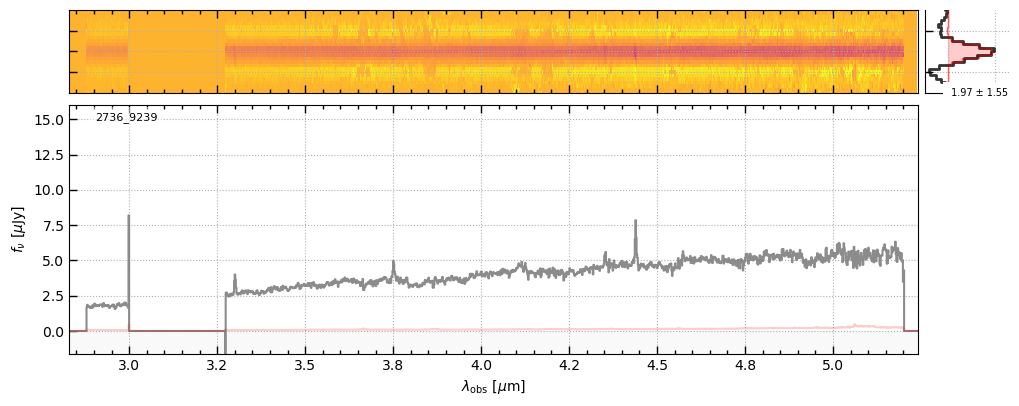

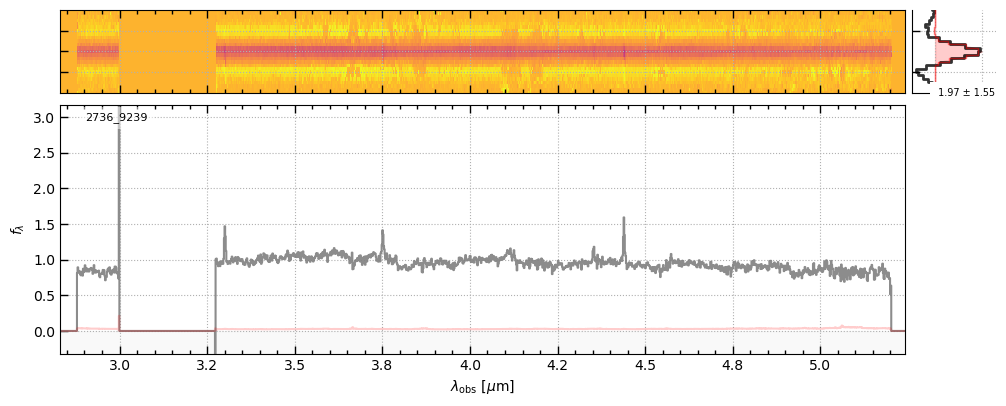

In [36]:
key = pipe.targets[0]

key = '2736_9239'

hdus = extract_target(key)
plt.close('all')

for g in hdus:
    hdul = hdus[g]
    
    kws = dict(ymax_sigma_scale=3, # y axis scaling
              )
    
    # Make figures
    fig = msaexp.utils.drizzled_hdu_figure(hdul, unit='fnu', **kws)
    fig.savefig(f'{outroot}_{target}.{file_version}.fnu.png')

    fig = msaexp.utils.drizzled_hdu_figure(hdul, unit='flam', **kws)
    fig.savefig(f'{outroot}_{target}.{file_version}.flam.png')


(0.0, 2.0)

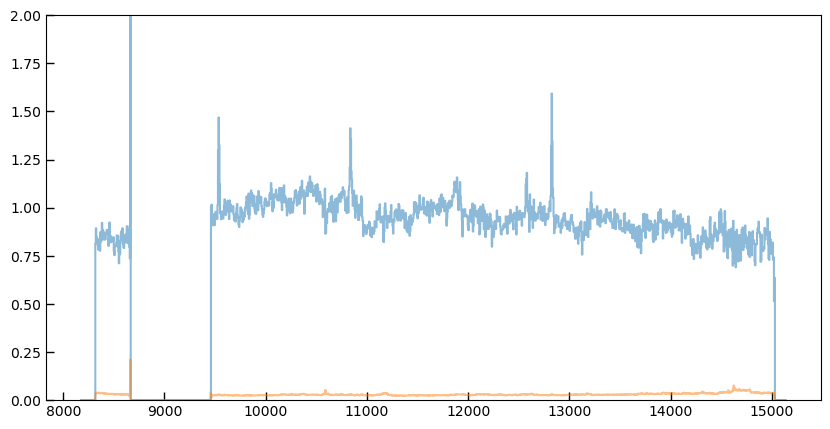

In [37]:
import grizli.utils

fig, ax = plt.subplots(1,1,figsize=(10,5))

z = 2.272e4/6564.-1

for g in hdus:
    sp = grizli.utils.GTable(hdus[g]['SPEC1D'].data)
    ax.step(sp['wave']/(1+z)*1.e4, sp['flux']*(sp['wave']/2.)**-2, alpha=0.5, where='mid')
    ax.step(sp['wave']/(1+z)*1.e4, sp['err']*(sp['wave']/2.)**-2, alpha=0.5, where='mid')
    
ax.set_ylim(0, 2)

#ax.set_xlim(2.25, 2.3)
# ax.set_xlim(9000, 1.4e4)

694it [00:02, 267.05it/s]
501it [00:01, 260.33it/s]



# line flux err
# flux x 10^-20 erg/s/cm2
# smacs0723-f290lp-g395m_2736_9239.v0.6.8.dev1.spec.fits
# z = 2.46244
# Thu Mar 30 17:46:27 2023

# line flux err
# flux x 10^-20 erg/s/cm2
# smacs0723-f290lp-g395m_2736_9239.v0.6.8.dev1.spec.fits
# z = 2.46244
# Thu Mar 30 17:46:28 2023
      line SIII-9068        0.0 ±      0.0
      line SIII-9531      173.5 ±     12.8
            line PaD       25.4 ±     10.9
            line PaG       43.0 ±     11.6
            line PaB      210.1 ±     11.5
       line HeI-1083      158.1 ±     12.7
            line Pa8       -1.5 ±     11.0
            line Pa9        0.0 ±      0.0
           line Pa10        0.0 ±      0.0
       line HeI-8446        0.0 ±      9.6


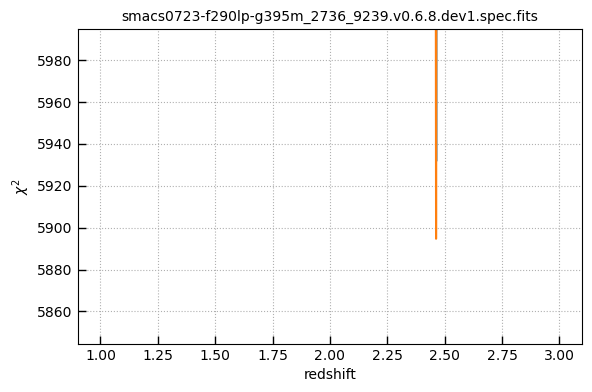

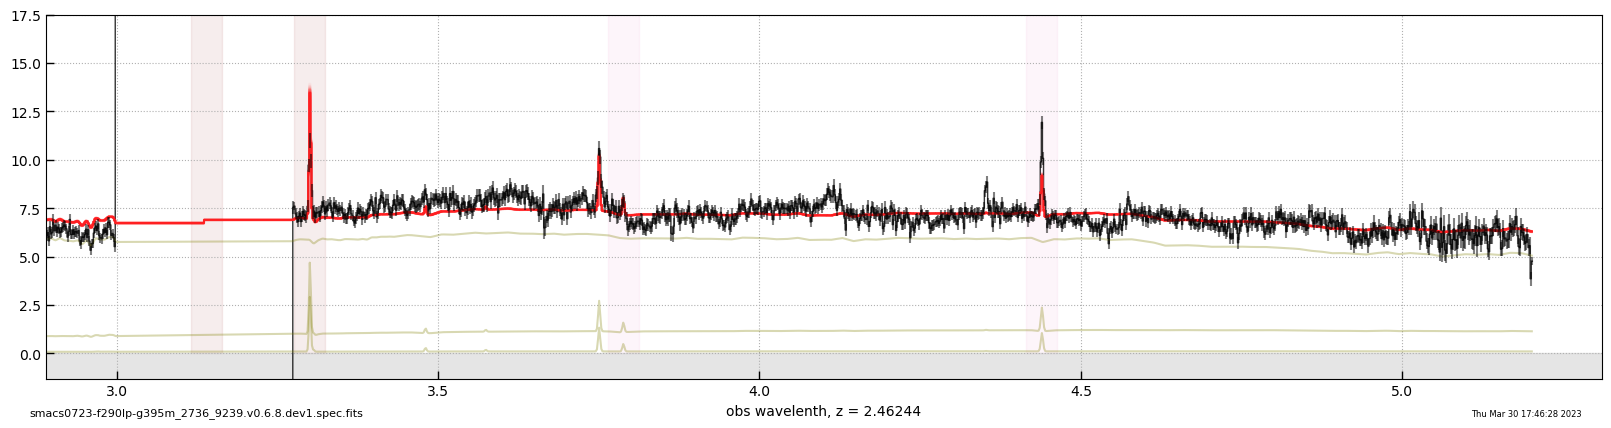

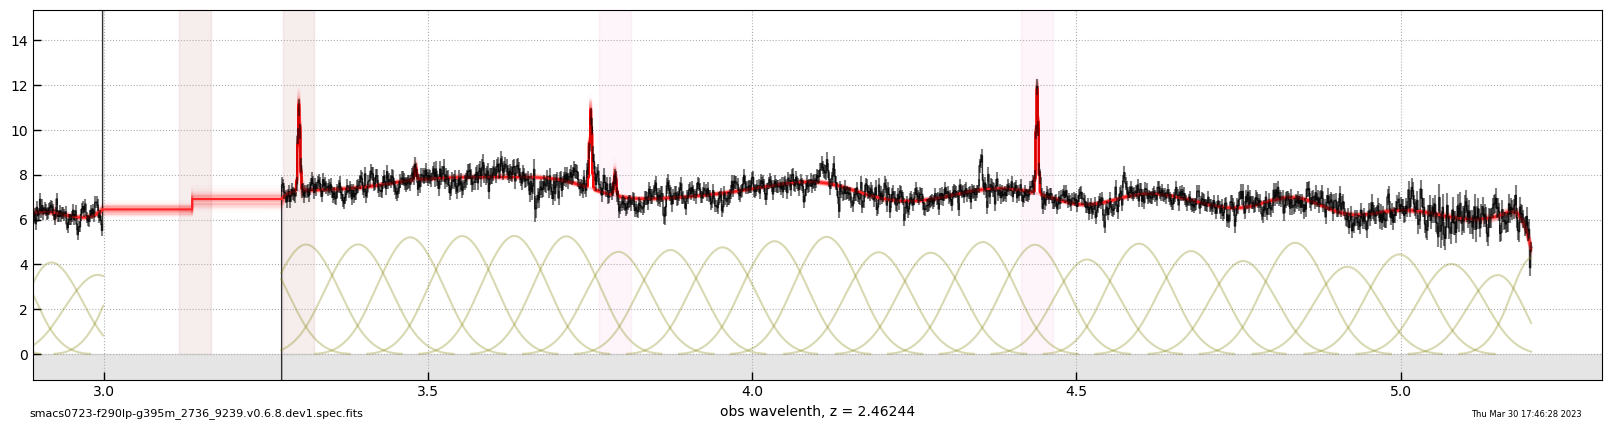

In [41]:
output_root = list(hdus.keys())[0]

_ = spectrum.fit_redshift(file=f'{output_root}.spec.fits', z0=[1,3], 
                          eazy_templates=otempl,
                          nspline=33,
                          scale_disp=1.0,
                          vel_width=10.,
                          is_prism=False,
                          use_full_dispersion=False,
                          ranges=[(3680, 4150), (4300, 4400), (4861-50, 5008+50)],
                         )

Set SCALE_UNCERTAINTY:  [  0.18534515  -2.28381322   9.23003579 -12.1276375 ]

# line flux err
# flux x 10^-20 erg/s/cm2
# smacs0723-f290lp-g395m_2736_9239.v0.6.8.dev1.spec.fits
# z = 2.46246
# Thu Mar 30 17:46:02 2023
      line SIII-9068        0.0 ±      0.0
      line SIII-9531      175.4 ±     14.3
            line PaD       25.3 ±     12.2
            line PaG       43.4 ±     12.7
            line PaB      210.1 ±     12.1
       line HeI-1083      158.9 ±     14.3
            line Pa8       -0.5 ±     11.9
            line Pa9        0.0 ±      0.0
           line Pa10        0.0 ±      0.0
       line HeI-8446       -0.1 ±      9.4


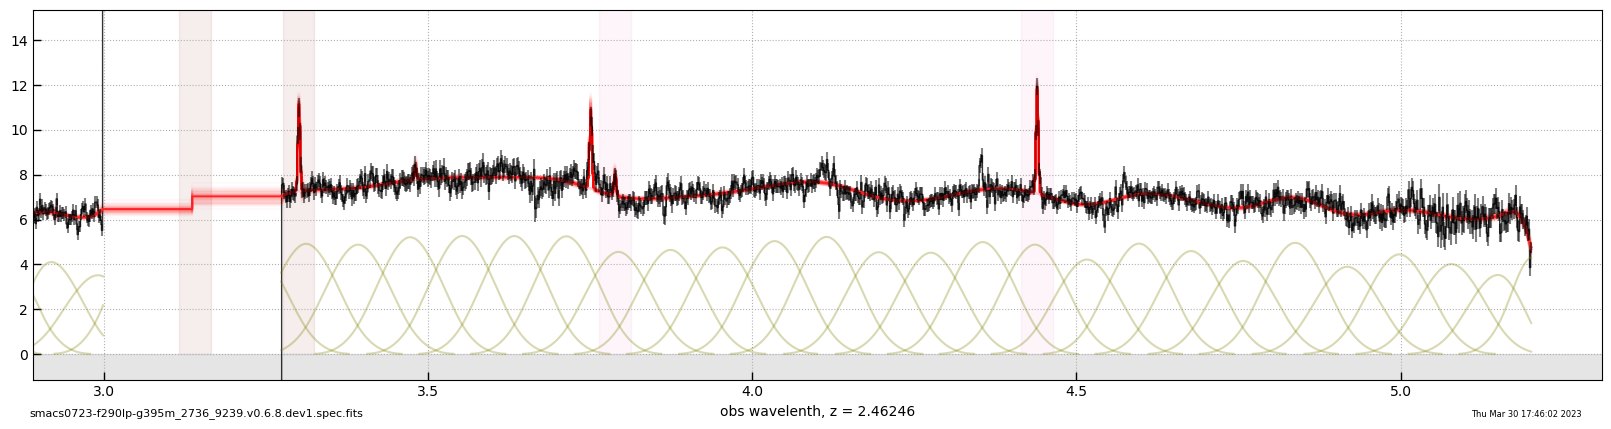

In [39]:
reload(spectrum)

spectrum.SCALE_UNCERTAINTY = 1.0

fig, sp, data = spectrum.plot_spectrum(file=f'{output_root}.spec.fits', 
                           z=_[2]['z'],
                          eazy_templates=None,
                          nspline=33,
                          scale_disp=1.0,
                          vel_width=10.,
                          is_prism=False,
                           scale_uncertainty_kwargs={'order':3, 'init':[1,3]},
                           use_full_dispersion=False,
                           Rline=5000,
                           ranges=[(3680, 4150), (4300, 4400), (4861-50, 5008+50)],
                         )

In [40]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
# carnall et al. and new redshifts
redshifts = {'2736_9922': 2.743,
             '2736_5144': 6.383,
             '2736_1917': 1.244,
             '2736_3772': 2.67e4/1.875e4-1, 
             '2736_4580': 3.09e4/5008.-1, # ?
             '2736_5735': 3.21e4/1.282e4-1,
             '2736_6113': 3.715,
             '2736_6355': 7.665,
             '2736_8140': 5.275,
             '2736_8506': 2.213,
             '2736_9236': 2.463,
             '2736_9483': 1.163,
             '2736_9721': 2.047e4/6564.-1,
             '2736_9922': 2.743,
             '2736_10612': 7.663,
             '2736_3042': 1.96e4/6564.-1,

             }

In [ ]:
# Looking at individual sources
ik = -1
targets

In [ ]:
key = targets[-1]
key = '2736_3042'

key = '2736_9922'
key = '2736_5144'
key = '2736_4798'
# key = '2736_4590'

#ik -= 3

ik += 1
key = targets[ik]

yoffset = 0.0
skip = []

for g in gratings:
    for pipe in gratings[g]:
        print(pipe.mode, key)
        if key == '2736_1370':
            yoffset = -4.0
            
        if key == '2736_8717':
            if '07001' in pipe.mode:
                skip = [0,1]
            else:
                skip = [0]
                
#         elif key == '2736_8506':
#             skip = [0]
            
#         elif key == '2736_8498':
#             yoffset = -12
            
#         if '07001' in pipe.mode:
#             skip = [0] # [0,1]
#             else:
#                 skip = [0]
                
#         elif key == '2736_3042':
#             yoffset = -14
#             skip = []
            
#         else:
#             skip = []
            
        try:
            _ = pipe.extract_spectrum(key, yoffset=yoffset, fit_profile_params=None, skip=skip)        
        except:
            plt.close('all')

In [ ]:
reload(msaexp.utils)

hdus = {}
for g in gratings:
    slits = []
    for pipe in gratings[g]:
        #_slits = pipe.get_background_slits(key, step='phot', check_background=False)
        _slits = pipe.get_background_slits(key) #, step='phot', check_background=False)
        if _slits is not None:
            slits.extend(_slits)
            
    print(g, len(slits))
    
    output_root = f'smacs0723-{g}_{key}_v3'

    hdus[output_root] = msaexp.utils.drizzle_2d_pipeline(slits, drizzle_params=drizzle_params,
                                        profile_slice=slice(int(200*scale), int(600*scale)),
                                        standard_waves=scale,
                                        outlier_threshold=10,
                                        output_root=output_root,
                                        fit_prf=False, prf_center=-0.4, prf_sigma=1.0, fix_sigma=True,
                                        #fit_prf=True, prf_center=-8., prf_sigma=1.0, fix_sigma=False,
                                        #fit_prf=True, prf_center=None, prf_sigma=1.0, fix_sigma=False,
                                                         center_limit=5)

    
    if key in redshifts:
        z = redshifts[key]
    else:
        z = None
    #z = 1.96e4/6564.-1

    fig = msaexp.utils.drizzled_hdu_figure(hdus[output_root], output_root=output_root, ny=None, z=z)


In [ ]:
z=3.21e4/1.282e4-1
z = 3.72
z = 2.047e4/6564.-1
z = 1.96e4/6564.-1

fig = msaexp.utils.drizzled_hdu_figure(hdus[output_root], output_root=output_root, ny=None, z=z)


In [ ]:
import grizli.utils

fig, ax = plt.subplots(1,1,figsize=(10,5))

if z is None:
    zi = 0.
else:
    zi = z

# zi = 3.715
    
for g in hdus:
    sp = grizli.utils.GTable(hdus[g]['SPEC1D'].data)
    ax.step(sp['wave']/(1+zi)*1.e4, sp['flux']*(sp['wave']/2.)**-2, alpha=0.5, where='mid')
    ax.step(sp['wave']/(1+zi)*1.e4, sp['err']*(sp['wave']/2.)**-2, alpha=0.5, where='mid')
    
#ax.set_xlim(2.25, 2.3)
# ax.set_xlim(9000, 1.4e4)
# ax.set_xlim(3600, 4400); ax.set_ylim(-0.05, 0.5)
# ax.set_xlim(4500, 8800); ax.set_ylim(-0.05, 1.5)
#ax.set_xlim(9000, 9800); ax.set_ylim(-0.05, 0.5)
#ax.set_xlim(9000, 18000); ax.set_ylim(-0.05, 0.5)


## Save any updates to the slit logs

In [ ]:
for g in gratings:
    for pipe in gratings[g]:
        pipe.parse_slit_info()

## Slit regions

In [ ]:
for k in pipe.slitlets:
    sd = pipe.slitlets[k]
    dr = (sd['source_ra'] - sd['slit_ra'])*np.cos(sd['source_dec']/180*np.pi)*3600
    dd = (sd['source_dec'] - sd['slit_dec'])*3600
    
    plt.scatter(dr, dd, alpha=0.1)
    

In [ ]:
from tqdm import tqdm
reload(msaexp.utils)

self = gratings[g][0]

slit_key = self.last_step
pipe = self.pipe[slit_key]

regs = []
for j in range(self.N):
    regs.append([])

include_yoffset = False

for key in tqdm(self.slitlets):
    slitlet = self.slitlets[key]
    #slitlet['bkg_index'], slitlet['src_index'], slitlet['slit_index']

    i = self.slit_index(key) # slitlet['slit_index']

    yoffset = slitlet['yoffset']

    dr = slitlet['source_ra'] - slitlet['slit_ra']
    dd = slitlet['source_dec'] - slitlet['slit_dec']

    for j in range(self.N):
        _slit = pipe[j].slits[i]
        _wcs = _slit.meta.wcs
        sh = _slit.data.shape
        
        rc, dc = msaexp.utils.get_slit_corners(_slit)
        
        xy = np.array([rc+dr, dc+dd])
        
        sr = grizli.utils.SRegion(xy)
        _name = slitlet['source_name']

        if '_m' in _name:
            sr.ds9_properties = 'color=yellow'
        elif 'b' in _name:
            sr.ds9_properties = 'color=white'
        else:
            sr.ds9_properties = 'color=green'

        if j == 0:
            sr.label = _name
            sr.ds9_properties += ' width=2'

        regs[j].append(sr)

_slitreg = f'{self.mode}.slits.reg'
print(_slitreg)
with open(_slitreg, 'w') as fp:
    for j in range(self.N):
            fp.write('icrs\n')
            for sr in regs[j]:
                fp.write(sr.region[0]+'\n')


In [ ]:
slit = slits[0]

In [ ]:
from gwcs import wcstools
for slit in slits:
    sh = slit.data.shape

    _wcs = slit.meta.wcs

    s2d = _wcs.get_transform('slit_frame', 'detector')
    d2s = _wcs.get_transform('detector', 'slit_frame')
    s2w = _wcs.get_transform('slit_frame', 'world')
    d2w = _wcs.get_transform('detector', 'world')

    bbox = _wcs.bounding_box
    grid = wcstools.grid_from_bounding_box(bbox)
    _, sy, slam = np.array(d2s(*grid))

    smi = np.nanmin(sy)
    sma = np.nanmax(sy)

    slit_x = np.array([-0.5, 0.5, 0.5, -0.5])
    slit_y = np.array([smi, smi, sma, sma])

    ra_corner, dec_corner, _w = s2w(slit_x, slit_y, np.nanmedian(slam))

    plt.plot(ra_corner, dec_corner)
    plt.scatter(slit.source_ra, slit.source_dec, marker='x')

In [ ]:
np.median(slam)